# Data Analysis
This is a notebook dedicated to the analysis of the dataset of Ubiquant market prediction Kaggle competition.

Several ideas are picked up from this kernel https://www.kaggle.com/code/bastiendelaval/analyse-oc such as correlations and PCA.

## Librairies

In [41]:
# Data Manipulation
import numpy as np
import pandas as pd
import random
import datetime
from itertools import product

# Get files content
import os
import joblib

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

import warnings

warnings.filterwarnings(action="ignore")

# scipy tools
from scipy.stats.stats import pearsonr

# sklearn tools
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    make_scorer,
)
from sklearn.model_selection import (
    learning_curve,
    cross_validate,
    GridSearchCV,
    RandomizedSearchCV,
    KFold,
    TimeSeriesSplit,
)

# XGBoost
from xgboost import XGBRegressor

# Tensorflow
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

# Code formatting
%load_ext nb_black

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Data importation

Use parquet version of the dataset thanks to this kernel https://www.kaggle.com/code/camilomx/parquet-format-quickstart

In [2]:
%%time

# Import dataset
path = "./train_low_mem.parquet"
df = pd.read_parquet(path)

CPU times: user 9.55 s, sys: 3.66 s, total: 13.2 s
Wall time: 2min 45s


<IPython.core.display.Javascript object>

## First look on the dataset

In [25]:
# Display first rows
df.head(5)

row_id  time_id  investment_id    target       f_0       f_1       f_2  \
0    0_1        0              1 -0.300875  0.932573  0.113691 -0.402206   
1    0_2        0              2 -0.231040  0.810802 -0.514115  0.742368   
2    0_6        0              6  0.568807  0.393974  0.615937  0.567806   
3    0_7        0              7 -1.064780 -2.343535 -0.011870  1.874606   
4    0_8        0              8 -0.531940  0.842057 -0.262993  2.330030   

        f_3       f_4       f_5  ...     f_290     f_291     f_292     f_293  \
0  0.378386 -0.203938 -0.413469  ...  0.366028 -1.095620  0.200075  0.819155   
1 -0.616673 -0.194255  1.771210  ... -0.154193  0.912726 -0.734579  0.819155   
2 -0.607963  0.068883 -1.083155  ... -0.138020  0.912726 -0.551904 -1.220772   
3 -0.606346 -0.586827 -0.815737  ...  0.382201  0.912726 -0.266359 -1.220772   
4 -0.583422 -0.618392 -0.742814  ... -0.170365  0.912726 -0.741355 -1.220772   

      f_294     f_295     f_296     f_297     f_298     f_299  
0  0.941183 -0.086764 -1.087009 -1.044826 -0.287605  0.321566  
1  0.941183 -0.387617 -1.087009 -0.929529 -0.974060 -0.343624  
2 -1.060166 -0.219097 -1.087009 -0.612428 -0.113944  0.243608  
3  0.941183 -0.609113  0.104928 -0.783423  1.151730 -0.773309  
4  0.941183 -0.588445  0.104928  0.753279  1.345611 -0.737624  

[5 rows x 304 columns]

<IPython.core.display.Javascript object>

There are 300 features named "f_i" for i in (0, 300). 

There is the target named "target".

Row_id is linked to investment_id and there is a column time_id

In [26]:
# Dimension
df.shape

(3141410, 304)

<IPython.core.display.Javascript object>

In [27]:
# Info about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3141410 entries, 0 to 3141409
Columns: 304 entries, row_id to f_299
dtypes: float32(301), object(1), uint16(2)
memory usage: 3.6+ GB


<IPython.core.display.Javascript object>

304 columns and more than 3M of rows.

Column row_id is dtype object.

In [28]:
print("Columns of dtype uint16 : ")
for col in df.select_dtypes("uint16"):
    print(col)

Columns of dtype uint16 : 
time_id
investment_id


<IPython.core.display.Javascript object>

In [29]:
# Data summary
df.describe()

time_id  investment_id        target           f_0           f_1  \
count  3.141410e+06   3.141410e+06  3.141410e+06  3.141410e+06  3.141410e+06   
mean   6.654862e+02   1.885265e+03 -2.109159e-02  1.637057e-03 -1.257678e-02   
std    3.560434e+02   1.083616e+03  9.176629e-01  1.079721e+00  1.030980e+00   
min    0.000000e+00   0.000000e+00 -9.419646e+00 -1.765789e+01 -6.579473e+00   
25%    3.530000e+02   9.520000e+02 -5.004572e-01 -4.071441e-01 -6.813878e-01   
50%    7.040000e+02   1.882000e+03 -9.717009e-02  2.431158e-01 -4.867587e-02   
75%    9.750000e+02   2.830000e+03  3.572908e-01  6.649507e-01  6.086557e-01   
max    1.219000e+03   3.773000e+03  1.203861e+01  7.845261e+00  8.707207e+00   

                f_2           f_3           f_4           f_5           f_6  \
count  3.141410e+06  3.141410e+06  3.141410e+06  3.141410e+06  3.141410e+06   
mean   8.514749e-03 -2.003703e-02 -5.416438e-03 -3.034008e-03  1.934330e-03   
std    1.030281e+00  9.602916e-01  9.895188e-01  1.104578e+00  1.067755e+00   
min   -8.644268e+00 -1.800427e+01 -4.000015e+00 -8.833704e+00 -6.384251e+00   
25%   -6.530838e-01 -4.496046e-01 -3.532303e-01 -7.070855e-01 -7.911198e-01   
50%    4.350941e-02 -2.639937e-01 -1.908876e-01 -2.144796e-02  1.437945e-02   
75%    6.587324e-01  7.763371e-02  2.784694e-02  6.835684e-01  8.008306e-01   
max    8.009340e+00  4.706333e+01  7.662866e+01  7.646200e+00  6.778142e+00   

       ...         f_290         f_291         f_292         f_293  \
count  ...  3.141410e+06  3.141410e+06  3.141410e+06  3.141410e+06   
mean   ...  1.256709e-02  9.002053e-04 -6.509154e-03  2.851608e-03   
std    ...  1.084496e+00  1.114387e+00  1.070176e+00  1.101158e+00   
min    ... -9.271487e+00 -6.359966e+00 -8.183732e+00 -2.399478e+01   
25%    ... -6.037326e-01 -8.355157e-01 -6.981400e-01 -1.377131e-01   
50%    ...  6.086323e-02 -2.023181e-01 -1.910102e-01  2.164071e-01   
75%    ...  6.882384e-01  9.035954e-01  4.841421e-01  5.088849e-01   
max    ...  9.298274e+00  9.725060e+00  2.231185e+01  6.587691e+00   

              f_294         f_295         f_296         f_297         f_298  \
count  3.141410e+06  3.141410e+06  3.141410e+06  3.141410e+06  3.141410e+06   
mean  -4.730820e-03 -2.773806e-02 -1.517383e-03 -7.057928e-03 -4.216896e-03   
std    1.144516e+00  9.592550e-01  1.140459e+00  1.108097e+00  1.051252e+00   
min   -1.497270e+01 -9.348986e+00 -7.366648e+00 -7.579406e+00 -6.707284e+00   
25%   -9.397985e-01 -5.147926e-01 -9.573807e-01 -7.239380e-01 -8.165390e-01   
50%    2.087202e-01 -2.907780e-01  6.955573e-03 -1.650222e-01  2.300689e-02   
75%    8.616266e-01  1.275946e-01  9.503851e-01  6.098197e-01  7.984827e-01   
max    6.978151e+00  6.140367e+01  7.679950e+00  1.241804e+01  7.003982e+00   

              f_299  
count  3.141410e+06  
mean  -4.319488e-03  
std    1.008220e+00  
min   -1.028264e+01  
25%   -5.080143e-01  
50%   -2.824031e-01  
75%    1.411301e-01  
max    4.337021e+01  

[8 rows x 303 columns]

<IPython.core.display.Javascript object>

Features seem to have low values (< 100) and can get be negative, even for the target.

As the means are very close to zero, we can consider that features f had already been standardized.

In [30]:
# Check if there are missing values
df.isnull().sum().sum()

0

<IPython.core.display.Javascript object>

There is no missing value.

### Reduce memory usage of the dataset
Many kernels use this function to reduce the memory usage of the dataset (to avoid Memory-over error). I didn't find the original kernel that introduce this.

Be careful it takes a long time.

EDIT : it seems that there is a lost of information, especially when we get the describe information. I am not sure if it is a good idea.

I wrote a notebook about it https://www.kaggle.com/code/larochemf/ubiquant-low-memory-use-be-careful.

In [3]:
%%time

def reduce_mem_usage(df):

    start_mem = df.memory_usage().sum() / 1024 ** 2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024 ** 2

    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df


df = reduce_mem_usage(df)

Memory usage of dataframe is 3642.99 MB
Memory usage after optimization is: 1915.96 MB
Decreased by 47.4%
CPU times: user 3min 10s, sys: 2min 39s, total: 5min 49s
Wall time: 5min 51s


<IPython.core.display.Javascript object>

In [23]:
# Data summary
df.describe()

time_id  investment_id        target           f_0           f_1  \
count  3141410.0      3141410.0  3.141410e+06  3.141410e+06  3.141410e+06   
mean         NaN            NaN           NaN  1.633644e-03 -1.258850e-02   
std          NaN            NaN  0.000000e+00  0.000000e+00  0.000000e+00   
min          0.0            0.0 -9.421875e+00 -1.765625e+01 -6.578125e+00   
25%        353.0          952.0 -5.004883e-01 -4.072266e-01 -6.811523e-01   
50%        704.0         1882.0 -9.716797e-02  2.431641e-01 -4.867554e-02   
75%        975.0         2830.0  3.571777e-01  6.650391e-01  6.088867e-01   
max       1219.0         3772.0  1.203906e+01  7.843750e+00  8.710938e+00   

                f_2           f_3           f_4           f_5           f_6  \
count  3.141410e+06  3.141410e+06  3.141410e+06  3.141410e+06  3.141410e+06   
mean   8.499146e-03 -1.992798e-02 -5.428314e-03 -3.021240e-03  1.940727e-03   
std    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
min   -8.640625e+00 -1.800000e+01 -4.000000e+00 -8.835938e+00 -6.382812e+00   
25%   -6.533203e-01 -4.497070e-01 -3.532715e-01 -7.070312e-01 -7.910156e-01   
50%    4.351807e-02 -2.639160e-01 -1.909180e-01 -2.145386e-02  1.438141e-02   
75%    6.586914e-01  7.763672e-02  2.784729e-02  6.835938e-01  8.007812e-01   
max    8.007812e+00  4.706250e+01  7.662500e+01  7.644531e+00  6.777344e+00   

       ...         f_290         f_291         f_292         f_293  \
count  ...  3.141410e+06  3.141410e+06  3.141410e+06  3.141410e+06   
mean   ...  1.258850e-02  8.964539e-04 -6.500244e-03  2.836227e-03   
std    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
min    ... -9.273438e+00 -6.359375e+00 -8.187500e+00 -2.400000e+01   
25%    ... -6.035156e-01 -8.354492e-01 -6.982422e-01 -1.376953e-01   
50%    ...  6.085205e-02 -2.022705e-01 -1.910400e-01  2.164307e-01   
75%    ...  6.884766e-01  9.038086e-01  4.841309e-01  5.087891e-01   
max    ...  9.296875e+00  9.726562e+00  2.231250e+01  6.585938e+00   

              f_294         f_295         f_296         f_297         f_298  \
count  3.141410e+06  3.141410e+06  3.141410e+06  3.141410e+06  3.141410e+06   
mean  -4.730225e-03           NaN -1.508713e-03 -7.053375e-03 -4.215240e-03   
std    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
min   -1.497656e+01 -9.351562e+00 -7.367188e+00 -7.578125e+00 -6.707031e+00   
25%   -9.399414e-01 -5.146484e-01 -9.575195e-01 -7.241211e-01 -8.164062e-01   
50%    2.087402e-01 -2.907715e-01  6.954193e-03 -1.650391e-01  2.301025e-02   
75%    8.618164e-01  1.275635e-01  9.501953e-01  6.098633e-01  7.983398e-01   
max    6.976562e+00  6.140625e+01  7.679688e+00  1.242188e+01  7.003906e+00   

              f_299  
count  3.141410e+06  
mean  -4.329681e-03  
std    0.000000e+00  
min   -1.028125e+01  
25%   -5.078125e-01  
50%   -2.824707e-01  
75%    1.411133e-01  
max    4.337500e+01  

[8 rows x 303 columns]

<IPython.core.display.Javascript object>

## Features analysis

We are going to analyse features, with some points taken from this kernel https://www.kaggle.com/code/jiahauc/ubiqunt-eda-linearregression
### Investment

In [31]:
investments = df["investment_id"].nunique()
print("Number of unique investiment_id : ", investments)

Number of unique investiment_id :  3579


<IPython.core.display.Javascript object>

In [32]:
df["investment_id"].value_counts()

2140    1211
2385    1209
1062    1209
1144    1209
2727    1209
        ... 
905        8
2558       8
3662       7
2800       3
1415       2
Name: investment_id, Length: 3579, dtype: int64

<IPython.core.display.Javascript object>

It seems that several investments have low frequency.

In [33]:
df.loc[df["investment_id"] == 905]

row_id  time_id  investment_id    target       f_0       f_1  f_2  \
3114764  1212_905     1212            905  0.000000 -0.252274  1.872387  0.0   
3118203  1213_905     1213            905  0.000000  0.493875  1.320280  0.0   
3121643  1214_905     1214            905  2.146115  0.550417  0.807305  0.0   
3125082  1215_905     1215            905 -1.416078  0.559272  0.318800  0.0   
3128514  1216_905     1216            905  1.967065  0.782685 -0.057016  0.0   
3131924  1217_905     1217            905  1.357834  0.672741 -0.451416  0.0   
3135350  1218_905     1218            905 -1.402726  0.289558 -0.486492  0.0   
3138783  1219_905     1219            905 -3.046411  0.482918 -0.330059  0.0   

              f_3       f_4       f_5  ...     f_290     f_291     f_292  \
3114764  4.923997  0.670442 -0.845651  ... -0.311686 -0.770785  5.261123   
3118203  3.733451  0.778219  1.180876  ... -0.295776 -0.635073  4.657701   
3121643  3.269549  0.757987  1.683211  ... -0.274161 -0.718450  2.626396   
3125082  3.273175  0.761414  1.991194  ... -0.979614 -0.694756 -0.071421   
3128514  3.911410  0.814832  2.456574  ... -0.241323 -0.730822  0.745772   
3131924  3.066842  0.751619  1.683241  ... -0.221902 -1.651239  0.945587   
3135350  3.389831  0.797012 -1.569283  ...  0.102714  1.220921  0.463999   
3138783  3.816887  0.826104 -1.804322  ... -0.818708  0.811402 -0.613150   

            f_293     f_294     f_295     f_296     f_297     f_298     f_299  
3114764  0.484249  1.284623  5.690303  0.902837 -0.551608  0.000000 -0.747439  
3118203  1.114632  0.785815  5.434180  0.859254 -0.394131  0.000000 -0.744025  
3121643  0.920422 -0.713328  3.415019  1.051396 -0.597937  0.000000  5.406450  
3125082  0.769126  0.966756  2.679727  1.138049 -0.651654  0.000000  5.052356  
3128514 -1.161238  0.858016  2.376080  0.944268 -0.917331  2.228480  5.241991  
3131924  0.405561 -1.481123  1.855866  0.611560 -0.768422  2.030847  5.096809  
3135350  0.482149 -1.033200  2.159562  1.132108  1.376168  1.838660  5.095539  
3138783 -1.142157  0.421628  2.611042  1.363181  4.093065  1.701075  4.794515  

[8 rows x 304 columns]

<IPython.core.display.Javascript object>

In [34]:
# Get list of number investment_id appearing less than 5, 10.. until 100 times
list_invest = []

for i in range(5, 101, 5):
    list_invest.append((df["investment_id"].value_counts() < i).sum())

<IPython.core.display.Javascript object>

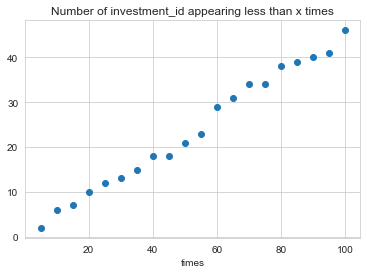

<IPython.core.display.Javascript object>

In [35]:
# Plot the result
plt.scatter(range(5, 101, 5), list_invest)
plt.title("Number of investment_id appearing less than x times")
plt.xlabel("times")
plt.show()

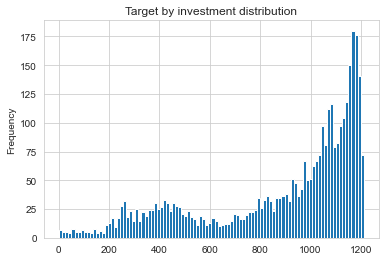

<IPython.core.display.Javascript object>

In [36]:
# Let's group by investment_id and see distribution
obs_by_investments = df.groupby(["investment_id"])["target"].count()

obs_by_investments.plot(kind="hist", bins=100)
plt.title("Target by investment distribution")
plt.show()

In [37]:
obs_by_investments

investment_id
0        461
1       1108
2       1003
3       1076
4        316
        ... 
3768    1052
3769    1171
3770     889
3772    1084
3773     376
Name: target, Length: 3579, dtype: int64

<IPython.core.display.Javascript object>

In [38]:
# Get mean values of the target when group by investment_id
mean_targets = df.groupby(["investment_id"])["target"].mean()
mean_targets

investment_id
0       0.052841
1      -0.025687
2      -0.051106
3       0.046773
4      -0.047773
          ...   
3768   -0.027151
3769   -0.028946
3770   -0.073020
3772   -0.013986
3773   -0.015845
Name: target, Length: 3579, dtype: float32

<IPython.core.display.Javascript object>

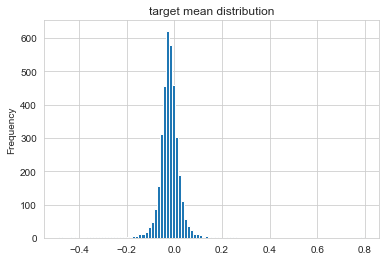

<IPython.core.display.Javascript object>

In [39]:
# Plot these means distributions
mean_targets.plot(kind="hist", bins=100)
plt.title("target mean distribution")
plt.show()

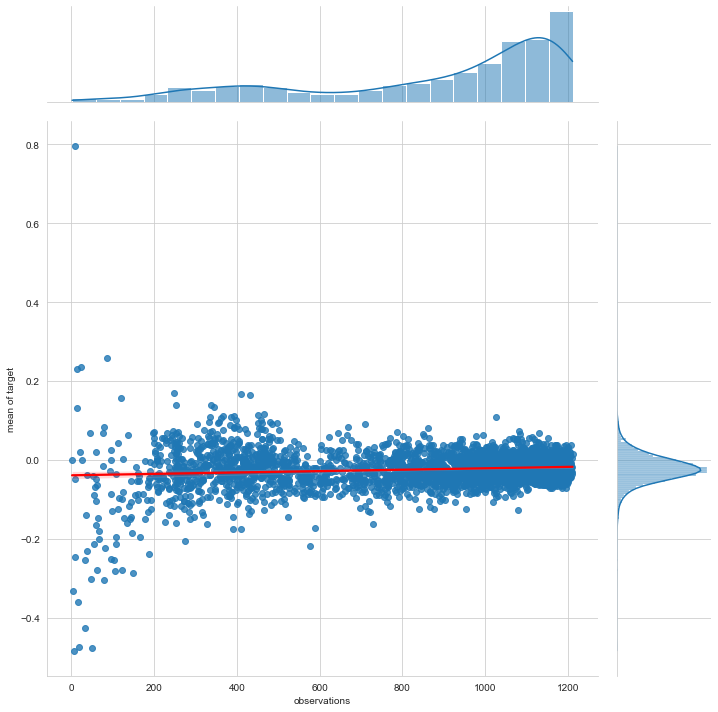

<IPython.core.display.Javascript object>

In [40]:
ax = sns.jointplot(
    x=obs_by_investments,
    y=mean_targets,
    kind="reg",
    height=10,
    joint_kws={"line_kws": {"color": "red"}},
)
ax.ax_joint.set_xlabel("observations")
ax.ax_joint.set_ylabel("mean of target")
plt.show()

Through this joint plot of observations in each investment and mean target value in each investment, it shows there is a growing trend when the observations increase. Also, the dispersion of target values is more apparent when the number of recorded investments is relatively low

### time_id

In [41]:
timestamps = df["time_id"].nunique()
print("Number of unique time_id : ", timestamps)

Number of unique time_id :  1211


<IPython.core.display.Javascript object>

In [42]:
df["time_id"].value_counts()

1214    3445
1209    3444
1211    3440
1207    3440
1208    3438
        ... 
415      659
362      651
374      600
398      539
492      512
Name: time_id, Length: 1211, dtype: int64

<IPython.core.display.Javascript object>

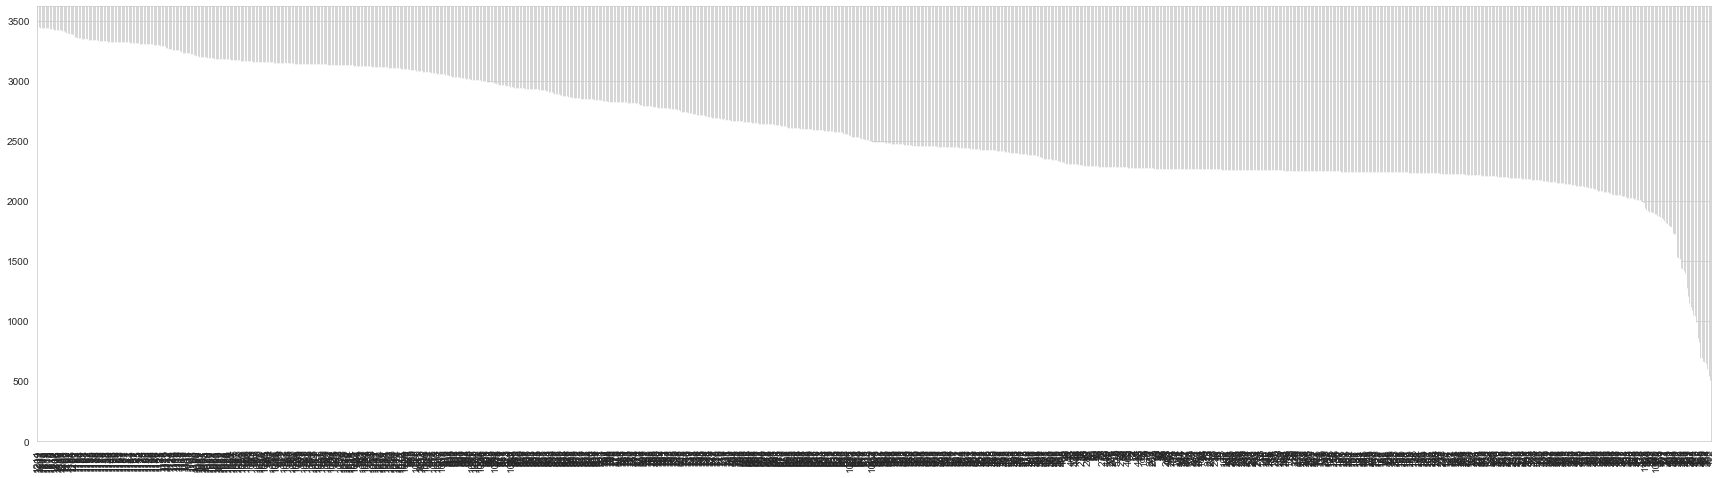

<IPython.core.display.Javascript object>

In [43]:
plt.figure(figsize=(30, 8))
df["time_id"].value_counts().plot(kind="bar")
plt.show()

In [44]:
print(
    "Percent of time_id value_counts >= 2000 : {}%".format(
        round(
            (df["time_id"].value_counts() >= 2000).sum()
            / len(df["time_id"].value_counts())
            * 100,
            1,
        )
    )
)

Percent of time_id value_counts >= 2000 : 95.8%


<IPython.core.display.Javascript object>

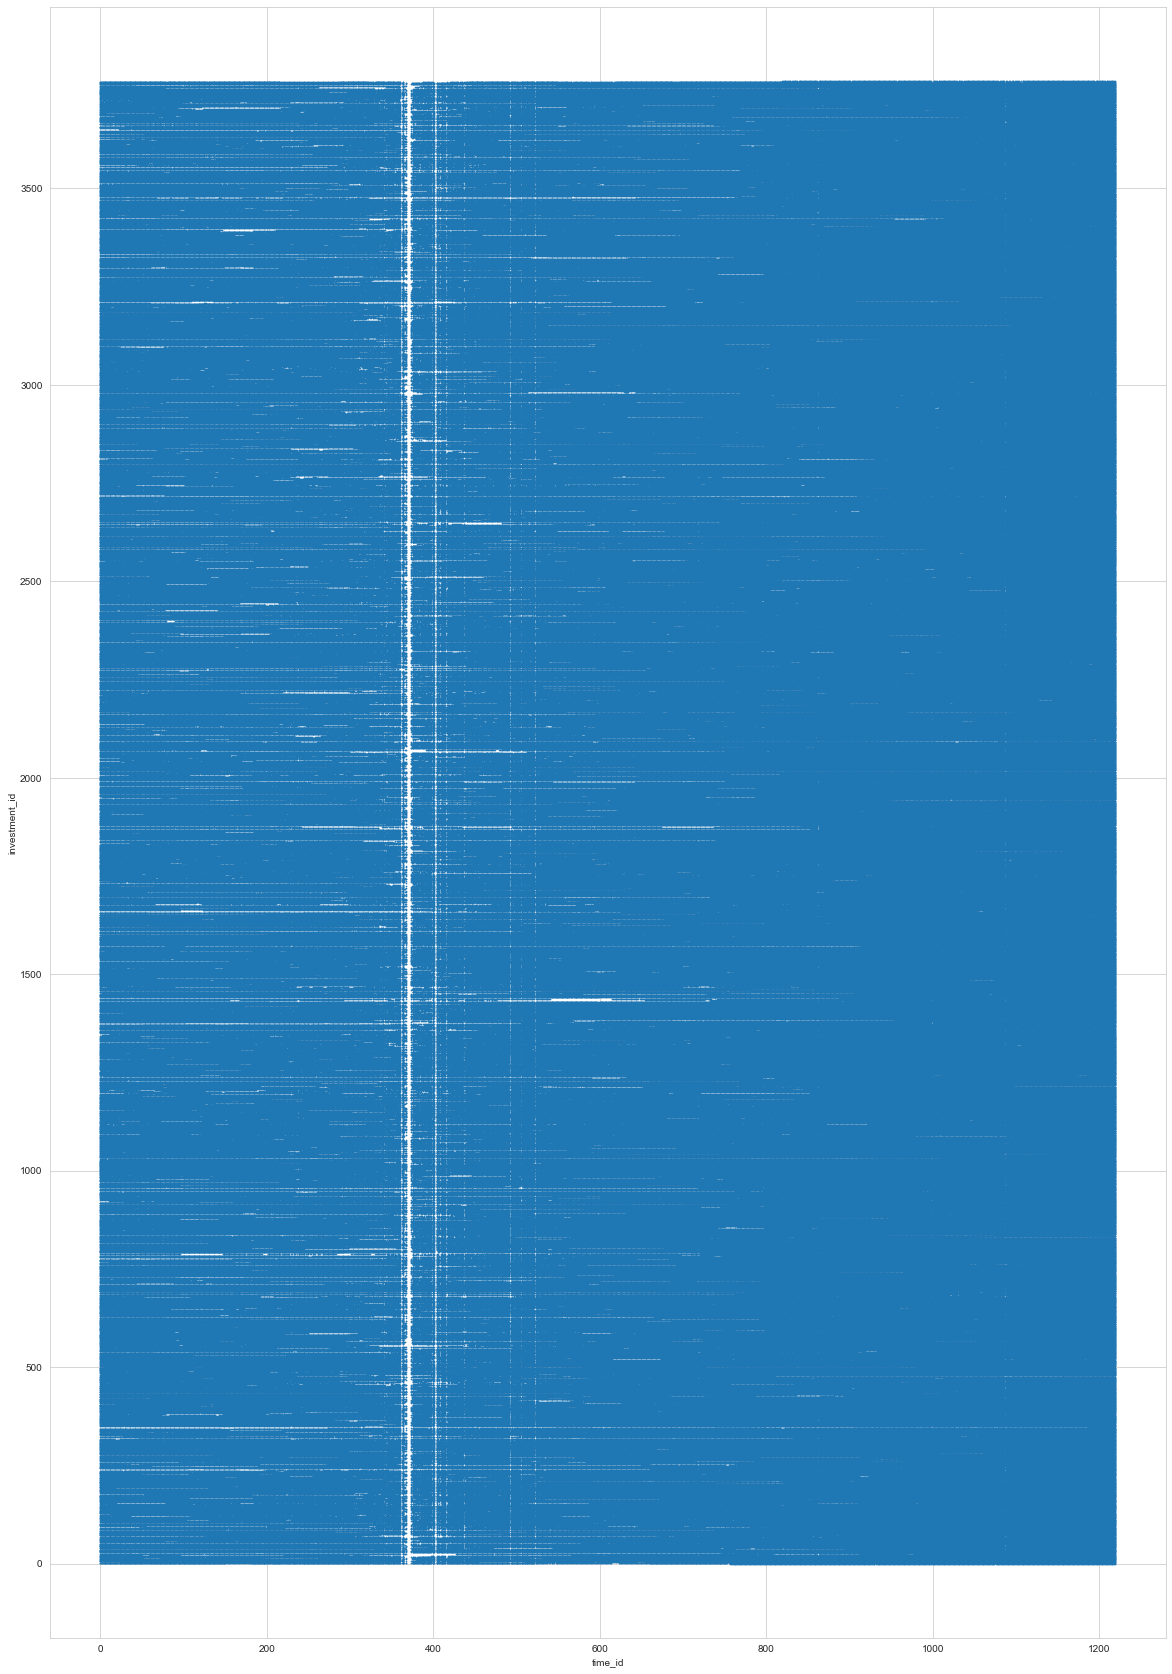

<IPython.core.display.Javascript object>

In [45]:
# Let's plot investment_id and time_id together
df[["time_id", "investment_id"]].plot(
    kind="scatter", x="time_id", y="investment_id", figsize=(20, 30), s=0.5
)
plt.show()

We can see that investment_id are more present with high time_id.

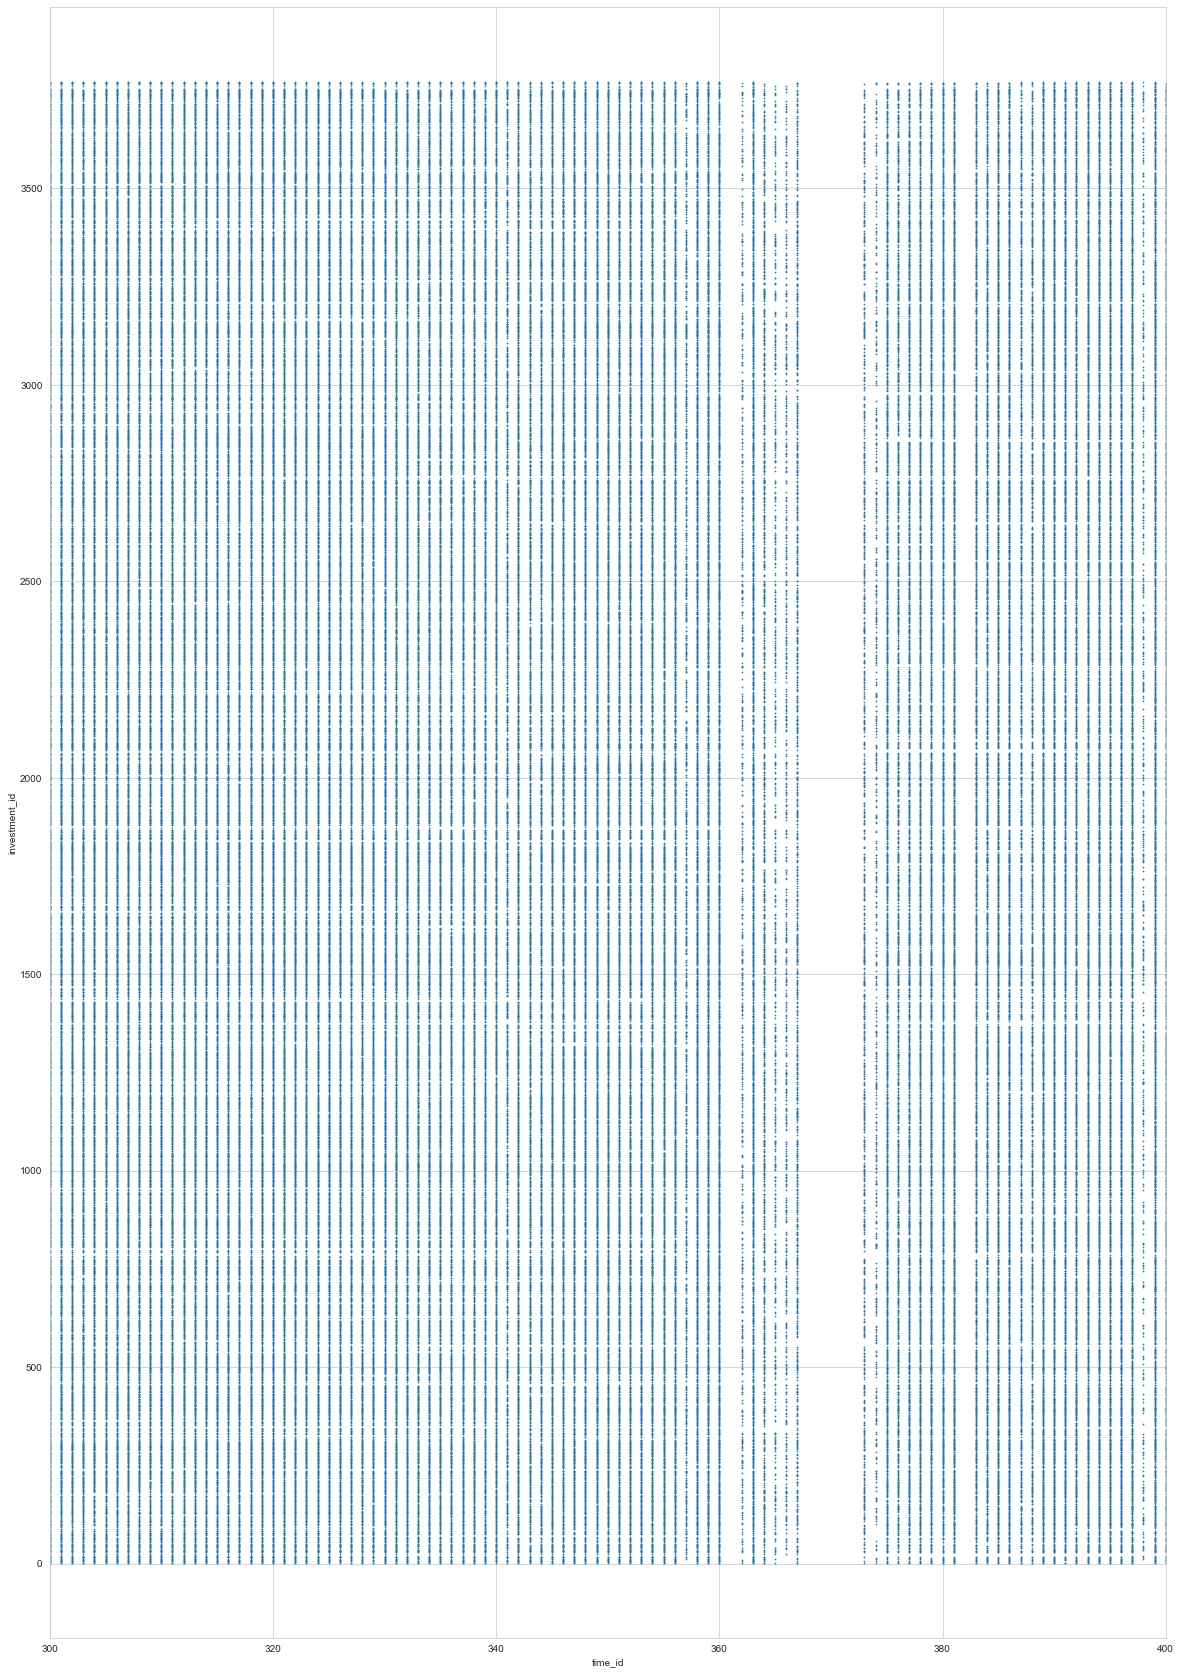

<IPython.core.display.Javascript object>

In [46]:
df[["time_id", "investment_id"]].plot(
    kind="scatter", x="time_id", y="investment_id", figsize=(20, 30), s=0.5
)
plt.xlim(300, 400)
plt.show()

### Features f_i
A histogram of all features is available at this kernel https://www.kaggle.com/code/mk1001/eda-f-0-299-histogram/notebook.

Let's see randomly six of them with boxplot :

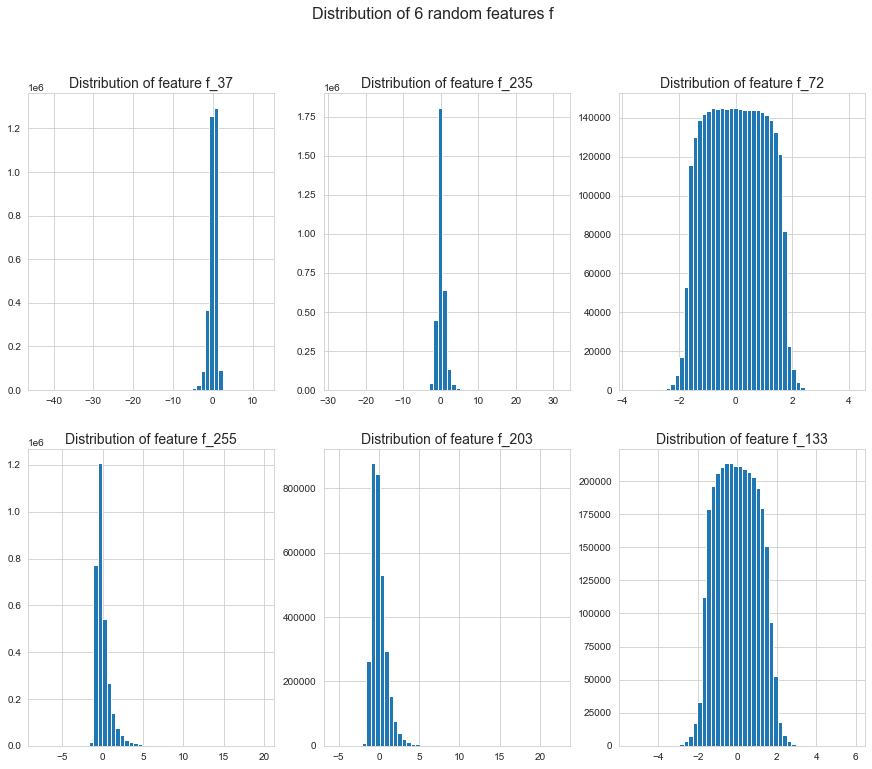

<IPython.core.display.Javascript object>

In [47]:
np.random.seed(1)

# Initiate counter
i = 1

# Initiate plot
plt.figure(figsize=(15, 12))
plt.suptitle("Distribution of 6 random features f", size=16)

# Plot randomly 6 histograms of features f_
for f in np.random.choice(range(0, 300), 6):
    plt.subplot(2, 3, i)
    df["f_{}".format(f)].hist(bins=50)
    plt.title("Distribution of feature f_{}".format(f), size=14)
    i += 1

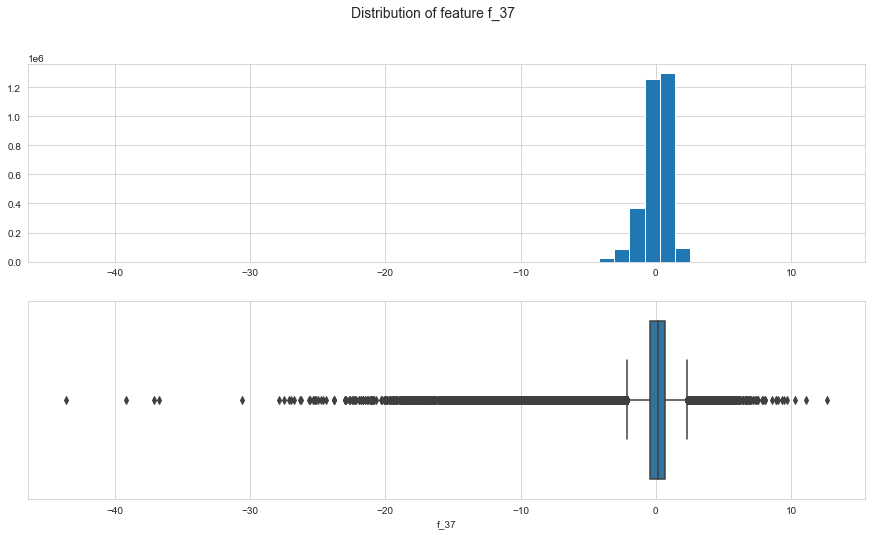

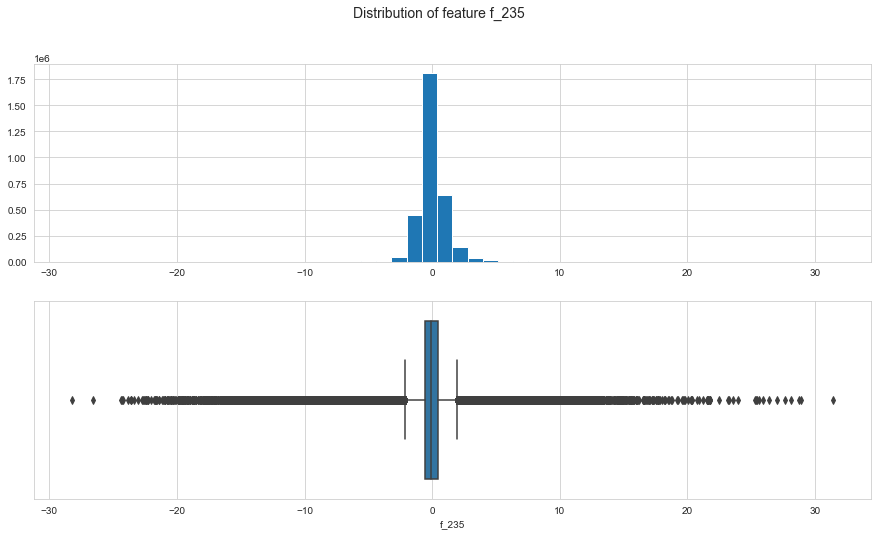

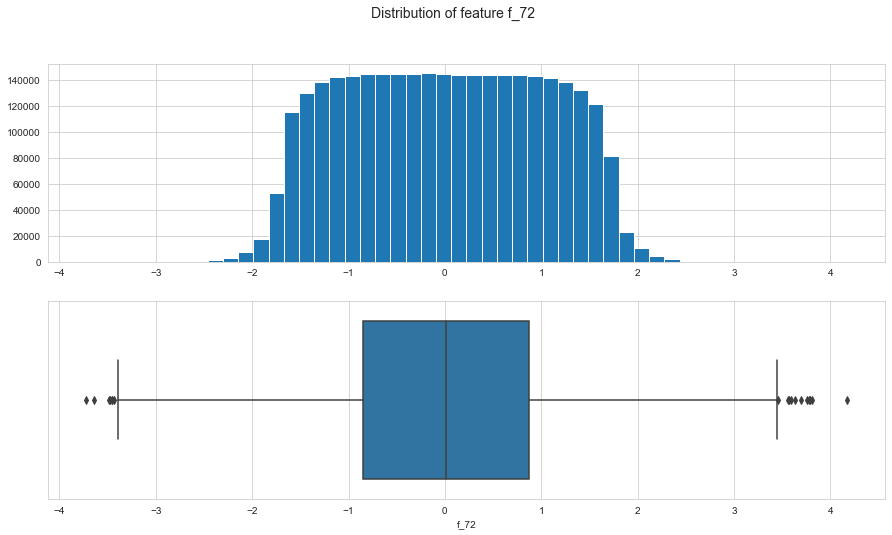

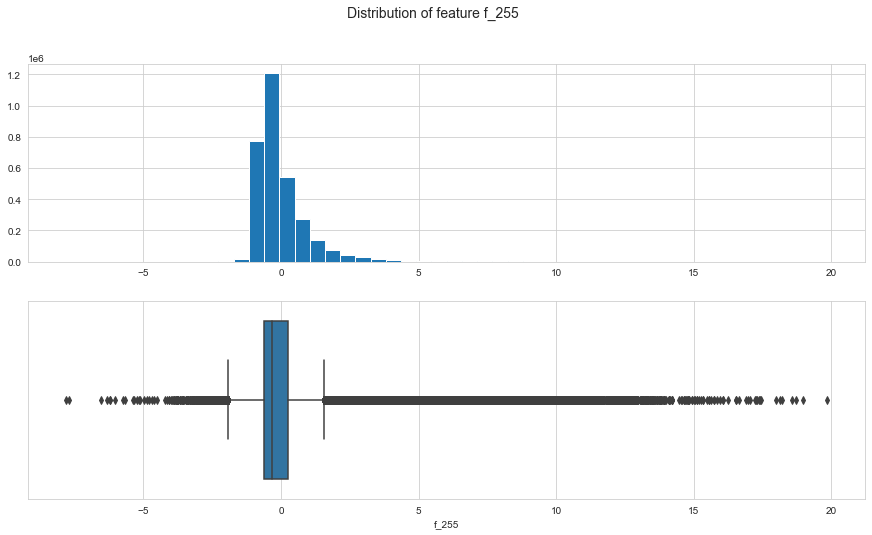

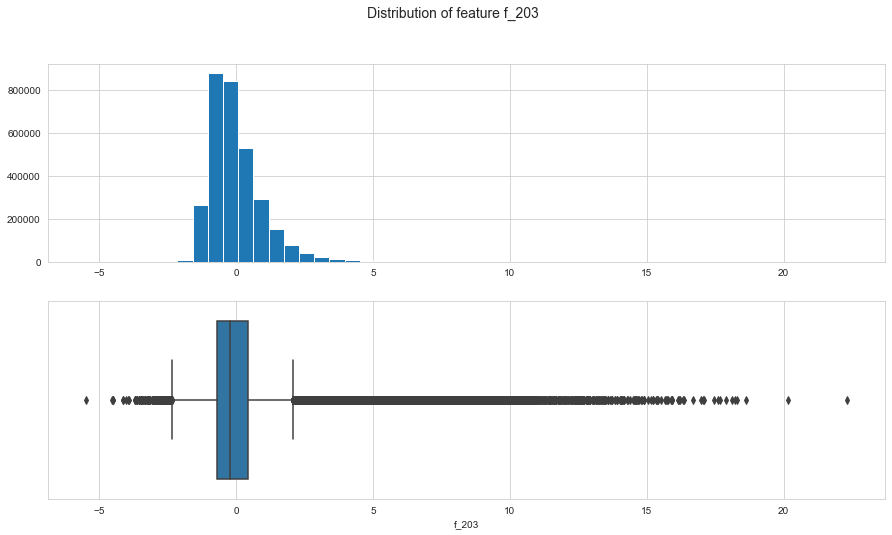

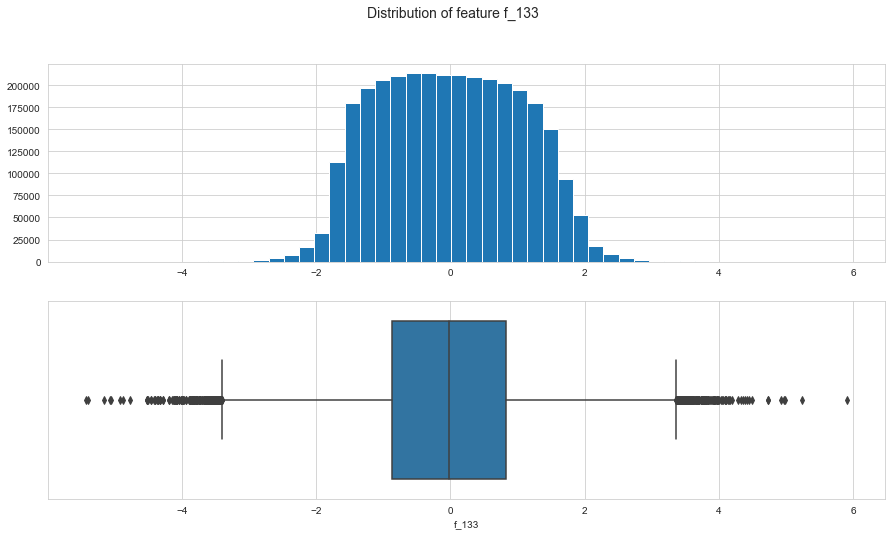

<IPython.core.display.Javascript object>

In [3]:
np.random.seed(1)

# Plot randomly 6 histograms and boxplots of features f_
for f in np.random.choice(range(0, 300), 6):
    
    # Initiate plot
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    plt.suptitle("Distribution of feature f_{}".format(f), size=14)
    
    # Target histogram
    df["f_{}".format(f)].hist(bins=50, ax=axes[0])

    # Target Boxplot
    sns.boxplot(x="f_{}".format(f), data=df, ax=axes[1])
    plt.show()

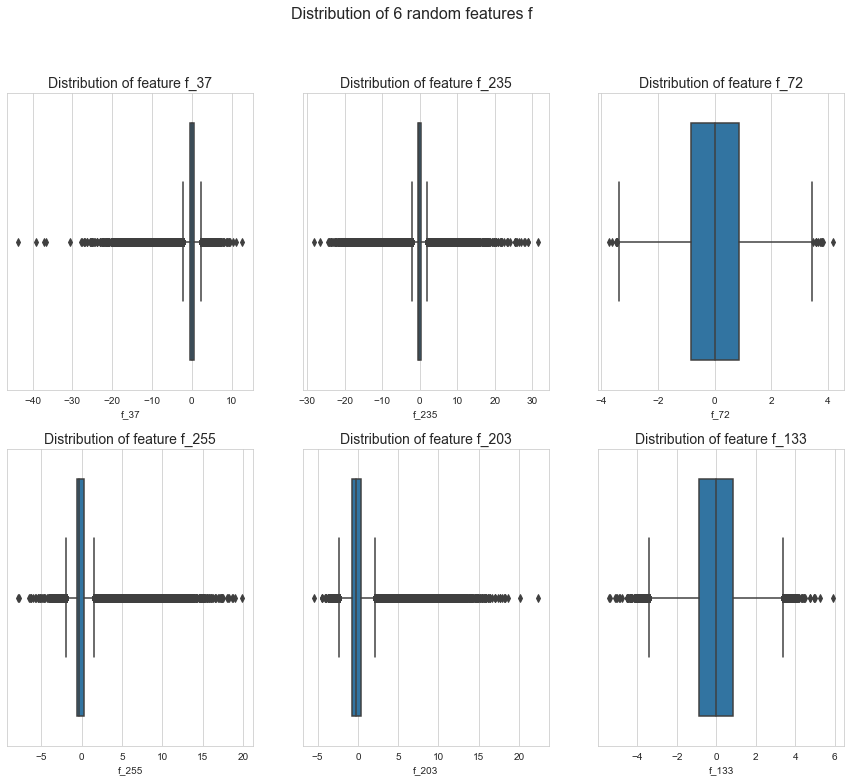

<IPython.core.display.Javascript object>

In [122]:
np.random.seed(1)

# Initiate counter
i = 1

# Initiate plot
plt.figure(figsize=(15, 12))
plt.suptitle("Distribution of 6 random features f", size=16)

# Plot randomly 6 histograms of features f_
for f in np.random.choice(range(0, 300), 6):
    plt.subplot(2, 3, i)
    sns.boxplot(x="f_{}".format(f), data=df)
    plt.title("Distribution of feature f_{}".format(f), size=14)
    i += 1

Some features are centered in zero.

Some of them get outliers as the distribution is not centered. So maybe, in the future we could consider to normalize data with a Robust Scaler in order to limit the influence of outliers.

In [49]:
# List of features columns
features = [f"f_{i}" for i in range(0, 300)]

<IPython.core.display.Javascript object>

### Target
Let's see the target distribution.

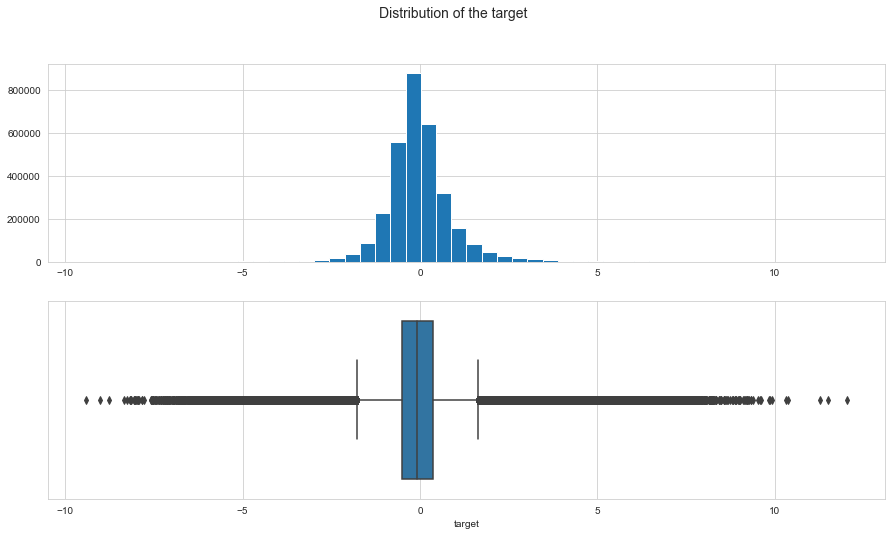

<IPython.core.display.Javascript object>

In [50]:
# Initiate plot
f, axes = plt.subplots(2, 1, figsize=(15, 8))

plt.suptitle("Distribution of the target", size=14)

# Target histogram
df["target"].hist(bins=50, ax=axes[0])

# Target Boxplot
sns.boxplot(x="target", data=df, ax=axes[1])
plt.show()

In [51]:
mean_target = df["target"].mean()
std_target = df["target"].std()
print("Target mean value : ", mean_target)
print("Target std value : ", std_target)

Target mean value :  -0.021091585978865623
Target std value :  0.9176628589630127


<IPython.core.display.Javascript object>

In [22]:
mean_target

nan

<IPython.core.display.Javascript object>

The distribution seems to be gaussian.

Let's plot the target distribution for some investment_id :

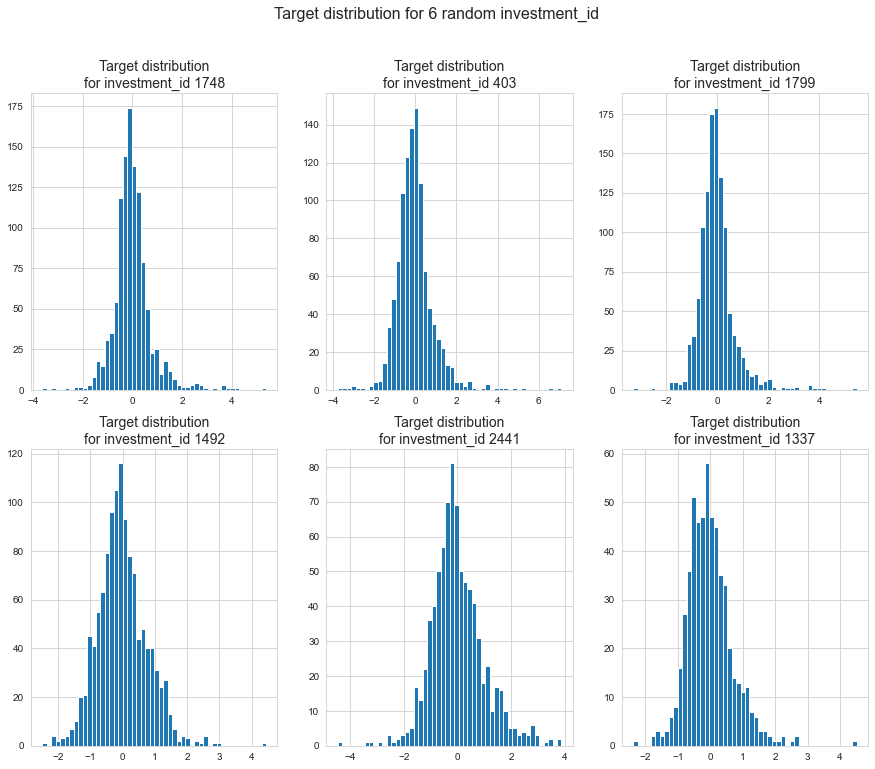

<IPython.core.display.Javascript object>

In [52]:
np.random.seed(1)

# Initiate counter
i = 1

# Initiate plot
plt.figure(figsize=(15, 12))
plt.suptitle("Target distribution for 6 random investment_id", size=16)

# Plot randomly 6 histograms of the target
for j in np.random.choice(df["investment_id"].unique(), 6):
    plt.subplot(2, 3, i)
    df[df["investment_id"] == j]["target"].hist(bins=50)
    plt.title("Target distribution\nfor investment_id {}".format(j), size=14)
    i += 1

For individual investment_id, target distribution seems to be less gaussian. Some values are high for values being at the "tail of the distribution" (e.g. investment_id 2441, 1337).

### Bidimensional analysis
Let's take a sample of the data.

In [53]:
sample_df = df.sample(frac=0.05, random_state=1)
sample_df

row_id  time_id  investment_id    target       f_0       f_1  \
607231     270_482      270            482  1.393967  0.563777  0.329479   
1435447   653_1885      653           1885  0.444124 -0.293736  0.655731   
1719449   759_3490      759           3490  0.280826  0.164325  0.872954   
2166750   914_2149      914           2149  1.096577  0.941188  0.873456   
399169    176_3484      176           3484 -0.114734  0.869987  0.410584   
...            ...      ...            ...       ...       ...       ...   
2248400   940_3636      940           3636  0.008491  0.935135 -1.455870   
778810     350_919      350            919 -0.376004 -1.357517 -0.255878   
258031    113_3187      113           3187 -0.271133  0.714163  1.133366   
2866111  1137_1967     1137           1967 -0.059472 -1.662638  0.263819   
2661339  1073_1720     1073           1720  0.712074  0.841166  0.113596   

              f_2       f_3       f_4       f_5  ...     f_290     f_291  \
607231  -1.315388  1.401520  0.016631  1.121079  ...  0.847788 -0.819923   
1435447  2.352335  0.026236 -0.572945 -0.872195  ...  0.014079 -0.768240   
1719449  0.018527 -0.321309 -0.169804 -1.195469  ... -0.117692  1.045337   
2166750 -1.988921  2.852207  0.489025  1.074427  ... -1.242727 -1.019845   
399169   1.002557 -0.255925 -0.539050 -1.188686  ... -0.753905 -0.516182   
...           ...       ...       ...       ...  ...       ...       ...   
2248400  1.542440 -0.427455 -0.289459 -0.174019  ... -0.033160  0.862841   
778810   0.837919 -1.442843 -0.489968  0.982652  ... -0.508619 -0.750760   
258031   0.130781 -0.394935 -0.343455 -0.903826  ... -0.381002 -0.588363   
2866111 -0.863438 -0.418975 -0.195200  1.982726  ...  0.107851  1.127201   
2661339  1.118893 -0.608249 -0.243095 -0.024478  ...  0.976030 -1.058461   

            f_292     f_293     f_294     f_295     f_296     f_297     f_298  \
607231   0.835474  0.319715  0.555386  0.556217  1.071587 -0.586470 -0.411992   
1435447 -0.457168  0.472227  0.968007 -0.637575 -1.078555 -1.184083 -0.522147   
1719449 -0.246952  0.198558 -1.068690 -0.164562 -0.910962  0.178173 -0.027948   
2166750  3.756444  0.844376 -1.028926  2.516795  1.265585  0.255740  0.758226   
399169   0.544362  0.150008  2.002837 -0.556329 -1.540250  0.551607  0.379718   
...           ...       ...       ...       ...       ...       ...       ...   
2248400 -0.355079  0.319239  1.099015 -0.516841  1.039523 -0.499201  1.388868   
778810  -1.238941  0.099460 -1.539896 -0.880276  0.082330 -0.852978  1.616588   
258031   0.042733  0.385851 -0.609556 -0.363498 -0.129711 -0.550309  0.962057   
2866111 -0.318118  1.135920  1.022511 -0.328731  1.280213  0.640524  0.185460   
2661339 -0.705783  1.335670 -0.010458 -0.835069  1.579181  0.235726  0.873787   

            f_299  
607231   0.412774  
1435447 -0.691200  
1719449 -0.385263  
2166750 -0.830256  
399169  -0.778006  
...           ...  
2248400 -0.535364  
778810  -0.303441  
258031  -0.769098  
2866111 -0.297201  
2661339 -0.692945  

[157070 rows x 304 columns]

<IPython.core.display.Javascript object>

In [83]:
# Sort by time_id and investment_id to get data in order 
# and reset index
sample_df = sample_df.sort_values(
    ["time_id", "investment_id"], ascending=[True, True]
).reset_index(drop=True)
sample_df

row_id  time_id  investment_id    target       f_0       f_1  \
0            0_19        0             19  0.685847  0.025283 -0.011870   
1            0_98        0             98  0.586187  0.677165 -0.011870   
2           0_173        0            173  1.076665  0.353120  0.615937   
3           0_315        0            315  1.121235  0.861542  1.494866   
4           0_335        0            335  3.161701  0.736542  0.113691   
...           ...      ...            ...       ...       ...       ...   
157065  1219_3617     1219           3617 -1.081809 -0.015136  1.360878   
157066  1219_3624     1219           3624 -1.027750 -0.685306 -0.720275   
157067  1219_3679     1219           3679  1.321338  0.688519 -0.590203   
157068  1219_3759     1219           3759 -0.059480  0.498102  0.840589   
157069  1219_3766     1219           3766  0.351797  0.892171 -1.760851   

             f_2       f_3       f_4       f_5  ...     f_290     f_291  \
0      -0.390564 -0.600695 -0.218549  1.253159  ...  0.333684  0.912726   
1      -0.523899  0.419864 -0.114329  1.740953  ... -1.146118  0.912726   
2      -0.082875  0.778190  0.159433  1.843599  ...  0.366028  0.912726   
3      -0.089574  1.295896  0.006026  0.402792  ... -1.146118  0.912726   
4      -1.845710  3.024322 -0.074793  1.738294  ... -0.609724 -1.095620   
...          ...       ...       ...       ...  ...       ...       ...   
157065  1.454888 -0.448471  0.706850 -1.978520  ...  0.137736  0.811402   
157066  1.109542 -0.442211 -0.095155  0.119591  ...  1.125366  0.811402   
157067  1.097954 -0.457912 -0.101383  0.555881  ...  3.007065  0.811402   
157068  0.310822  0.141530  0.500877  0.015716  ... -0.301501  0.811402   
157069  0.135189 -0.405799 -0.214687  0.142001  ...  0.639348 -1.232434   

           f_292     f_293     f_294     f_295     f_296     f_297     f_298  \
0      -0.122073  0.819155 -1.060166 -0.169155  0.104928  0.404938 -0.261311   
1       0.669720  0.819155  0.941183 -0.128453  1.296864  1.315424 -0.944005   
2       1.797567  0.819155 -1.060166  0.884854 -1.087009 -1.365066 -1.132301   
3       3.382770  0.819155 -1.060166  0.007830 -1.087009  0.297326 -1.429945   
4       1.809639 -1.220772 -1.060166  0.267981  1.296864 -1.518155  0.887500   
...          ...       ...       ...       ...       ...       ...       ...   
157065  0.138719  0.875537  0.421628  2.438486  1.363181  0.802745  1.019560   
157066 -0.477710 -1.142157  0.421628 -0.163245 -0.075548  0.166830  0.020751   
157067  1.206952 -1.142157  0.421628 -0.334677 -1.514277  0.016244  0.097308   
157068 -0.282957 -1.142157  0.421628  1.311420 -1.514277 -0.808533 -1.034686   
157069  0.311625  0.875537  0.421628 -0.332911  1.363181 -0.075892 -1.420459   

           f_299  
0      -0.050004  
1      -0.220631  
2       0.185581  
3       0.683604  
4       0.814394  
...          ...  
157065  2.740571  
157066 -0.040690  
157067 -0.155512  
157068  0.726296  
157069 -0.521622  

[157070 rows x 304 columns]

<IPython.core.display.Javascript object>

In [84]:
# Save this dataset to csv
sample_df.to_csv("./sample_df.csv")

<IPython.core.display.Javascript object>

In [2]:
# Dictionnary of columns dtypes when reloading csv
data_types_dict = {
    "row_id": "object",
    "time_id": "uint16",
    "investment_id": "uint16",
    "target": "float32",
}

features = [f"f_{i}" for i in range(300)]

for f in features:
    data_types_dict[f] = "float32"

target = "target"

<IPython.core.display.Javascript object>

In [3]:
sample_df = pd.read_csv(
    "./sample_df.csv",
    usecols=data_types_dict.keys(),
    dtype=data_types_dict,
    # index_col=0,
)
sample_df

row_id  time_id  investment_id    target       f_0       f_1  \
0            0_19        0             19  0.685847  0.025283 -0.011870   
1            0_98        0             98  0.586187  0.677165 -0.011870   
2           0_173        0            173  1.076665  0.353120  0.615937   
3           0_315        0            315  1.121235  0.861542  1.494866   
4           0_335        0            335  3.161701  0.736542  0.113691   
...           ...      ...            ...       ...       ...       ...   
157065  1219_3617     1219           3617 -1.081809 -0.015136  1.360878   
157066  1219_3624     1219           3624 -1.027750 -0.685306 -0.720275   
157067  1219_3679     1219           3679  1.321338  0.688519 -0.590203   
157068  1219_3759     1219           3759 -0.059480  0.498102  0.840589   
157069  1219_3766     1219           3766  0.351797  0.892171 -1.760851   

             f_2       f_3       f_4       f_5  ...     f_290     f_291  \
0      -0.390564 -0.600695 -0.218549  1.253159  ...  0.333684  0.912726   
1      -0.523899  0.419864 -0.114329  1.740953  ... -1.146118  0.912726   
2      -0.082875  0.778190  0.159433  1.843599  ...  0.366028  0.912726   
3      -0.089574  1.295896  0.006026  0.402792  ... -1.146118  0.912726   
4      -1.845710  3.024322 -0.074793  1.738294  ... -0.609724 -1.095620   
...          ...       ...       ...       ...  ...       ...       ...   
157065  1.454888 -0.448471  0.706850 -1.978520  ...  0.137736  0.811402   
157066  1.109542 -0.442211 -0.095155  0.119591  ...  1.125366  0.811402   
157067  1.097954 -0.457912 -0.101383  0.555881  ...  3.007065  0.811402   
157068  0.310822  0.141530  0.500877  0.015716  ... -0.301501  0.811402   
157069  0.135189 -0.405799 -0.214687  0.142001  ...  0.639348 -1.232434   

           f_292     f_293     f_294     f_295     f_296     f_297     f_298  \
0      -0.122073  0.819155 -1.060166 -0.169155  0.104928  0.404938 -0.261311   
1       0.669720  0.819155  0.941183 -0.128453  1.296864  1.315424 -0.944005   
2       1.797567  0.819155 -1.060166  0.884854 -1.087009 -1.365066 -1.132301   
3       3.382770  0.819155 -1.060166  0.007830 -1.087009  0.297326 -1.429945   
4       1.809639 -1.220772 -1.060166  0.267981  1.296864 -1.518155  0.887500   
...          ...       ...       ...       ...       ...       ...       ...   
157065  0.138719  0.875537  0.421628  2.438486  1.363181  0.802745  1.019560   
157066 -0.477710 -1.142157  0.421628 -0.163245 -0.075548  0.166830  0.020751   
157067  1.206952 -1.142157  0.421628 -0.334677 -1.514277  0.016244  0.097308   
157068 -0.282957 -1.142157  0.421628  1.311420 -1.514277 -0.808533 -1.034686   
157069  0.311625  0.875537  0.421628 -0.332911  1.363181 -0.075892 -1.420459   

           f_299  
0      -0.050004  
1      -0.220631  
2       0.185581  
3       0.683604  
4       0.814394  
...          ...  
157065  2.740571  
157066 -0.040690  
157067 -0.155512  
157068  0.726296  
157069 -0.521622  

[157070 rows x 304 columns]

<IPython.core.display.Javascript object>

In [4]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157070 entries, 0 to 157069
Columns: 304 entries, row_id to f_299
dtypes: float32(301), object(1), uint16(2)
memory usage: 182.1+ MB


<IPython.core.display.Javascript object>

Check the target distribution

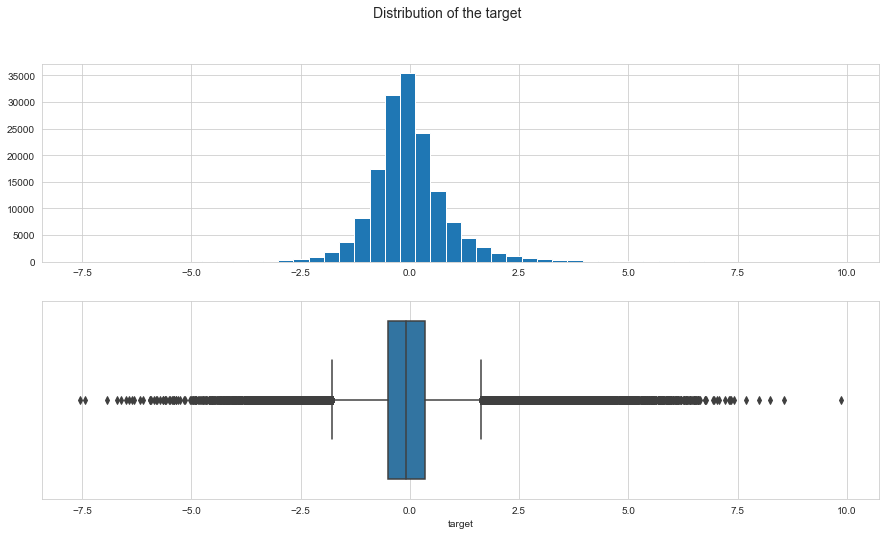

<IPython.core.display.Javascript object>

In [86]:
# Initiate plot
f, axes = plt.subplots(2, 1, figsize=(15, 8))

plt.suptitle("Distribution of the target", size=14)

# Target histogram
sample_df["target"].hist(bins=50, ax=axes[0])

# Target Boxplot
sns.boxplot(x="target", data=sample_df, ax=axes[1])
plt.show()

We don't have outliers above 10 and less than 8 as there are in the full dataset.


### Correlation
Let's see if the target is correlated to the features f_i.

In [87]:
correlation = sample_df[["target"] + features].corr()

<IPython.core.display.Javascript object>

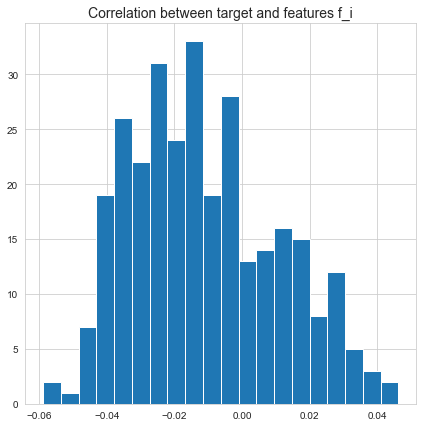

<IPython.core.display.Javascript object>

In [88]:
# Plot correlation values between target and features f_i
plt.figure(figsize=(7, 7))
correlation["target"].iloc[1:].hist(bins=20)
plt.title("Correlation between target and features f_i", size=14)
plt.show()

Correlation values are very low, so it means that target is not linked to features.

Let's see the correlation between the features f_i. As there are 300 features, it is difficult to see all correlations.

In [89]:
def mat_corr(df):
    """
    Function to plot correlation matrix heatmap between columns of a dataframe
    
    Arguments :
    - dataframe df
    
    Display :
    - correlation matrix as heatmap
    """

    # Compute correlation
    corr = df.corr()

    # Mask to display only lower part of the heatmap
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Plot initialization
    f, ax = plt.subplots(figsize=(30, 30))

    # Color mapping
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Heatmap
    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        # vmax=1,
        center=0,
        square=True,
        linewidths=0.5,
        cbar=True,
        # annot=True, # do not display correlation values
    )
    plt.title("Correlation Matrix", size=20)
    plt.show()

<IPython.core.display.Javascript object>

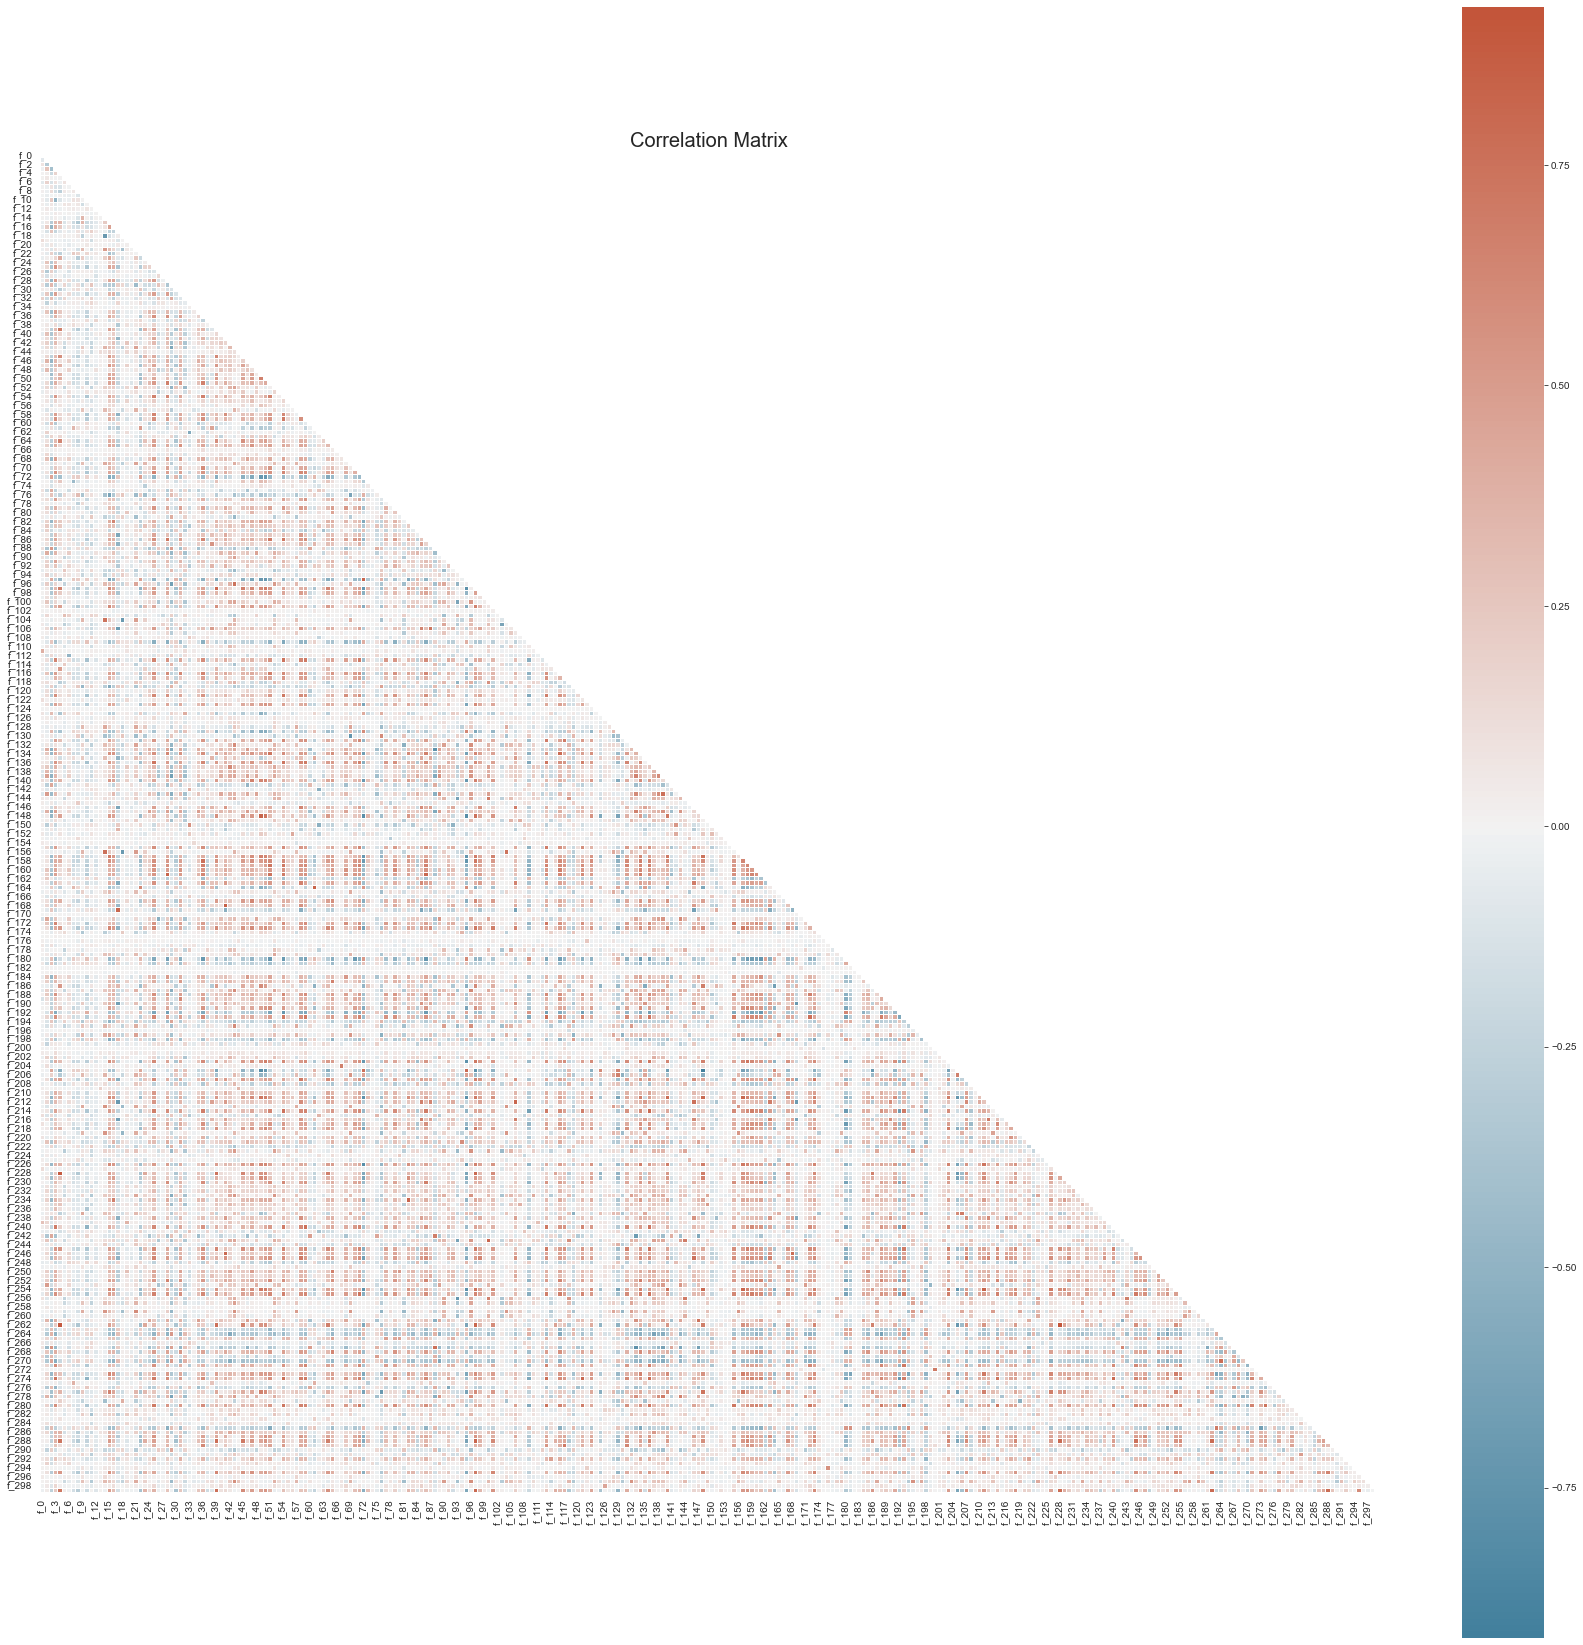

<IPython.core.display.Javascript object>

In [90]:
# Display heatmap
mat_corr(sample_df[features])

Most of correlations are low. 

We are going to see the highest correlations. Generally, it is considered that high correlation is above 0.8.

In [91]:
# Compute correlation matrix with absolute values
corr_matrix = sample_df[features].corr().abs()

# Keep high correlations
high_corr_var = np.where(corr_matrix >= 0.80)

# Get pairs of features with high correlations
high_corr_var = [
    (corr_matrix.columns[x], corr_matrix.columns[y])
    for x, y in zip(*high_corr_var)
    if x != y and x < y
]
high_corr_var

[('f_4', 'f_228'),
 ('f_4', 'f_262'),
 ('f_17', 'f_169'),
 ('f_28', 'f_161'),
 ('f_39', 'f_97'),
 ('f_41', 'f_168'),
 ('f_41', 'f_246'),
 ('f_49', 'f_148'),
 ('f_49', 'f_205'),
 ('f_61', 'f_164'),
 ('f_72', 'f_95'),
 ('f_72', 'f_226'),
 ('f_82', 'f_234'),
 ('f_86', 'f_161'),
 ('f_95', 'f_148'),
 ('f_97', 'f_262'),
 ('f_97', 'f_288'),
 ('f_97', 'f_299'),
 ('f_100', 'f_243'),
 ('f_106', 'f_212'),
 ('f_121', 'f_274'),
 ('f_148', 'f_205'),
 ('f_157', 'f_211'),
 ('f_157', 'f_254'),
 ('f_211', 'f_254'),
 ('f_228', 'f_262'),
 ('f_240', 'f_274')]

<IPython.core.display.Javascript object>

We can see that several features are correlated to more than one feature, such as f_4, f_228, f_41, f_95, f_97...

In [15]:
# Select the lower triangle of the correlation matrix
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))
# k = -1 to remove values on diagonal

<IPython.core.display.Javascript object>

In [93]:
lower

f_0       f_1       f_2       f_3       f_4       f_5       f_6  \
f_0         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
f_1    0.080340       NaN       NaN       NaN       NaN       NaN       NaN   
f_2    0.077651  0.308193       NaN       NaN       NaN       NaN       NaN   
f_3    0.016761  0.266655  0.402208       NaN       NaN       NaN       NaN   
f_4    0.002498  0.023062  0.190986  0.173860       NaN       NaN       NaN   
...         ...       ...       ...       ...       ...       ...       ...   
f_295  0.008314  0.104512  0.306928  0.369551  0.535145  0.009699  0.002146   
f_296  0.034092  0.003732  0.003924  0.006542  0.012047  0.028818  0.022453   
f_297  0.008676  0.026888  0.034401  0.032219  0.005371  0.192526  0.057937   
f_298  0.003163  0.054242  0.093006  0.155074  0.015210  0.010884  0.003131   
f_299  0.025833  0.034509  0.268148  0.229796  0.717434  0.022934  0.013317   

            f_7       f_8       f_9  ...     f_290     f_291     f_292  \
f_0         NaN       NaN       NaN  ...       NaN       NaN       NaN   
f_1         NaN       NaN       NaN  ...       NaN       NaN       NaN   
f_2         NaN       NaN       NaN  ...       NaN       NaN       NaN   
f_3         NaN       NaN       NaN  ...       NaN       NaN       NaN   
f_4         NaN       NaN       NaN  ...       NaN       NaN       NaN   
...         ...       ...       ...  ...       ...       ...       ...   
f_295  0.175664  0.327852  0.077917  ...  0.107571  0.118599  0.230016   
f_296  0.005458  0.022693  0.089613  ...  0.187911  0.020867  0.010887   
f_297  0.001315  0.114351  0.272527  ...  0.317000  0.298905  0.112833   
f_298  0.012641  0.021998  0.009558  ...  0.055165  0.025843  0.063290   
f_299  0.157668  0.296350  0.007035  ...  0.010255  0.043949  0.203527   

          f_293     f_294     f_295     f_296     f_297     f_298  f_299  
f_0         NaN       NaN       NaN       NaN       NaN       NaN    NaN  
f_1         NaN       NaN       NaN       NaN       NaN       NaN    NaN  
f_2         NaN       NaN       NaN       NaN       NaN       NaN    NaN  
f_3         NaN       NaN       NaN       NaN       NaN       NaN    NaN  
f_4         NaN       NaN       NaN       NaN       NaN       NaN    NaN  
...         ...       ...       ...       ...       ...       ...    ...  
f_295  0.044341  0.030154       NaN       NaN       NaN       NaN    NaN  
f_296  0.004426  0.022381  0.023850       NaN       NaN       NaN    NaN  
f_297  0.001112  0.202802  0.095464  0.103171       NaN       NaN    NaN  
f_298  0.008622  0.001215  0.049705  0.015288  0.030980       NaN    NaN  
f_299  0.027230  0.002810  0.598366  0.011205  0.040726  0.003108    NaN  

[300 rows x 300 columns]

<IPython.core.display.Javascript object>

In [16]:
# Select the upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# k = 1 to remove values on diagonal

<IPython.core.display.Javascript object>

In [95]:
upper

f_0      f_1       f_2       f_3       f_4       f_5       f_6  \
f_0    NaN  0.08034  0.077651  0.016761  0.002498  0.008232  0.069825   
f_1    NaN      NaN  0.308193  0.266655  0.023062  0.056259  0.179982   
f_2    NaN      NaN       NaN  0.402208  0.190986  0.000615  0.130356   
f_3    NaN      NaN       NaN       NaN  0.173860  0.005697  0.095658   
f_4    NaN      NaN       NaN       NaN       NaN  0.000482  0.028708   
...    ...      ...       ...       ...       ...       ...       ...   
f_295  NaN      NaN       NaN       NaN       NaN       NaN       NaN   
f_296  NaN      NaN       NaN       NaN       NaN       NaN       NaN   
f_297  NaN      NaN       NaN       NaN       NaN       NaN       NaN   
f_298  NaN      NaN       NaN       NaN       NaN       NaN       NaN   
f_299  NaN      NaN       NaN       NaN       NaN       NaN       NaN   

            f_7       f_8       f_9  ...     f_290     f_291     f_292  \
f_0    0.002265  0.015165  0.007302  ...  0.025271  0.006614  0.046703   
f_1    0.033463  0.025831  0.042427  ...  0.248299  0.029436  0.124071   
f_2    0.079581  0.122162  0.009768  ...  0.194634  0.023163  0.163836   
f_3    0.125312  0.155202  0.008483  ...  0.173530  0.017960  0.258542   
f_4    0.114562  0.280519  0.001236  ...  0.003259  0.079482  0.087543   
...         ...       ...       ...  ...       ...       ...       ...   
f_295       NaN       NaN       NaN  ...       NaN       NaN       NaN   
f_296       NaN       NaN       NaN  ...       NaN       NaN       NaN   
f_297       NaN       NaN       NaN  ...       NaN       NaN       NaN   
f_298       NaN       NaN       NaN  ...       NaN       NaN       NaN   
f_299       NaN       NaN       NaN  ...       NaN       NaN       NaN   

          f_293     f_294     f_295     f_296     f_297     f_298     f_299  
f_0    0.009470  0.007777  0.008314  0.034092  0.008676  0.003163  0.025833  
f_1    0.182843  0.008788  0.104512  0.003732  0.026888  0.054242  0.034509  
f_2    0.158278  0.008086  0.306928  0.003924  0.034401  0.093006  0.268148  
f_3    0.085105  0.002998  0.369551  0.006542  0.032219  0.155074  0.229796  
f_4    0.018189  0.000850  0.535145  0.012047  0.005371  0.015210  0.717434  
...         ...       ...       ...       ...       ...       ...       ...  
f_295       NaN       NaN       NaN  0.023850  0.095464  0.049705  0.598366  
f_296       NaN       NaN       NaN       NaN  0.103171  0.015288  0.011205  
f_297       NaN       NaN       NaN       NaN       NaN  0.030980  0.040726  
f_298       NaN       NaN       NaN       NaN       NaN       NaN  0.003108  
f_299       NaN       NaN       NaN       NaN       NaN       NaN       NaN  

[300 rows x 300 columns]

<IPython.core.display.Javascript object>

In [96]:
# Find features with correlation greater than 0.80 in lower matrix
to_drop_low = [column for column in lower.columns if any(lower[column] >= 0.8)]
print("{} features with high correlation (>=0.8)".format(len(to_drop_low)))

20 features with high correlation (>=0.8)


<IPython.core.display.Javascript object>

In [18]:
# Find features with correlation greater than 0.80 in upper matrix
to_drop_up = [column for column in upper.columns if any(upper[column] >= 0.8)]
print("{} features with high correlation (>=0.8)".format(len(to_drop_up)))

20 features with high correlation (>=0.8)


<IPython.core.display.Javascript object>

In [98]:
# Let's see which features are both in drop lists
feat_common = [f for f in to_drop_low if f in to_drop_up]
feat_common

['f_95', 'f_97', 'f_148', 'f_211', 'f_228']

<IPython.core.display.Javascript object>

There are 5 features in common for the drop lists. Otherwise, 15 features are different considering upper or lower part of the matrix. Maybe this could have an incidence for the modelisation. 

Let's have a look of their distribution.

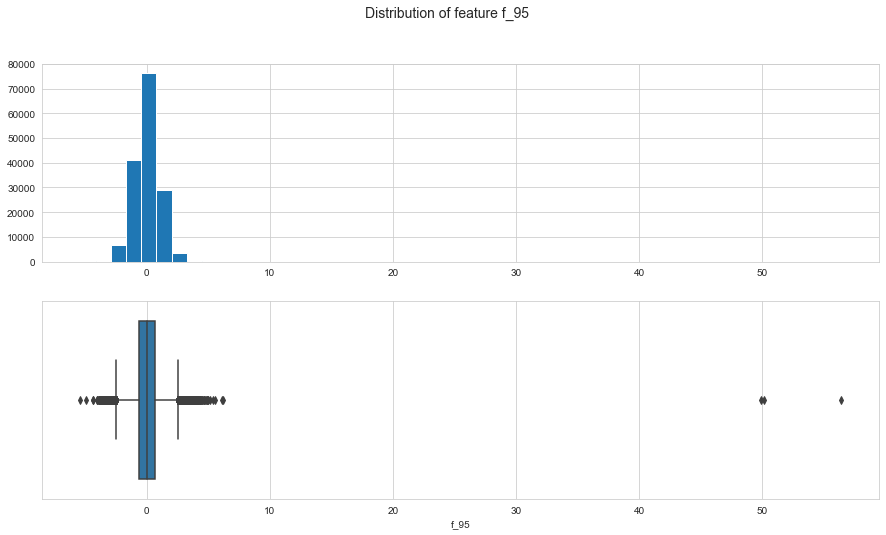

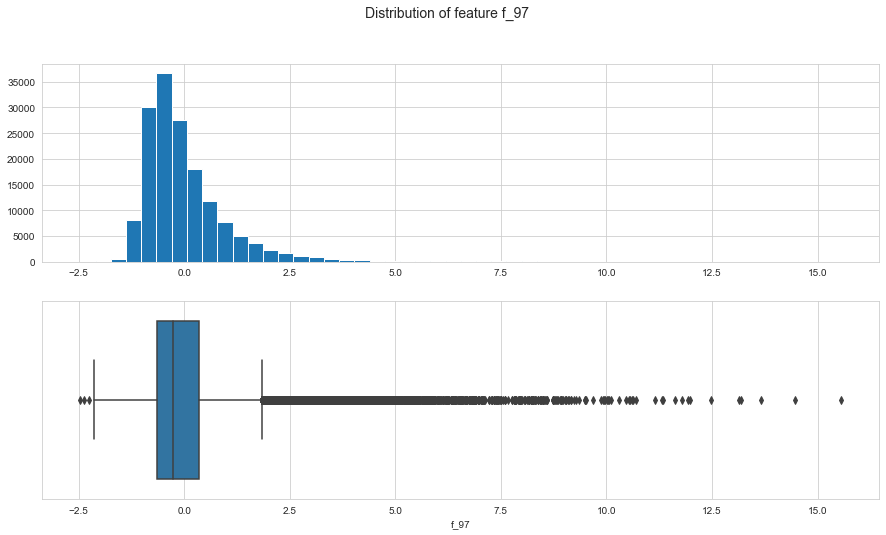

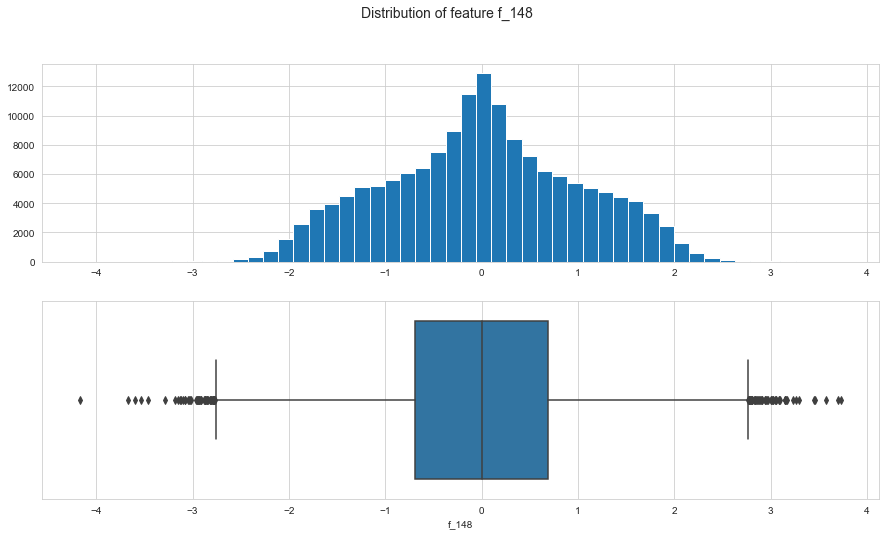

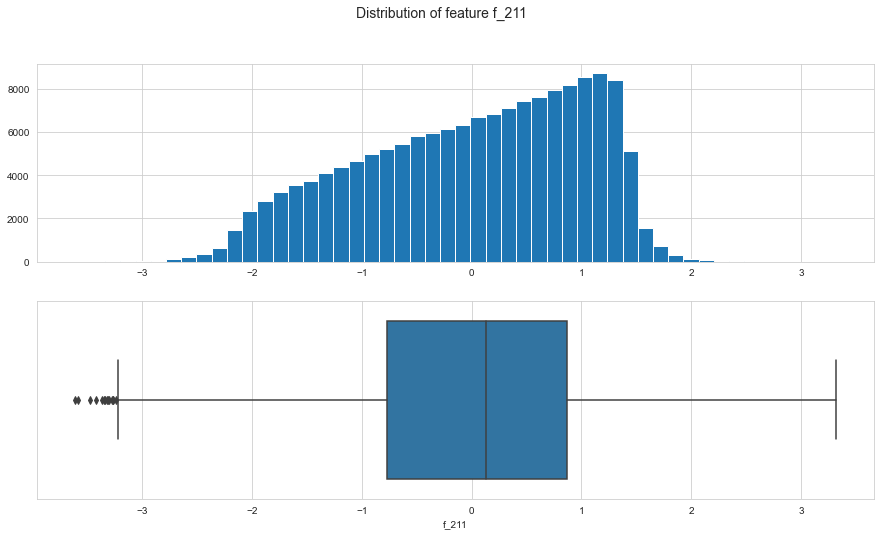

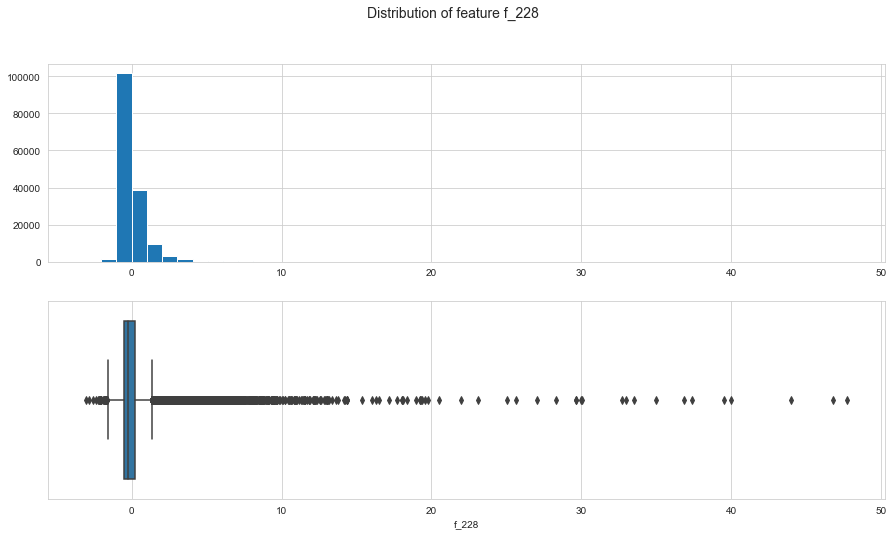

<IPython.core.display.Javascript object>

In [22]:
# Plot histograms and boxplot of these features f_
for f in feat_common:
    # df["f_{}".format(f)].hist(bins=50)
    # Initiate plot
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    plt.suptitle("Distribution of feature {}".format(f), size=14)
    # Target histogram
    sample_df["{}".format(f)].hist(bins=50, ax=axes[0])

    # Target Boxplot
    sns.boxplot(x="{}".format(f), data=sample_df, ax=axes[1])
    plt.show()

Distribution are not all centered in zero. Many outliers.

So we are going to compare 2 possibilities : upper matrix and lower matrix.

In [23]:
# Drop these features
sample_df_up = sample_df.drop(to_drop_up, axis=1)
sample_df_low = sample_df.drop(to_drop_low, axis=1)

<IPython.core.display.Javascript object>

In [24]:
print("sample_df_up shape : ", sample_df_up.shape)
print("sample_df_low shape : ", sample_df_low.shape)

sample_df_up shape :  (157070, 284)
sample_df_low shape :  (157070, 284)


<IPython.core.display.Javascript object>

In [25]:
# Remove others columns that are not "features"
others = ["row_id", "time_id", "investment_id", "target"]

features_up = list(sample_df_up.columns)
features_low = list(sample_df_low.columns)

for x in others:
    features_up.remove(x)
    features_low.remove(x)

<IPython.core.display.Javascript object>

In [26]:
len(features_up)

280

<IPython.core.display.Javascript object>

In [27]:
len(features_low)

280

<IPython.core.display.Javascript object>

Correlated features have been removed.

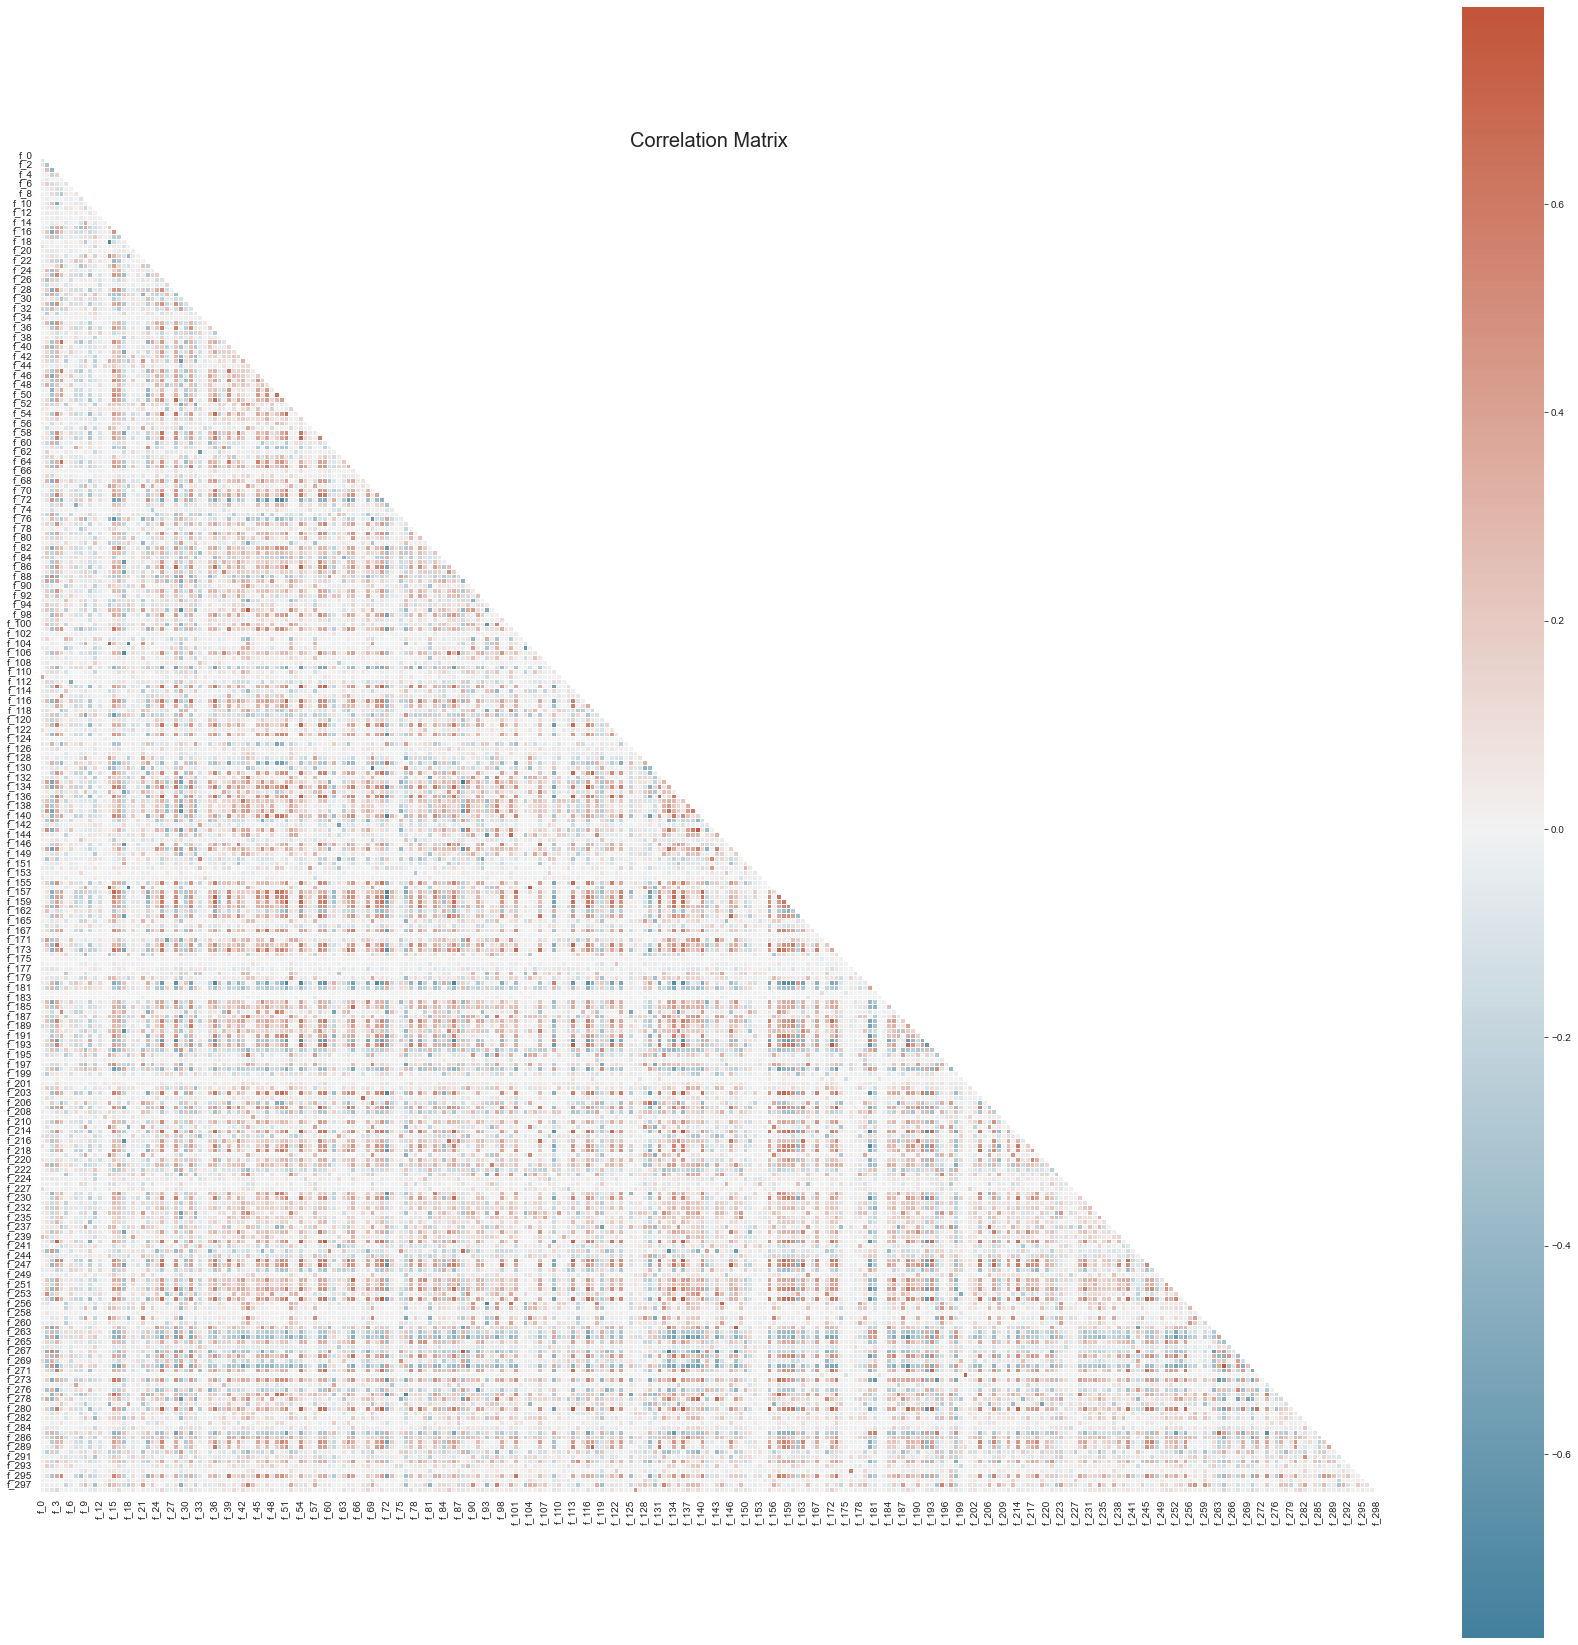

<IPython.core.display.Javascript object>

In [104]:
mat_corr(sample_df[features_up])

### Split data
We are going to split data now in order that the test part is not influenced by operations done on the train part.

In [29]:
# Define X and y
X = sample_df[features].values
X_up = sample_df_up.drop(others, axis=1).values
X_low = sample_df_low.drop(others, axis=1).values
y = sample_df_up["target"].values

<IPython.core.display.Javascript object>

In [30]:
print("X shape : ", X.shape)
print("X_up shape : ", X_up.shape)
print("X_low shape : ", X_low.shape)
print("y shape : ", y.shape)

X shape :  (157070, 300)
X_up shape :  (157070, 280)
X_low shape :  (157070, 280)
y shape :  (157070,)


<IPython.core.display.Javascript object>

The test part has to be the end of the dataset as it is "the future" observations (remmerber that our data are ordered by time_id).

In [31]:
# Split data
X_train = X[:140000]
X_test = X[140000:]

X_up_train = X_up[:140000]
X_up_test = X_up[140000:]

X_low_train = X_low[:140000]
X_low_test = X_low[140000:]

y_train = y[:140000]
y_test = y[140000:]

print("X_train shape : ", X_train.shape)
print("X_test shape : ", X_test.shape)
print("X_up_train shape : ", X_up_train.shape)
print("X_up_test shape : ", X_up_test.shape)
print("X_low_train shape : ", X_low_train.shape)
print("X_low_test shape : ", X_low_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)

X_train shape :  (140000, 300)
X_test shape :  (17070, 300)
X_up_train shape :  (140000, 280)
X_up_test shape :  (17070, 280)
X_low_train shape :  (140000, 280)
X_low_test shape :  (17070, 280)
y_train shape :  (140000,)
y_test shape :  (17070,)


<IPython.core.display.Javascript object>

In [32]:
perc_test = round(len(X_up_test) / len(X_up) * 100, 1)
print("Percent of data in test set : {}%".format(perc_test))

Percent of data in test set : 10.9%


<IPython.core.display.Javascript object>

In [33]:
# Save data
joblib.dump(X_train, "./Data/X_train.joblib")
joblib.dump(X_test, "./Data/X_test.joblib")
joblib.dump(X_up_train, "./Data/X_up_train.joblib")
joblib.dump(X_low_train, "./Data/X_low_train.joblib")
joblib.dump(X_up_test, "./Data/X_up_test.joblib")
joblib.dump(X_low_test, "./Data/X_low_test.joblib")
joblib.dump(y_train, "./Data/y_train.joblib")
joblib.dump(y_test, "./Data/y_test.joblib")

['./Data/y_test.joblib']

<IPython.core.display.Javascript object>

In [2]:
# Upload data
X_train = joblib.load("./Data/X_train.joblib")
X_test = joblib.load("./Data/X_test.joblib")
X_up_train = joblib.load("./Data/X_up_train.joblib")
X_low_train = joblib.load("./Data/X_low_train.joblib")
X_up_test = joblib.load("./Data/X_up_test.joblib")
X_low_test = joblib.load("./Data/X_low_test.joblib")
y_train = joblib.load("./Data/y_train.joblib")
y_test = joblib.load("./Data/y_test.joblib")

<IPython.core.display.Javascript object>

In [5]:
X_low_test.shape

(17070, 280)

<IPython.core.display.Javascript object>

In [111]:
sample_df.loc[140000]

row_id           1116_3430
time_id               1116
investment_id         3430
target            0.038822
f_0               0.500455
                   ...    
f_295            -0.315079
f_296              1.76854
f_297            -0.767893
f_298            -1.684648
f_299            -0.147932
Name: 140000, Length: 304, dtype: object

<IPython.core.display.Javascript object>

Test set contains data with time_id above 1116.

In [112]:
sample_df.loc[139999]

row_id           1116_3411
time_id               1116
investment_id         3411
target           -0.509043
f_0               0.243152
                   ...    
f_295             0.433784
f_296             0.698854
f_297            -0.566678
f_298             1.151607
f_299             0.062957
Name: 139999, Length: 304, dtype: object

<IPython.core.display.Javascript object>

In [113]:
sample_df.loc[140001]

row_id           1116_3482
time_id               1116
investment_id         3482
target           -1.803552
f_0               0.908216
                   ...    
f_295             -0.54032
f_296             0.389126
f_297             1.701206
f_298             1.556026
f_299            -0.269335
Name: 140001, Length: 304, dtype: object

<IPython.core.display.Javascript object>

## PCA
We are going to consider PCA in order to decrease the number of features.

We are going to compare normalized data and unnormalized data. As mentioned above, we are going to use Robust Scaler for normalization.

#### Scale

In [3]:
# X
robust_scal = RobustScaler().fit(X_train)
X_scaled = robust_scal.transform(X_train)
X_scaled.shape

(140000, 300)

<IPython.core.display.Javascript object>

In [4]:
# Up
robust_scal_up = RobustScaler().fit(X_up_train)
X_up_scaled = robust_scal_up.transform(X_up_train)
X_up_scaled.shape

(140000, 280)

<IPython.core.display.Javascript object>

In [5]:
# Low
robust_scal_low = RobustScaler().fit(X_low_train)
X_low_scaled = robust_scal_low.transform(X_low_train)
X_low_scaled.shape

(140000, 280)

<IPython.core.display.Javascript object>

#### PCA

In [37]:
# PCA X
pca = PCA(random_state=0)
pca.fit(X_train)

PCA(random_state=0)

<IPython.core.display.Javascript object>

In [38]:
def display_scree_plot(pca, data):

    """ Fonction pour représenter visualiser l'éboulis des valeurs propres de la pca
        
    - Arguments :
        - pca : modèle pcq entrainé
    
    - Affiche :
        - un barplot pour chaque composante de la pcs
        - la somme cumulée de l'inertie en pourcentage 
        (= variance expliquée par la pca)
    """

    plt.figure(figsize=(12, 8))
    scree = pca.explained_variance_ratio_ * 100

    # Barplot pour chaque composante
    plt.bar(np.arange(len(scree)) + 1, scree)

    # Somme cumulée
    plt.plot(np.arange(len(scree)) + 1, scree.cumsum(), c="red", marker="o")

    plt.xlabel("rank of the axis of inertia", size=13)
    plt.ylabel("Inertie percent", size=13)
    plt.title("Eigenvalues scree of pca for {}".format(data), size=14)
    plt.show(block=False)

<IPython.core.display.Javascript object>

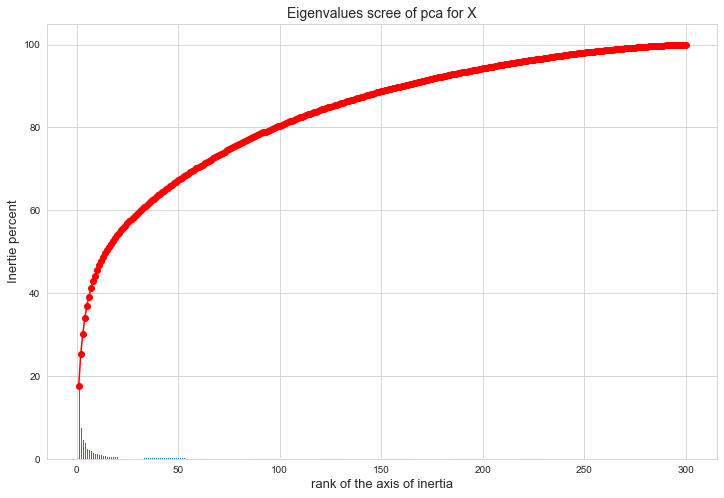

<IPython.core.display.Javascript object>

In [39]:
data = "X"
display_scree_plot(pca, data)

In [6]:
# PCA 0.85 X
pca_85 = PCA(n_components=0.85, random_state=0)
pca_85.fit(X_train)
X_pca85 = pca_85.transform(X_train)
X_pca85.shape

(140000, 125)

<IPython.core.display.Javascript object>

The features number decreases of 58%.

In [43]:
# PCA X_up
pca_up = PCA(random_state=0)
pca_up.fit(X_up_train)

PCA(random_state=0)

<IPython.core.display.Javascript object>

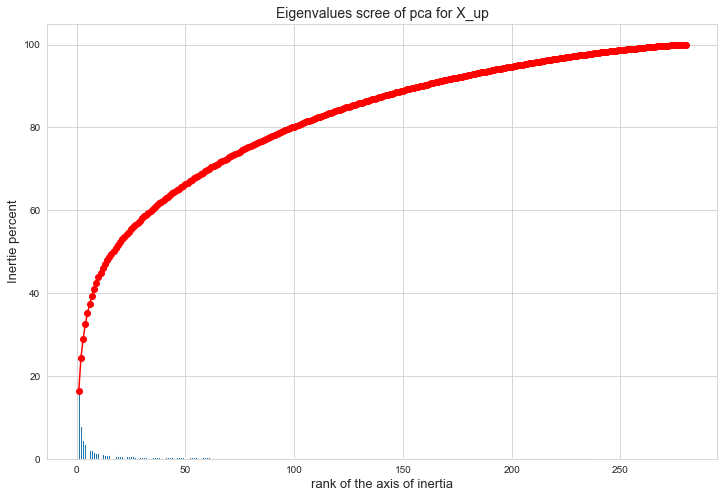

<IPython.core.display.Javascript object>

In [44]:
data = "X_up"
display_scree_plot(pca_up, data)

Let's keep 85% of explained variance.

In [7]:
# PCA 0.85 X_up
pca_up_85 = PCA(n_components=0.85, random_state=0)
pca_up_85.fit(X_up_train)
X_up_pca85 = pca_up_85.transform(X_up_train)
X_up_pca85.shape

(140000, 126)

<IPython.core.display.Javascript object>

The features number decreases of 55%.

In [46]:
nb_comp_up_85 = np.where(pca_up_85.explained_variance_ratio_.cumsum() >= 0.85)[0][0] + 1
nb_comp_up_85

126

<IPython.core.display.Javascript object>

In [47]:
# PCA X_low
pca_low = PCA(random_state=0)
pca_low.fit(X_low_train)

PCA(random_state=0)

<IPython.core.display.Javascript object>

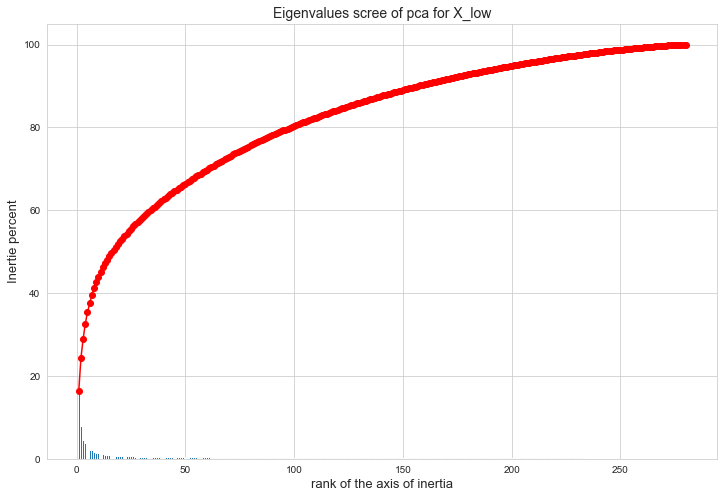

<IPython.core.display.Javascript object>

In [48]:
data = "X_low"
display_scree_plot(pca_low, data)

In [8]:
# PCA 0.85 X_low
pca_low_85 = PCA(n_components=0.85, random_state=0)
pca_low_85.fit(X_low_train)
X_low_pca85 = pca_low_85.transform(X_low_train)
X_low_pca85.shape

(140000, 125)

<IPython.core.display.Javascript object>

The features number decreases of 55.4%.

In [50]:
# PCA X_scaled
pca_scal = PCA(random_state=0)
pca_scal.fit(X_scaled)

PCA(random_state=0)

<IPython.core.display.Javascript object>

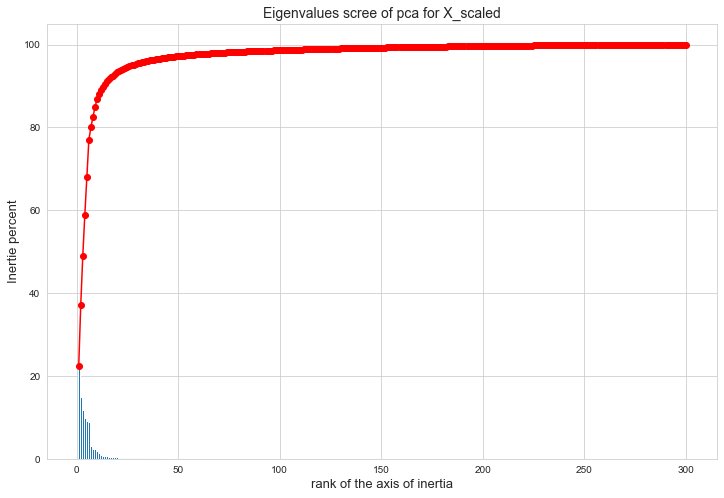

<IPython.core.display.Javascript object>

In [51]:
data = "X_scaled"
display_scree_plot(pca_scal, data)

In [9]:
# PCA 0.85 X_scaled
pca_scal_85 = PCA(n_components=0.85, random_state=0)
pca_scal_85.fit(X_scaled)
X_scal_pca85 = pca_scal_85.transform(X_scaled)
X_scal_pca85.shape

(140000, 10)

<IPython.core.display.Javascript object>

The features number decreases of 96.7% !

In [14]:
# PCA 0.90 X_scaled
pca_scal_90 = PCA(n_components=0.90, random_state=0)
pca_scal_90.fit(X_scaled)
X_scal_pca90 = pca_scal_90.transform(X_scaled)
X_scal_pca90.shape

(140000, 14)

<IPython.core.display.Javascript object>

In [53]:
# PCA X_up_scaled
pca_up_scal = PCA(random_state=0)
pca_up_scal.fit(X_up_scaled)

PCA(random_state=0)

<IPython.core.display.Javascript object>

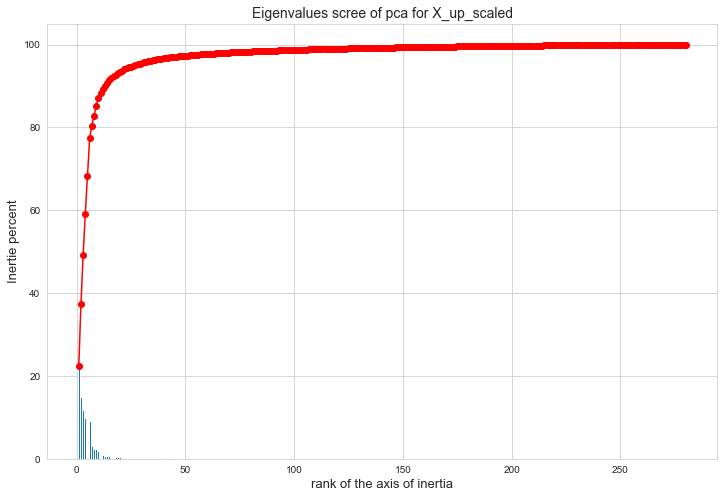

<IPython.core.display.Javascript object>

In [54]:
data = "X_up_scaled"
display_scree_plot(pca_up_scal, data)

In [10]:
# PCA 0.85 X_up_scaled
pca_up_scal_85 = PCA(n_components=0.85, random_state=0)
pca_up_scal_85.fit(X_up_scaled)
X_up_scal_pca85 = pca_up_scal_85.transform(X_up_scaled)
X_up_scal_pca85.shape

(140000, 9)

<IPython.core.display.Javascript object>

The features number decreases of 96.8% !

In [16]:
# PCA 0.9 X_up_scaled
pca_up_scal_90 = PCA(n_components=0.9, random_state=0)
pca_up_scal_90.fit(X_up_scaled)
X_up_scal_pca90 = pca_up_scal_90.transform(X_up_scaled)
X_up_scal_pca90.shape

(140000, 13)

<IPython.core.display.Javascript object>

The features number decreases of 95.4%.

In [57]:
# PCA X_low_scaled
pca_low_scal = PCA(random_state=0)
pca_low_scal.fit(X_low_scaled)

PCA(random_state=0)

<IPython.core.display.Javascript object>

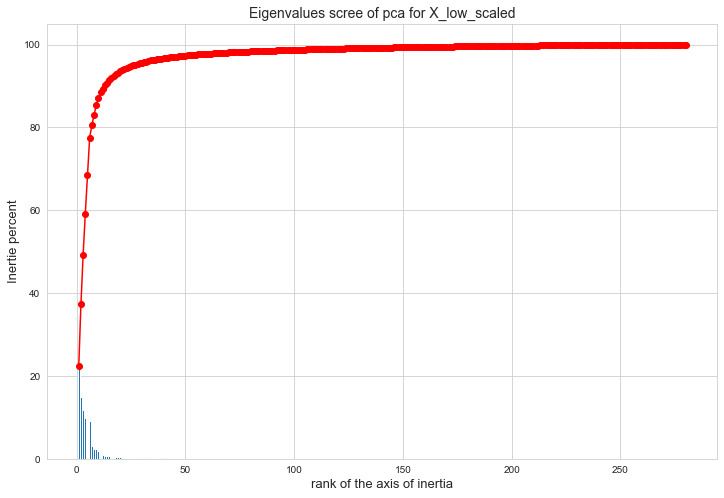

<IPython.core.display.Javascript object>

In [58]:
data = "X_low_scaled"
display_scree_plot(pca_low_scal, data)

In [11]:
# PCA 0.85 X_low_scaled
pca_low_scal_85 = PCA(n_components=0.85, random_state=0)
pca_low_scal_85.fit(X_low_scaled)
X_low_scal_pca85 = pca_low_scal_85.transform(X_low_scaled)
X_low_scal_pca85.shape

(140000, 9)

<IPython.core.display.Javascript object>

The features number decreases of 96.8% !

In [18]:
# PCA 0.9 X_low_scaled
pca_low_scal_90 = PCA(n_components=0.9, random_state=0)
pca_low_scal_90.fit(X_low_scaled)
X_low_scal_pca90 = pca_low_scal_90.transform(X_low_scaled)
X_low_scal_pca90.shape

(140000, 13)

<IPython.core.display.Javascript object>

### 1st Try with Linear Regression
We are going to see on a simple linear regression how models perform with our different data (PCA, up, down, scaled..).

In [37]:
def display_learning_curve(model, X_train, y_train, name_model, name_X):

    N, train_score, val_score = learning_curve(
        model,
        X_train,
        y_train,
        cv=n_folds,
        scoring="neg_root_mean_squared_error",
        train_sizes=np.linspace(0.1, 1, 10),
    )

    # Plot learning-curve
    plt.figure(figsize=(6, 6))
    plt.plot(N, -train_score.mean(axis=1), label="train_score")
    plt.plot(N, -val_score.mean(axis=1), label="validation_score")
    plt.xlabel("Dataset size", size=14)
    plt.ylabel("Mean RMSE", size=14)
    # plt.xlim([50,680])
    # plt.ylim([y_min, y_max])

    plt.title("Learning curve for {} with {}".format(name_model, name_X), size=14)
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>

In [38]:
def display_learning_curve(model, cv_split, X_train, y_train, name_model, name_X):

    N, train_score, val_score = learning_curve(
        model,
        X_train,
        y_train,
        cv=cv_split,
        scoring="neg_root_mean_squared_error",
        #train_sizes=np.linspace(0.1, 1, 10),
    )

    # Plot learning-curve
    plt.figure(figsize=(6, 6))
    plt.plot(N, -train_score.mean(axis=1), label="train_score")
    plt.plot(N, -val_score.mean(axis=1), label="validation_score")
    plt.xlabel("Dataset size", size=14)
    plt.ylabel("Mean RMSE", size=14)
    # plt.xlim([50,680])
    # plt.ylim([y_min, y_max])

    plt.title("Learning curve for {} with {}".format(name_model, name_X), size=14)
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>

In [106]:
def my_scorer(X, y):
    pearson = pearsonr(X, y)[0]
    return pearson


my_pearson = make_scorer(my_scorer, greater_is_better=True)

scoring = {
    "neg_root_mean_squared_error": "neg_root_mean_squared_error",
    "neg_mean_absolute_error": "neg_mean_absolute_error",
    "my_pearson": my_pearson,
}

<IPython.core.display.Javascript object>

In [105]:
def cross_val(model, X_train, y_train, name_model, name_X):

    """ Function to do cross-validation on a model and get scores in
    a dataframe 
        
    - Arguments :
        - model : model to test
        - X_train : X data 
        - y_train : X data
        - name_model : name of the model (string)
        - name_X : name given to the X data (string)
    
    - Return :
        - dataframe with name_model, name_X and scoring : RMSE, MAE, R2
    """

    # Cross validation
    scores = cross_validate(model, X_train, y_train, cv=n_folds, scoring=scoring,)

    # Get mean scores
    RMSE = -scores["test_neg_root_mean_squared_error"].mean()
    MAE = -scores["test_neg_mean_absolute_error"].mean()
    pearson = scores["test_my_pearson"].mean()

    # Dataframe creation for results
    df_model = pd.DataFrame(
        [[name_model, name_X, RMSE, MAE, pearson]],
        columns=["model", "X_data", "RMSE", "MAE", "Pearson_coef"],
    )

    return df_model

<IPython.core.display.Javascript object>

In [39]:
# Dico of X_data
dico_X = {
    "X_train": X_train,
    "X_scaled": X_scaled,
    "X_pca85": X_pca85,
    "X_scal_pca85": X_scal_pca85,
    "X_up_pca85": X_up_pca85,
    "X_up_scal_pca85": X_up_scal_pca85,
    "X_low_pca85": X_low_pca85,
    "X_low_scal_pca85": X_low_scal_pca85,
}

dico_X_scaled = {
    "X_scaled": X_scaled,
    "X_scal_pca85": X_scal_pca85,
    "X_up_scal_pca85": X_up_scal_pca85,
    "X_low_scal_pca85": X_low_scal_pca85,
}

small_dico_X = {
    "X_scal_pca85": X_scal_pca85,
    "X_up_scal_pca85": X_up_scal_pca85,
    "X_low_scal_pca85": X_low_scal_pca85,
}

small_dico_X_bis = {
    "X_pca85": X_pca85,
    "X_up_pca85": X_up_pca85,
    "X_low_pca85": X_low_pca85,
}

<IPython.core.display.Javascript object>

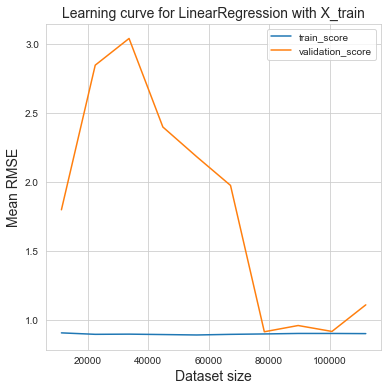

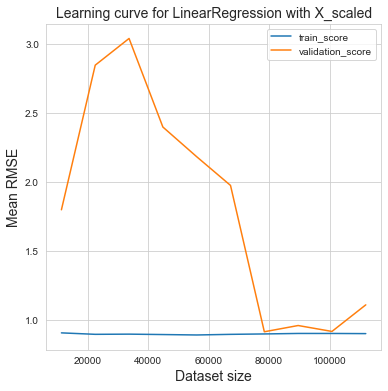

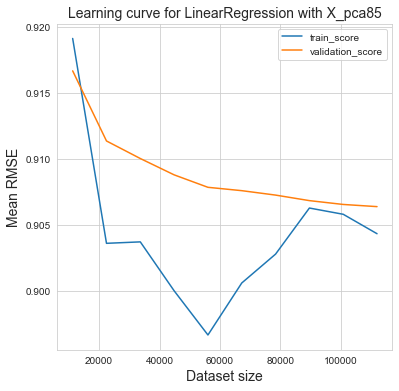

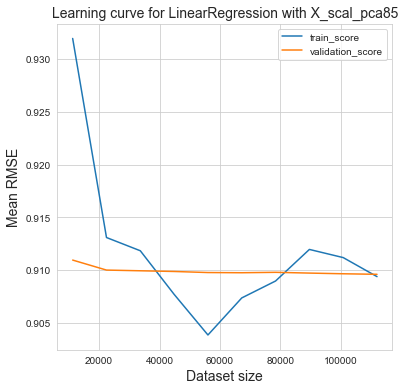

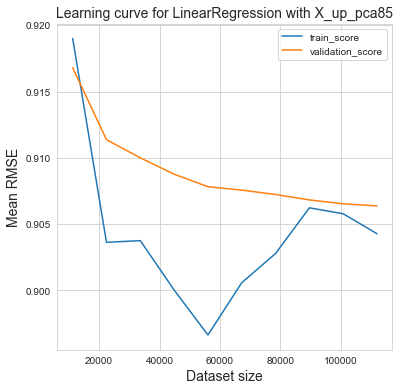

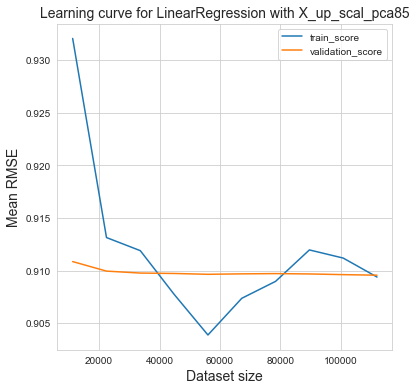

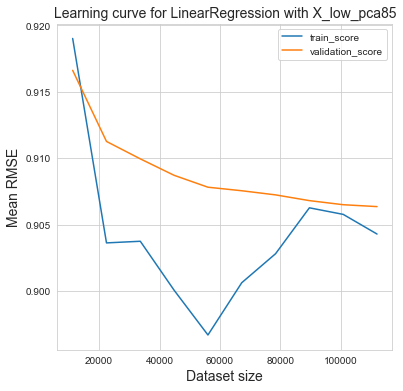

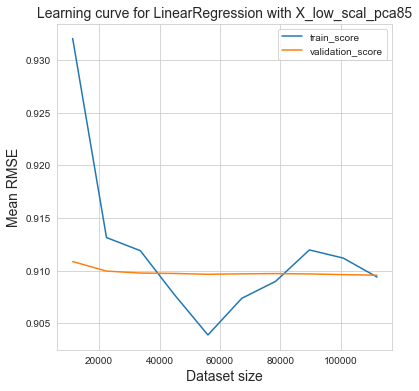

CPU times: user 5min 23s, sys: 45.4 s, total: 6min 8s
Wall time: 2min 6s


model            X_data      RMSE       MAE Pearson_coef
0  LinearRegression           X_train  1.110934  0.629592     0.088367
0  LinearRegression          X_scaled  1.110937  0.629592     0.088367
0  LinearRegression           X_pca85  0.906406  0.626232     0.113349
0  LinearRegression      X_scal_pca85  0.909609  0.628625      0.07427
0  LinearRegression        X_up_pca85  0.906378  0.626211     0.113574
0  LinearRegression   X_up_scal_pca85  0.909575  0.628586     0.074764
0  LinearRegression       X_low_pca85  0.906366  0.626175     0.113573
0  LinearRegression  X_low_scal_pca85  0.909572  0.628583     0.074812

<IPython.core.display.Javascript object>

In [29]:
%%time

model = LinearRegression()
n_folds = 5

# Dataframe for results
lr_results = pd.DataFrame(columns=[
            "model", "X_data", "RMSE", "MAE", "Pearson_coef",
        ])

# for each kind of X data
for name_X, X_data in dico_X.items() :
    
    # Learning curve
    display_learning_curve(model, X_data, y_train, "LinearRegression", name_X)
                           
    # Get results
    df_lr = cross_val(model, X_data, y_train, "LinearRegression", name_X)
    lr_results = pd.concat([lr_results, df_lr], axis = 0)

lr_results

In [34]:
lr_results = lr_results.reset_index(drop=True)
lr_results.sort_values(by = "RMSE")

model            X_data      RMSE       MAE Pearson_coef
6  LinearRegression       X_low_pca85  0.906366  0.626175     0.113573
4  LinearRegression        X_up_pca85  0.906378  0.626211     0.113574
2  LinearRegression           X_pca85  0.906406  0.626232     0.113349
7  LinearRegression  X_low_scal_pca85  0.909572  0.628583     0.074812
5  LinearRegression   X_up_scal_pca85  0.909575  0.628586     0.074764
3  LinearRegression      X_scal_pca85  0.909609  0.628625      0.07427
0  LinearRegression           X_train  1.110934  0.629592     0.088367
1  LinearRegression          X_scaled  1.110937  0.629592     0.088367

<IPython.core.display.Javascript object>

In [35]:
lr_results.sort_values(by = "MAE")

model            X_data      RMSE       MAE Pearson_coef
6  LinearRegression       X_low_pca85  0.906366  0.626175     0.113573
4  LinearRegression        X_up_pca85  0.906378  0.626211     0.113574
2  LinearRegression           X_pca85  0.906406  0.626232     0.113349
7  LinearRegression  X_low_scal_pca85  0.909572  0.628583     0.074812
5  LinearRegression   X_up_scal_pca85  0.909575  0.628586     0.074764
3  LinearRegression      X_scal_pca85  0.909609  0.628625      0.07427
0  LinearRegression           X_train  1.110934  0.629592     0.088367
1  LinearRegression          X_scaled  1.110937  0.629592     0.088367

<IPython.core.display.Javascript object>

In [37]:
lr_results.sort_values(by = "Pearson_coef", ascending=False)

model            X_data      RMSE       MAE Pearson_coef
4  LinearRegression        X_up_pca85  0.906378  0.626211     0.113574
6  LinearRegression       X_low_pca85  0.906366  0.626175     0.113573
2  LinearRegression           X_pca85  0.906406  0.626232     0.113349
1  LinearRegression          X_scaled  1.110937  0.629592     0.088367
0  LinearRegression           X_train  1.110934  0.629592     0.088367
7  LinearRegression  X_low_scal_pca85  0.909572  0.628583     0.074812
5  LinearRegression   X_up_scal_pca85  0.909575  0.628586     0.074764
3  LinearRegression      X_scal_pca85  0.909609  0.628625      0.07427

<IPython.core.display.Javascript object>

Metrics are close to each other.
We can see that top3 is the same for each metric.

Let's see if we are increasing pca explained variance on scaled data how the metrics evolve.

In [38]:
small_dico_X_pca90 = {
    "X_scal_pca90": X_scal_pca90,
    "X_up_scal_pca90": X_up_scal_pca90,
    "X_low_scal_pca90": X_low_scal_pca90,
}

<IPython.core.display.Javascript object>

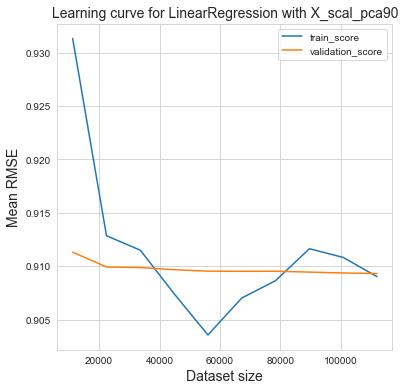

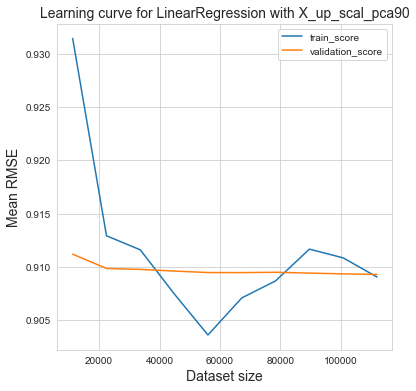

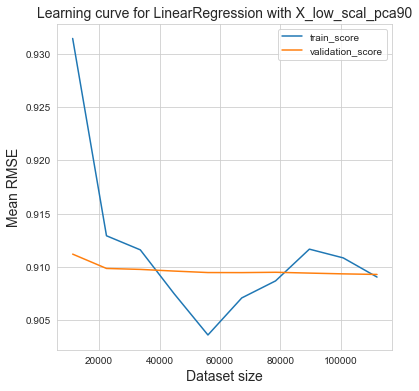

CPU times: user 8.9 s, sys: 4.18 s, total: 13.1 s
Wall time: 4.11 s


model            X_data      RMSE       MAE Pearson_coef
0  LinearRegression      X_scal_pca90   0.90931  0.628518     0.078147
1  LinearRegression   X_up_scal_pca90  0.909287  0.628533     0.078471
2  LinearRegression  X_low_scal_pca90  0.909279  0.628529     0.078577

<IPython.core.display.Javascript object>

In [39]:
%%time

model = LinearRegression()
n_folds = 5

# Dataframe for results
lr_results_pca90 = pd.DataFrame(columns=[
            "model", "X_data", "RMSE", "MAE", "Pearson_coef",
        ])

# for each kind of X data
for name_X, X_data in small_dico_X_pca90.items() :
    
    # Learning curve
    display_learning_curve(model, X_data, y_train, "LinearRegression", name_X)
                           
    # Get results
    df_lr = cross_val(model, X_data, y_train, "LinearRegression", name_X)
    lr_results_pca90 = pd.concat([lr_results_pca90, df_lr], axis = 0).reset_index(drop=True)

lr_results_pca90

Metrics are not increasing very much.

Let's try with ElasticNet, data must be scaled.

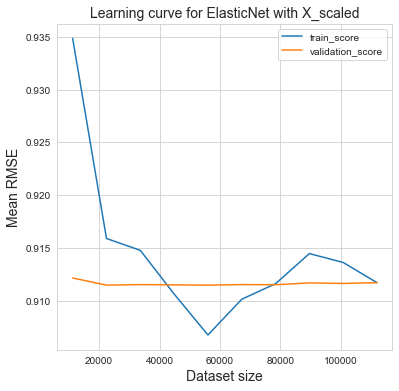

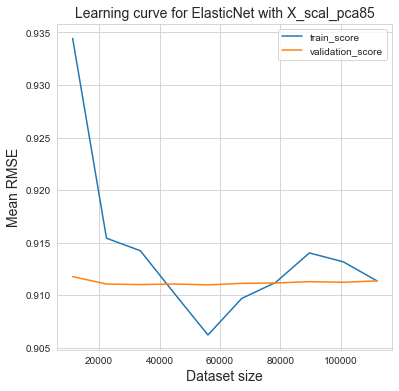

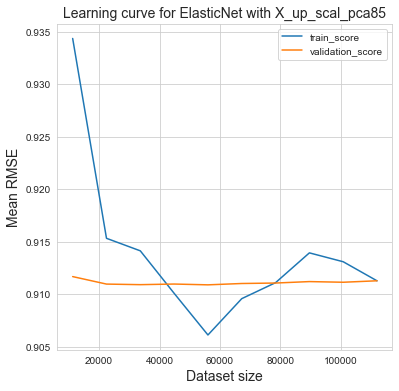

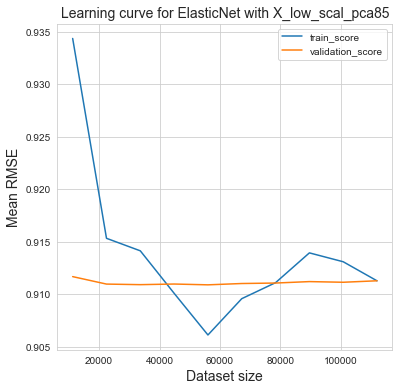

CPU times: user 35.7 s, sys: 14.1 s, total: 49.8 s
Wall time: 23.5 s


model            X_data      RMSE       MAE Pearson_coef
0  ElasticNet          X_scaled  0.911698  0.628998     0.045133
1  ElasticNet      X_scal_pca85   0.91136  0.628899     0.048648
2  ElasticNet   X_up_scal_pca85  0.911286  0.628858     0.052801
3  ElasticNet  X_low_scal_pca85  0.911281  0.628855     0.053039

<IPython.core.display.Javascript object>

In [44]:
%%time

model = ElasticNet()
n_folds = 5

# Dataframe for results
elast_results = pd.DataFrame(columns=[
            "model", "X_data", "RMSE", "MAE", "Pearson_coef",
        ])

# for each kind of X data
for name_X, X_data in dico_X_scaled.items() :
    
    # Learning curve
    display_learning_curve(model, X_data, y_train, "ElasticNet", name_X)
                           
    # Get results
    df_elast = cross_val(model, X_data, y_train, "ElasticNet", name_X)
    elast_results = pd.concat([elast_results, df_elast], axis = 0).reset_index(drop=True)

elast_results

As we can see, in some cases Pearson_coef cannot be performed.

In [45]:
elast_results.sort_values(by = "RMSE")

model            X_data      RMSE       MAE Pearson_coef
3  ElasticNet  X_low_scal_pca85  0.911281  0.628855     0.053039
2  ElasticNet   X_up_scal_pca85  0.911286  0.628858     0.052801
1  ElasticNet      X_scal_pca85   0.91136  0.628899     0.048648
0  ElasticNet          X_scaled  0.911698  0.628998     0.045133

<IPython.core.display.Javascript object>

In [46]:
elast_results.sort_values(by = "MAE")

model            X_data      RMSE       MAE Pearson_coef
3  ElasticNet  X_low_scal_pca85  0.911281  0.628855     0.053039
2  ElasticNet   X_up_scal_pca85  0.911286  0.628858     0.052801
1  ElasticNet      X_scal_pca85   0.91136  0.628899     0.048648
0  ElasticNet          X_scaled  0.911698  0.628998     0.045133

<IPython.core.display.Javascript object>

In [49]:
elast_results.sort_values(by = "Pearson_coef", ascending = False)

model            X_data      RMSE       MAE Pearson_coef
3  ElasticNet  X_low_scal_pca85  0.911281  0.628855     0.053039
2  ElasticNet   X_up_scal_pca85  0.911286  0.628858     0.052801
1  ElasticNet      X_scal_pca85   0.91136  0.628899     0.048648
0  ElasticNet          X_scaled  0.911698  0.628998     0.045133

<IPython.core.display.Javascript object>

Top 3 model is the same for each metric. Nevertheless, metrics are worse than LinearRegression.

Let's see if we are increasing pca explained variance on scaled data how the metrics evolve.

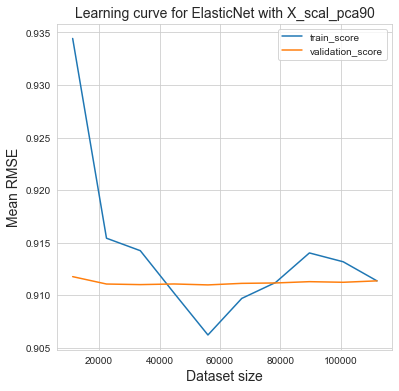

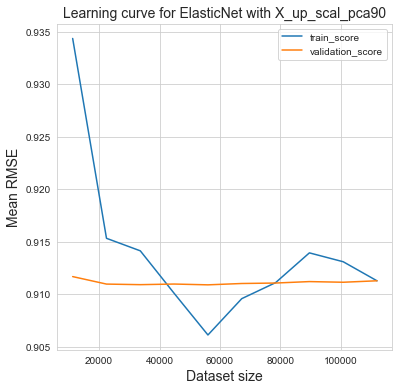

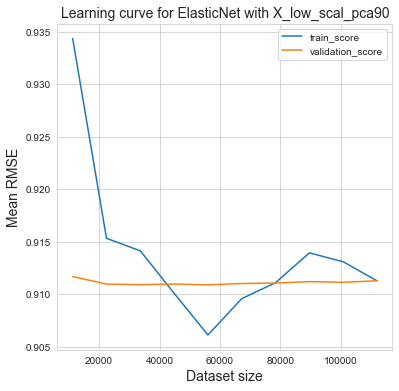

CPU times: user 6.8 s, sys: 3.09 s, total: 9.89 s
Wall time: 3.11 s


model            X_data      RMSE       MAE Pearson_coef
0  ElasticNet      X_scal_pca90   0.91136  0.628899     0.048648
1  ElasticNet   X_up_scal_pca90  0.911286  0.628858     0.052801
2  ElasticNet  X_low_scal_pca90  0.911281  0.628855     0.053039

<IPython.core.display.Javascript object>

In [48]:
%%time

model = ElasticNet()
n_folds = 5

# Dataframe for results
elast_results_90pca = pd.DataFrame(columns=[
            "model", "X_data", "RMSE", "MAE", "Pearson_coef",
        ])

# for each kind of X data
for name_X, X_data in small_dico_X_pca90.items() :
    
    # Learning curve
    display_learning_curve(model, X_data, y_train, "ElasticNet", name_X)
                           
    # Get results
    df_elast = cross_val(model, X_data, y_train, "ElasticNet", name_X)
    elast_results_90pca = pd.concat([elast_results_90pca, df_elast], axis = 0).reset_index(drop=True)

elast_results_90pca

Same results as above.
### XGboost
As it is a model that takes time, let's try on data with less features.

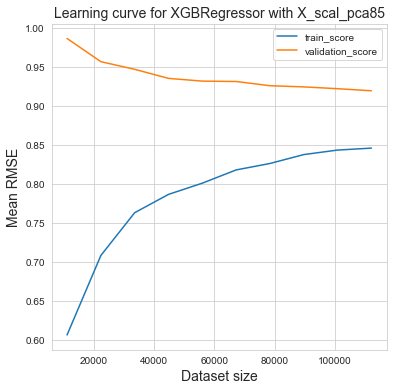

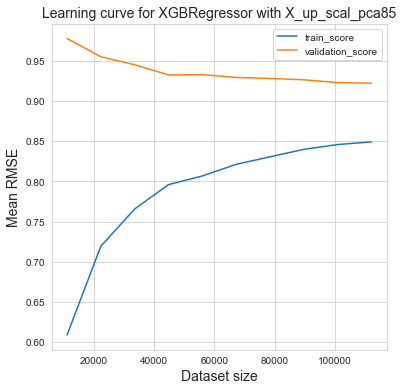

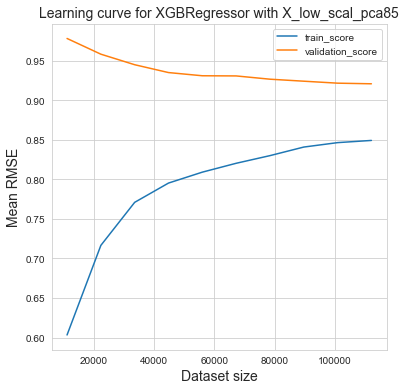

CPU times: user 51min 22s, sys: 1min 7s, total: 52min 30s
Wall time: 14min 55s


model            X_data      RMSE       MAE Pearson_coef
0  XGBRegressor      X_scal_pca85  0.919949  0.637183      0.04213
1  XGBRegressor   X_up_scal_pca85   0.92235  0.638047     0.029225
2  XGBRegressor  X_low_scal_pca85  0.921092  0.637511     0.034055

<IPython.core.display.Javascript object>

In [40]:
%%time

model = XGBRegressor()
n_folds = 5

# Dataframe for results
xg_results = pd.DataFrame(columns=[
            "model", "X_data", "RMSE", "MAE", "Pearson_coef",
        ])

# for each kind of X data
for name_X, X_data in small_dico_X.items() :
    
    # Learning curve
    display_learning_curve(model, X_data, y_train, "XGBRegressor", name_X)
                           
    # Get results
    df_xg = cross_val(model, X_data, y_train, "XGBRegressor", name_X)
    xg_results = pd.concat([xg_results, df_xg], axis = 0).reset_index(drop=True)

xg_results

Even if the learning curves are nice, metrics are worse than other models. We will need to tune hyperparameters.

## Model optimization using TimeSeriesSplit
We are going to compare different models : 
- Linear Regression
- ElasticNet
- XGBoost
- one Neuronal network

We are going to split data in cross validation with TimeSeriesSplit.

In [18]:
ts_cv = TimeSeriesSplit(n_splits=5, test_size = 20000)
# test_size = n_samples//(n_splits + 1)
# train_size = i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1)

<IPython.core.display.Javascript object>

In [23]:
# Initiate counter
i = 1

# Get number of samples in each fold
for train_index, val_index in ts_cv.split(X_pca85):
    print(
        "Split ",
        i,
        "\nTrain nb of samples :",
        len(train_index),
        "Validation nb of samples :",
        len(val_index),
        "\n",
    )
    i += 1

Split  1 
Train nb of samples : 40000 Validation nb of samples : 20000 

Split  2 
Train nb of samples : 60000 Validation nb of samples : 20000 

Split  3 
Train nb of samples : 80000 Validation nb of samples : 20000 

Split  4 
Train nb of samples : 100000 Validation nb of samples : 20000 

Split  5 
Train nb of samples : 120000 Validation nb of samples : 20000 



<IPython.core.display.Javascript object>

#### Linear Regression

In [107]:
%%time

model = LinearRegression()
n_folds = ts_cv

# Dataframe for results
lr_results_ts_cv = pd.DataFrame(columns=[
            "model", "X_data", "RMSE", "MAE", "Pearson_coef",
        ])

# for each kind of X data
for name_X, X_data in dico_X.items() :
                           
    # Get results
    df_lr = cross_val(model, X_data, y_train, "LinearRegression", name_X)
    lr_results_ts_cv = pd.concat([lr_results_ts_cv, df_lr], axis = 0).reset_index(drop=True)

lr_results_ts_cv

CPU times: user 34.1 s, sys: 4.75 s, total: 38.8 s
Wall time: 13.8 s


model            X_data      RMSE       MAE Pearson_coef
0  LinearRegression           X_train  0.908742  0.621333      0.09949
1  LinearRegression          X_scaled  0.908742  0.621333      0.09949
2  LinearRegression           X_pca85  0.906316  0.618908     0.104369
3  LinearRegression      X_scal_pca85    0.9082  0.620276     0.072287
4  LinearRegression        X_up_pca85  0.906208  0.618814     0.105118
5  LinearRegression   X_up_scal_pca85  0.908131  0.620209      0.07328
6  LinearRegression       X_low_pca85  0.906225  0.618842      0.10491
7  LinearRegression  X_low_scal_pca85  0.908127  0.620206      0.07334

<IPython.core.display.Javascript object>

In [108]:
lr_results_ts_cv.sort_values(by="RMSE")

model            X_data      RMSE       MAE Pearson_coef
4  LinearRegression        X_up_pca85  0.906208  0.618814     0.105118
6  LinearRegression       X_low_pca85  0.906225  0.618842      0.10491
2  LinearRegression           X_pca85  0.906316  0.618908     0.104369
7  LinearRegression  X_low_scal_pca85  0.908127  0.620206      0.07334
5  LinearRegression   X_up_scal_pca85  0.908131  0.620209      0.07328
3  LinearRegression      X_scal_pca85    0.9082  0.620276     0.072287
1  LinearRegression          X_scaled  0.908742  0.621333      0.09949
0  LinearRegression           X_train  0.908742  0.621333      0.09949

<IPython.core.display.Javascript object>

In [115]:
df_val = lr_results_ts_cv.sort_values(by="RMSE").head(1).drop(["MAE"], axis=1)
df_val

model      X_data      RMSE Pearson_coef
4  LinearRegression  X_up_pca85  0.906208     0.105118

<IPython.core.display.Javascript object>

Top 3 is the same, RMSE ans MAE are better, but Pearson_coef is worse (except when trained on all data).

We choose X_up_pca85 as best pre processed data and we are going to evaluate this model. 

In [42]:
# Create Pipeline
pipeline_lr = Pipeline(
    [("pca", PCA(n_components=0.85, random_state=0)), ("lr", LinearRegression()),]
)

# Model training
pipeline_lr.fit(X_up_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=0.85, random_state=0)),
                ('lr', LinearRegression())])

<IPython.core.display.Javascript object>

In [41]:
def get_scores(model, name_model, name_X, X_test, y_test):

    # get predictions
    y_pred = model.predict(X_test)

    # Get scores
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    pearson = pearsonr(y_pred, y_test)[0]

    # Data frame for results
    results = pd.DataFrame(
        [[name_model, name_X, RMSE, pearson]],
        columns=["model", "X_data", "RMSE", "Pearson_coef"],
    )

    return y_pred, results

<IPython.core.display.Javascript object>

In [43]:
y_pred, lr_final = get_scores(
    pipeline_lr, "LinearRegression", "X_up_pca85", X_up_test, y_test
)
lr_final

model      X_data      RMSE  Pearson_coef
0  LinearRegression  X_up_pca85  0.897627      0.094731

<IPython.core.display.Javascript object>

In [67]:
# Create Pipeline
pipeline_lr_all = Pipeline(
    [("pca", PCA(n_components=0.85, random_state=0)), ("lr", LinearRegression()),]
)
# Model training
pipeline_lr_all.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=0.85, random_state=0)),
                ('lr', LinearRegression())])

<IPython.core.display.Javascript object>

In [68]:
y_pred, lr_final_all = get_scores(
    pipeline_lr_all, "LinearRegression", "X_pca85", X_test, y_test
)
lr_final_all

model   X_data     RMSE  Pearson_coef
0  LinearRegression  X_pca85  0.89771      0.093771

<IPython.core.display.Javascript object>

In [120]:
def best_param(model, cv_split, X_train, hyper_params, scoring, name_model, name_X):

    # Initiate GridSearchCV
    grid = GridSearchCV(
        model,
        param_grid=hyper_params,
        return_train_score=True,
        cv=cv_split,
        scoring=scoring,
        refit="my_pearson",
        n_jobs=-1,
    )

    # Train model
    grid.fit(X_train, y_train)

    # Display best parameters
    if len(hyper_params) != 0:
        print("Best parameters : ")
        for params, val in grid.best_params_.items():
            print(" - ", params, ":", val)

    for scorer in scoring:
        if scorer == "neg_root_mean_squared_error":
            # Best mean RMSE and std
            RMSE_mean_train = -grid.cv_results_["mean_train_%s" % scorer][
                grid.best_index_
            ]
            RMSE_mean_val = -grid.cv_results_["mean_test_%s" % scorer][grid.best_index_]
            RMSE_std_val = grid.cv_results_["std_test_%s" % scorer][grid.best_index_]

        else:
            # Best mean Pearson coefficient and std
            pearson_mean_train = grid.cv_results_["mean_train_%s" % scorer][
                grid.best_index_
            ]
            pearson_mean_val = grid.cv_results_["mean_test_%s" % scorer][
                grid.best_index_
            ]
            pearson_std_val = grid.cv_results_["std_test_%s" % scorer][grid.best_index_]

    # Model fit time
    mean_time = grid.cv_results_["mean_fit_time"][grid.best_index_]

    # Display results
    print("On validation set : ")
    print("- Mean RMSE : {:.5f} +/- {:.5f}".format(RMSE_mean_val, RMSE_std_val))
    print(
        "- Mean Pearson coefficient : {:.5f} +/- {:.5f}".format(
            pearson_mean_val, pearson_std_val
        )
    )
    print("- Fit Time : {:.3f} s \n".format(mean_time))

    # Get results in a dataFrame
    df_results = pd.DataFrame(
        [
            [
                name_model,
                name_X,
                round(mean_time, 3),
                round(RMSE_mean_train, 5),
                round(RMSE_mean_val, 5),
                round(pearson_mean_train, 5),
                round(pearson_mean_val, 5),
            ]
        ],
        columns=[
            "model",
            "X_data",
            "mean_fit_time",
            "mean_RMSE_train",
            "mean_RMSE_validation",
            "mean_pearson_coef_train",
            "mean_pearson_coef_validation",
        ],
    )

    return grid.best_estimator_, df_results

<IPython.core.display.Javascript object>

In [119]:
scoring = {
    "neg_root_mean_squared_error": "neg_root_mean_squared_error",
    "my_pearson": my_pearson,
}

<IPython.core.display.Javascript object>

In [33]:
%%time

# Model
model = LinearRegression()

# Hyperparameters grid
hyper_params = {}

# List of grid models
list_lr_grid = []

# Dataframe for results
lr_results = pd.DataFrame(columns=[
            "model",
            "X_data",
            "mean_fit_time",
            "mean_RMSE_train",
            "mean_RMSE_validation",
            "mean_pearson_coef_train",
            "mean_pearson_coef_validation",
        ])

# for each kind of X data
for name_X, X_data in dico_X.items() :
    print(name_X,"------------")
    lr_grid, df_lr = best_param(
    model, ts_cv, X_data, hyper_params, scoring, "LinearRegression", name_X
)
    lr_results = pd.concat([lr_results, df_lr], axis = 0)
    list_lr_grid.append(lr_grid)

X_train ------------
On validation set : 
- Mean Pearson coefficient : 0.0995 +/- 0.0268
- Mean RMSE : 0.9087 +/- 0.0229
- Fit Time : 1.8000 s 

X_scaled ------------
On validation set : 
- Mean Pearson coefficient : 0.0995 +/- 0.0268
- Mean RMSE : 0.9087 +/- 0.0229
- Fit Time : 1.9313 s 

X_pca85 ------------
On validation set : 
- Mean Pearson coefficient : 0.1044 +/- 0.0234
- Mean RMSE : 0.9063 +/- 0.0223
- Fit Time : 0.9152 s 

X_scal_pca85 ------------
On validation set : 
- Mean Pearson coefficient : 0.0723 +/- 0.0221
- Mean RMSE : 0.9082 +/- 0.0215
- Fit Time : 0.0257 s 

X_up_pca85 ------------
On validation set : 
- Mean Pearson coefficient : 0.1051 +/- 0.0230
- Mean RMSE : 0.9062 +/- 0.0222
- Fit Time : 0.8916 s 

X_up_scal_pca85 ------------
On validation set : 
- Mean Pearson coefficient : 0.0733 +/- 0.0225
- Mean RMSE : 0.9081 +/- 0.0215
- Fit Time : 0.0191 s 

X_low_pca85 ------------
On validation set : 
- Mean Pearson coefficient : 0.1049 +/- 0.0229
- Mean RMSE : 0.9062

<IPython.core.display.Javascript object>

In [34]:
lr_results

model            X_data  mean_fit_time  mean_RMSE_train  \
0  LinearRegression           X_train         1.6484           0.8978   
0  LinearRegression          X_scaled         1.7768           0.8978   
0  LinearRegression           X_pca85         0.9599           0.9010   
0  LinearRegression      X_scal_pca85         0.0352           0.9076   
0  LinearRegression        X_up_pca85         0.9630           0.9010   
0  LinearRegression   X_up_scal_pca85         0.0187           0.9077   
0  LinearRegression       X_low_pca85         0.9066           0.9010   
0  LinearRegression  X_low_scal_pca85         0.0190           0.9077   
0  LinearRegression  X_low_scal_pca85         0.0190           0.9077   

   mean_RMSE_validation  mean_pearson_coef_train  mean_pearson_coef_validation  
0                0.9087                   0.1688                        0.0995  
0                0.9087                   0.1688                        0.0995  
0                0.9063                   0.1473                        0.1044  
0                0.9082                   0.0856                        0.0723  
0                0.9062                   0.1474                        0.1051  
0                0.9081                   0.0852                        0.0733  
0                0.9062                   0.1472                        0.1049  
0                0.9081                   0.0853                        0.0733  
0                0.9081                   0.0853                        0.0733

<IPython.core.display.Javascript object>

In [60]:
%%time

# Model
model = LinearRegression()

# Hyperparameters grid
hyper_params = {}

# List of grid models
list_lr_grid_5 = []

# Dataframe for results
lr_results_5 = pd.DataFrame(columns=[
            "model",
            "X_data",
            "mean_fit_time",
            "mean_RMSE_train",
            "mean_RMSE_validation",
            "mean_pearson_coef_train",
            "mean_pearson_coef_validation",
        ])

# for each kind of X data
for name_X, X_data in dico_X.items() :
    print(name_X,"------------")
    lr_grid, df_lr = best_param(
    model, 5, X_data, hyper_params, scoring, "LinearRegression", name_X
)
    lr_results_5 = pd.concat([lr_results_5, df_lr], axis = 0)
    list_lr_grid_5.append(lr_grid)

X_train ------------
On validation set : 
- Mean Pearson coefficient : 0.0884 +/- 0.0466
- Mean RMSE : 1.1109 +/- 0.4117
- Fit Time : 2.7928 s 

X_scaled ------------
On validation set : 
- Mean Pearson coefficient : 0.0884 +/- 0.0466
- Mean RMSE : 1.1109 +/- 0.4117
- Fit Time : 2.8683 s 

X_pca85 ------------
On validation set : 
- Mean Pearson coefficient : 0.1133 +/- 0.0214
- Mean RMSE : 0.9064 +/- 0.0162
- Fit Time : 1.5657 s 

X_scal_pca85 ------------
On validation set : 
- Mean Pearson coefficient : 0.0743 +/- 0.0165
- Mean RMSE : 0.9096 +/- 0.0151
- Fit Time : 0.0320 s 

X_up_pca85 ------------
On validation set : 
- Mean Pearson coefficient : 0.1136 +/- 0.0212
- Mean RMSE : 0.9064 +/- 0.0162
- Fit Time : 1.6808 s 

X_up_scal_pca85 ------------
On validation set : 
- Mean Pearson coefficient : 0.0748 +/- 0.0166
- Mean RMSE : 0.9096 +/- 0.0152
- Fit Time : 0.0296 s 

X_low_pca85 ------------
On validation set : 
- Mean Pearson coefficient : 0.1136 +/- 0.0207
- Mean RMSE : 0.9064

<IPython.core.display.Javascript object>

In [61]:
lr_results_5

model            X_data mean_fit_time mean_RMSE_train  \
0  LinearRegression           X_train        2.7928          0.9024   
0  LinearRegression          X_scaled        2.8683          0.9024   
0  LinearRegression           X_pca85        1.5657          0.9044   
0  LinearRegression      X_scal_pca85         0.032          0.9094   
0  LinearRegression        X_up_pca85        1.6808          0.9043   
0  LinearRegression   X_up_scal_pca85        0.0296          0.9094   
0  LinearRegression       X_low_pca85        1.6794          0.9043   
0  LinearRegression  X_low_scal_pca85        0.0285          0.9094   

  mean_RMSE_validation mean_pearson_coef_train mean_pearson_coef_validation  
0               1.1109                  0.1446                       0.0884  
0               1.1109                  0.1446                       0.0884  
0               0.9064                  0.1295                       0.1133  
0               0.9096                  0.0762                       0.0743  
0               0.9064                  0.1301                       0.1136  
0               0.9096                   0.076                       0.0748  
0               0.9064                    0.13                       0.1136  
0               0.9096                  0.0761                       0.0748

<IPython.core.display.Javascript object>

In [35]:
# Save dataframe
joblib.dump(lr_results, "./Data/lr_results.joblib")

['./Data/lr_results.joblib']

<IPython.core.display.Javascript object>

#### ElasticNet
We are going to optimize hyperparameters for ElasticNet with a GridSearCV. Don't forget to use scaled data.

In [121]:
%%time

# Model
model = ElasticNet(random_state = 42)

# Alpha = Constant that multiplies the penalty terms
alpha_range = np.logspace(-2, 2, 5) # default = 1.0

# l1_ratio 
l1_ratio = [0.1, 0.3, 0.5, 0.7, 0.9] # default = 0.5

# Tolerance for the optimization
tol_range = np.logspace(-6, -2, 5) # default = 1e-4

# Hyperparameters grid
hyper_params_elast = {'alpha': alpha_range, 
              'l1_ratio': l1_ratio,
             'tol' : tol_range}

# List of grid models
list_elast_grid = []

# Dataframe for results
elast_results_ts_cv = pd.DataFrame(columns=[
            "model",
            "X_data",
            "mean_fit_time",
            "mean_RMSE_train",
            "mean_RMSE_validation",
            "mean_pearson_coef_train",
            "mean_pearson_coef_validation",
        ])

for name_X, X_data in dico_X_scaled.items() :
    print(name_X,"------------")
    elast_grid, df_elast = best_param(
    model, ts_cv, X_data, hyper_params_elast, scoring, "ElasticNet", name_X
)
    elast_results_ts_cv = pd.concat([elast_results_ts_cv, df_elast], axis = 0).reset_index(drop=True)
    list_elast_grid.append(elast_grid)

X_scaled ------------
Best parameters : 
 -  alpha : 0.01
 -  l1_ratio : 0.1
 -  tol : 0.01
On validation set : 
- Mean RMSE : 0.90662 +/- 0.02299
- Mean Pearson coefficient : 0.10346 +/- 0.02721
- Fit Time : 15.769 s 

X_scal_pca85 ------------
Best parameters : 
 -  alpha : 0.1
 -  l1_ratio : 0.5
 -  tol : 1e-05
On validation set : 
- Mean RMSE : 0.90802 +/- 0.02129
- Mean Pearson coefficient : 0.07346 +/- 0.02188
- Fit Time : 0.023 s 

X_up_scal_pca85 ------------


/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.93705940246582, tolerance: 0.03354205936193466
  model = cd_fast.enet_coordinate_descent(
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.995972216129303, tolerance: 0.10053610801696777
  model = cd_fast.enet_coordinate_descent(
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.93705940246582, tolerance: 3.354205846786499
  model = cd_fast.enet_coordinate_descent(
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.605048656463623, tolerance: 0.08288402855396271
  model = cd_fast.enet_coordinate_descent(
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.605048656463623, tolerance: 0.8288403153419495
  model = cd_fast.enet_coordinate_descent(
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation

  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/pyt

Best parameters : 
 -  alpha : 0.1
 -  l1_ratio : 0.5
 -  tol : 1e-06
On validation set : 
- Mean RMSE : 0.90800 +/- 0.02134
- Mean Pearson coefficient : 0.07402 +/- 0.02215
- Fit Time : 0.017 s 

X_low_scal_pca85 ------------
Best parameters : 
 -  alpha : 0.1
 -  l1_ratio : 0.5
 -  tol : 1e-06
On validation set : 
- Mean RMSE : 0.90799 +/- 0.02135
- Mean Pearson coefficient : 0.07408 +/- 0.02216
- Fit Time : 0.016 s 

CPU times: user 27.2 s, sys: 4.59 s, total: 31.8 s
Wall time: 7min 1s


<IPython.core.display.Javascript object>

In [122]:
elast_results_ts_cv

model            X_data mean_fit_time mean_RMSE_train  \
0  ElasticNet          X_scaled        15.769         0.89858   
1  ElasticNet      X_scal_pca85         0.023         0.90772   
2  ElasticNet   X_up_scal_pca85         0.017         0.90773   
3  ElasticNet  X_low_scal_pca85         0.016         0.90773   

  mean_RMSE_validation mean_pearson_coef_train mean_pearson_coef_validation  
0              0.90662                 0.16471                      0.10346  
1              0.90802                   0.085                      0.07346  
2                0.908                 0.08472                      0.07402  
3              0.90799                 0.08477                      0.07408

<IPython.core.display.Javascript object>

In [118]:
elast_results_ts_cv

Empty DataFrame
Columns: [model, X_data, mean_fit_time, mean_RMSE_train, mean_RMSE_validation, mean_pearson_coef_train, mean_pearson_coef_validation]
Index: []

<IPython.core.display.Javascript object>

In [123]:
df_els = elast_results_ts_cv.head(1).drop(
    ["mean_fit_time", "mean_RMSE_train", "mean_pearson_coef_train"], axis=1
)
df_els = df_els.rename(
    columns={
        "mean_RMSE_validation": "RMSE",
        "mean_pearson_coef_validation": "Pearson_coef",
    }
)
df_els

model    X_data     RMSE Pearson_coef
0  ElasticNet  X_scaled  0.90662      0.10346

<IPython.core.display.Javascript object>

In [124]:
df_val = pd.concat([df_val, df_els], axis=0).reset_index(drop=True)
df_val

model      X_data      RMSE Pearson_coef
0  LinearRegression  X_up_pca85  0.906208     0.105118
1        ElasticNet    X_scaled   0.90662      0.10346

<IPython.core.display.Javascript object>

As we can see, it is on X_scaled that metrics are the best.

In [125]:
# Get the params for best ElasticNet model
list_elast_grid[0]

ElasticNet(alpha=0.01, l1_ratio=0.1, random_state=42, tol=0.01)

<IPython.core.display.Javascript object>

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: 

In [29]:
# Create Pipeline
pipeline_elast = Pipeline(
    [("scal", RobustScaler()), 
     ("elast", ElasticNet(
         alpha=0.01, l1_ratio=0.1, random_state=42, tol=0.01)),]
)

# Model training
pipeline_elast.fit(X_train, y_train)

Pipeline(steps=[('scal', RobustScaler()),
                ('elast',
                 ElasticNet(alpha=0.01, l1_ratio=0.1, random_state=42,
                            tol=0.01))])

<IPython.core.display.Javascript object>

In [34]:
y_pred, elast_final = get_scores(
    pipeline_elast, "ElasticNet", "X_scaled", X_test, y_test
)
elast_final

model    X_data      RMSE  Pearson_coef
0  ElasticNet  X_scaled  0.897163      0.098006

<IPython.core.display.Javascript object>

In [35]:
# Save model
joblib.dump(pipeline_elast, "./Data/pipeline_elast.joblib")

['./Data/pipeline_elast.joblib']

<IPython.core.display.Javascript object>

In [48]:
# Old
elast_results

model            X_data mean_fit_time mean_RMSE_train  \
0  ElasticNet           X_train         4.973          0.9001   
0  ElasticNet          X_scaled       25.7911          0.8986   
0  ElasticNet           X_pca85        0.3327          0.9015   
0  ElasticNet      X_scal_pca85        0.0187          0.9077   
0  ElasticNet        X_up_pca85        0.2845          0.9016   
0  ElasticNet   X_up_scal_pca85         0.016          0.9077   
0  ElasticNet       X_low_pca85        0.3165          0.9015   
0  ElasticNet  X_low_scal_pca85         0.014          0.9077   

  mean_RMSE_validation mean_pearson_coef_train mean_pearson_coef_validation  
0               0.9056                  0.1555                       0.1057  
0               0.9066                  0.1647                       0.1035  
0               0.9055                  0.1442                       0.1062  
0                0.908                   0.085                       0.0735  
0               0.9055                  0.1441                       0.1059  
0                0.908                  0.0847                        0.074  
0               0.9054                  0.1442                       0.1071  
0                0.908                  0.0848                       0.0741

<IPython.core.display.Javascript object>

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: 

In [49]:
# Save dataframe
joblib.dump(elast_results, "./Data/elast_results.joblib")

['./Data/elast_results.joblib']

<IPython.core.display.Javascript object>

In [29]:
%%time

# Model
model = ElasticNet(random_state = 42)

# Alpha
alpha_range = np.logspace(-2, 2, 5) # default = 1.0

# l1_ratio 
l1_ratio = [0.1, 0.3, 0.5, 0.7, 0.9] # default = 0.5

# Tolerance for the optimization
tol_range = [1e-5, 1e-4, 1e-3] # default = 1e-4

# Hyperparameters grid
hyper_params_elast = {'alpha': alpha_range, 
              'l1_ratio': l1_ratio,
             'tol' : tol_range}


# List of grid models
list_elast_grid_bis = []

# Dataframe for results
elast_results_bis = pd.DataFrame(columns=[
            "model",
            "X_data",
            "mean_fit_time",
            "mean_RMSE_train",
            "mean_RMSE_validation",
            "mean_pearson_coef_train",
            "mean_pearson_coef_validation",
        ])

for name_X, X_data in small_dico_X_bis.items() :
    print(name_X,"------------")
    elast_grid, df_elast = best_param(
    model, ts_cv, X_data, hyper_params_elast, scoring, "ElasticNet", name_X
)
    elast_results_bis = pd.concat([elast_results_bis, df_elast], axis = 0)
    list_elast_grid_bis.append(elast_grid)

X_pca85 ------------


/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.10545404 0.10545406 0.10545419 0.10621256 0.1062126  0.10621274
 0.10558734 0.10558737 0.1055876  0.10399065 0.10399064 0.10399071
 0.101699   0.10169897 0.10169894 0.10005025 0.10005022 0.10005016
 0.08357805 0.08357805 0.08357811 0.07202025 0.07202025 0.07202014
 0.06293368 0.06293368 0.06293368 0.05861888 0.05861888 0.05861888
 0.05728716 0.05728716 0.05728716        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan]
  warnin

Best parameters : 
 -  alpha : 0.01
 -  l1_ratio : 0.3
 -  tol : 0.001
On validation set : 
- Mean Pearson coefficient : 0.1062 +/- 0.0239
- Mean RMSE : 0.9055 +/- 0.0223
- Fit Time : 0.2674 s 

X_up_pca85 ------------


/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.10581007 0.10581006 0.10581012 0.10591261 0.10591262 0.10591277
 0.10474126 0.10474124 0.10474128 0.10289812 0.1028981  0.10289795
 0.10044249 0.10044248 0.10044264 0.098835   0.098835   0.09883506
 0.0854796  0.0854796  0.08547937 0.07432062 0.07432061 0.07432054
 0.06022352 0.06022352 0.06022353 0.05491088 0.05491088 0.05491088
 0.05521108 0.05521108 0.05521108        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan]
  warnin

Best parameters : 
 -  alpha : 0.01
 -  l1_ratio : 0.3
 -  tol : 0.001
On validation set : 
- Mean Pearson coefficient : 0.1059 +/- 0.0235
- Mean RMSE : 0.9055 +/- 0.0222
- Fit Time : 0.2978 s 

X_low_pca85 ------------


/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: 

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4023: 

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.10623194 0.10623194 0.10623181 0.10709505 0.10709504 0.10709472
 0.1060522  0.10605217 0.10605189 0.10383143 0.10383141 0.10383106
 0.10146305 0.10146304 0.10146258 0.10007928 0.10007928 0.10007893
 0.0878623  0.08786231 0.08786241 0.07710679 0.07710679 0.0771067
 0.06075899 0.06075898 0.06075898 0.05562375 0.05562375 0.05562375
 0.05594736 0.05594736 0.05594736        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan]
  warning

Best parameters : 
 -  alpha : 0.01
 -  l1_ratio : 0.3
 -  tol : 1e-05
On validation set : 
- Mean Pearson coefficient : 0.1071 +/- 0.0231
- Mean RMSE : 0.9054 +/- 0.0222
- Fit Time : 0.2981 s 

CPU times: user 3.76 s, sys: 1.3 s, total: 5.05 s
Wall time: 1min 56s


<IPython.core.display.Javascript object>

In [30]:
elast_results_bis

model       X_data mean_fit_time mean_RMSE_train mean_RMSE_validation  \
0  ElasticNet      X_pca85        0.2674          0.9015               0.9055   
0  ElasticNet   X_up_pca85        0.2978          0.9016               0.9055   
0  ElasticNet  X_low_pca85        0.2981          0.9015               0.9054   

  mean_pearson_coef_train mean_pearson_coef_validation  
0                  0.1442                       0.1062  
0                  0.1441                       0.1059  
0                  0.1442                       0.1071

<IPython.core.display.Javascript object>

In [59]:
# Create Pipeline
pipeline_elast_1 = Pipeline(
    [
        ("pca", PCA(n_components=0.85, random_state=0)),
        ("elast", ElasticNet(alpha=0.01, l1_ratio=0.3, random_state=42, tol=1e-5)),
    ]
)

# Model training
pipeline_elast_1.fit(X_low_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=0.85, random_state=0)),
                ('elast',
                 ElasticNet(alpha=0.01, l1_ratio=0.3, random_state=42,
                            tol=1e-05))])

<IPython.core.display.Javascript object>

In [60]:
y_pred, elast_final_1 = get_scores(
    pipeline_elast_1, "ElasticNet", "X_low_pca85", X_low_test, y_test
)
elast_final_1

model       X_data      RMSE  Pearson_coef
0  ElasticNet  X_low_pca85  0.896946      0.097208

<IPython.core.display.Javascript object>

In [53]:
def best_param2(model, cv_split, X_train, hyper_params, scoring, name_model, name_X):

    # Initiate GridSearchCV
    grid = GridSearchCV(
        model,
        param_grid=hyper_params,
        return_train_score=True,
        cv=cv_split,
        scoring=scoring,
        n_jobs=-1,
    )

    # Train model
    grid.fit(X_train, y_train)

    # Display best parameters
    if len(hyper_params) != 0:
        print("Best parameters : ")
        for params, val in grid.best_params_.items():
            print(" - ", params, ":", val)

    RMSE_mean_train = -grid.cv_results_["mean_train_score"][
                grid.best_index_
            ]
    RMSE_mean_val = -grid.cv_results_["mean_test_score"][grid.best_index_]
    RMSE_std_val = grid.cv_results_["std_test_score"][grid.best_index_]

    # Model fit time
    mean_time = grid.cv_results_["mean_fit_time"][grid.best_index_]

    # Display results
    print("On validation set : ")
    print("- Mean RMSE : {:.4f} +/- {:.4f}".format(RMSE_mean_val, RMSE_std_val))
    print("- Fit Time : {:.4f} s \n".format(mean_time))

    # Get results in a dataFrame
    df_results = pd.DataFrame(
        [
            [
                name_model,
                name_X,
                round(mean_time, 4),
                round(RMSE_mean_train, 4),
                round(RMSE_mean_val, 4),
            ]
        ],
        columns=[
            "model",
            "X_data",
            "mean_fit_time",
            "mean_RMSE_train",
            "mean_RMSE_validation",
        ],
    )

    return grid, df_results

<IPython.core.display.Javascript object>

In [54]:
%%time

# Model
model = LinearRegression()
scoring = "neg_root_mean_squared_error"

# Hyperparameters grid
hyper_params = {}

# List of grid models
list_lr_grid_2 = []

# Dataframe for results
lr_results_2 = pd.DataFrame(columns=[
            "model",
            "X_data",
            "mean_fit_time",
            "mean_RMSE_train",
            "mean_RMSE_validation",
        ])

# for each kind of X data
for name_X, X_data in dico_X.items() :
    print(name_X,"------------")
    lr_grid, df_lr = best_param2(
    model, ts_cv, X_data, hyper_params, scoring, "LinearRegression", name_X
)
    lr_results_2 = pd.concat([lr_results_2, df_lr], axis = 0)
    list_lr_grid_2.append(lr_grid)

X_train ------------
On validation set : 
- Mean RMSE : 0.9087 +/- 0.0229
- Fit Time : 1.8211 s 

X_scaled ------------
On validation set : 
- Mean RMSE : 0.9087 +/- 0.0229
- Fit Time : 1.9298 s 

X_pca85 ------------
On validation set : 
- Mean RMSE : 0.9063 +/- 0.0223
- Fit Time : 0.9226 s 

X_scal_pca85 ------------
On validation set : 
- Mean RMSE : 0.9082 +/- 0.0215
- Fit Time : 0.0246 s 

X_up_pca85 ------------
On validation set : 
- Mean RMSE : 0.9062 +/- 0.0222
- Fit Time : 1.0135 s 

X_up_scal_pca85 ------------
On validation set : 
- Mean RMSE : 0.9081 +/- 0.0215
- Fit Time : 0.0271 s 

X_low_pca85 ------------
On validation set : 
- Mean RMSE : 0.9062 +/- 0.0222
- Fit Time : 1.0272 s 

X_low_scal_pca85 ------------
On validation set : 
- Mean RMSE : 0.9081 +/- 0.0215
- Fit Time : 0.0197 s 

CPU times: user 10.4 s, sys: 2.55 s, total: 13 s
Wall time: 29.2 s


<IPython.core.display.Javascript object>

In [55]:
lr_results_2

model            X_data mean_fit_time mean_RMSE_train  \
0  LinearRegression           X_train        1.8211          0.8978   
0  LinearRegression          X_scaled        1.9298          0.8978   
0  LinearRegression           X_pca85        0.9226           0.901   
0  LinearRegression      X_scal_pca85        0.0246          0.9076   
0  LinearRegression        X_up_pca85        1.0135           0.901   
0  LinearRegression   X_up_scal_pca85        0.0271          0.9077   
0  LinearRegression       X_low_pca85        1.0272           0.901   
0  LinearRegression  X_low_scal_pca85        0.0197          0.9077   

  mean_RMSE_validation  
0               0.9087  
0               0.9087  
0               0.9063  
0               0.9082  
0               0.9062  
0               0.9081  
0               0.9062  
0               0.9081

<IPython.core.display.Javascript object>

We can see that best RMSE score on validation are with PCA and no scalering.

In [56]:
%%time

# Model
model = LinearRegression()
scoring = "neg_root_mean_squared_error"

# Hyperparameters grid
hyper_params = {}

# List of grid models
list_lr_grid_3 = []

# Dataframe for results
lr_results_3 = pd.DataFrame(columns=[
            "model",
            "X_data",
            "mean_fit_time",
            "mean_RMSE_train",
            "mean_RMSE_validation",
        ])

# for each kind of X data
for name_X, X_data in dico_X.items() :
    print(name_X,"------------")
    lr_grid, df_lr = best_param2(
    model, 5, X_data, hyper_params, scoring, "LinearRegression", name_X
)
    lr_results_3 = pd.concat([lr_results_3, df_lr], axis = 0)
    list_lr_grid_3.append(lr_grid)

X_train ------------
On validation set : 
- Mean RMSE : 1.1109 +/- 0.4117
- Fit Time : 3.2706 s 

X_scaled ------------
On validation set : 
- Mean RMSE : 1.1109 +/- 0.4117
- Fit Time : 2.9845 s 

X_pca85 ------------
On validation set : 
- Mean RMSE : 0.9064 +/- 0.0162
- Fit Time : 1.6165 s 

X_scal_pca85 ------------
On validation set : 
- Mean RMSE : 0.9096 +/- 0.0151
- Fit Time : 0.0397 s 

X_up_pca85 ------------
On validation set : 
- Mean RMSE : 0.9064 +/- 0.0162
- Fit Time : 1.9126 s 

X_up_scal_pca85 ------------
On validation set : 
- Mean RMSE : 0.9096 +/- 0.0152
- Fit Time : 0.0295 s 

X_low_pca85 ------------
On validation set : 
- Mean RMSE : 0.9064 +/- 0.0162
- Fit Time : 1.6102 s 

X_low_scal_pca85 ------------
On validation set : 
- Mean RMSE : 0.9096 +/- 0.0152
- Fit Time : 0.0266 s 

CPU times: user 11.2 s, sys: 1.61 s, total: 12.8 s
Wall time: 36 s


<IPython.core.display.Javascript object>

In [57]:
lr_results_3

model            X_data mean_fit_time mean_RMSE_train  \
0  LinearRegression           X_train        3.2706          0.9024   
0  LinearRegression          X_scaled        2.9845          0.9024   
0  LinearRegression           X_pca85        1.6165          0.9044   
0  LinearRegression      X_scal_pca85        0.0397          0.9094   
0  LinearRegression        X_up_pca85        1.9126          0.9043   
0  LinearRegression   X_up_scal_pca85        0.0295          0.9094   
0  LinearRegression       X_low_pca85        1.6102          0.9043   
0  LinearRegression  X_low_scal_pca85        0.0266          0.9094   

  mean_RMSE_validation  
0               1.1109  
0               1.1109  
0               0.9064  
0               0.9096  
0               0.9064  
0               0.9096  
0               0.9064  
0               0.9096

<IPython.core.display.Javascript object>

In [50]:
%%time

# Model
model = ElasticNet(random_state = 42)

scoring = "neg_root_mean_squared_error"

# Alpha
alpha_range = np.logspace(-2, 2, 5) # default = 1.0

# l1_ratio 
l1_ratio = [0.1, 0.3, 0.5, 0.7, 0.9] # default = 0.5

# Tolerance for the optimization
tol_range = [1e-5, 1e-4, 1e-3] # default = 1e-4

# Hyperparameters grid
hyper_params_elast = {'alpha': alpha_range, 
              'l1_ratio': l1_ratio,
             'tol' : tol_range}


# List of grid models
list_elast_grid_bis = []

# Dataframe for results
elast_results_bis = pd.DataFrame(columns=[
            "model",
            "X_data",
            "mean_fit_time",
            "mean_RMSE_train",
            "mean_RMSE_validation",
            "mean_pearson_coef_train",
            "mean_pearson_coef_validation",
        ])

for name_X, X_data in dico_X.items() :
    print(name_X,"------------")
    elast_grid, df_elast = best_param2(
    model, ts_cv, X_data, hyper_params_elast, scoring, "ElasticNet", name_X
)
    elast_results_bis = pd.concat([elast_results_bis, df_elast], axis = 0)
    list_elast_grid_bis.append(elast_grid)

X_train ------------
Best parameters : 
 -  alpha : 0.01
 -  l1_ratio : 0.3
 -  tol : 0.001
On validation set : 
- Root Square of R2 : 0.1297 
- Mean RMSE : 0.9056 +/- 0.0227
- Fit Time : 4.9280 s 

X_scaled ------------
Best parameters : 
 -  alpha : 0.01
 -  l1_ratio : 0.3
 -  tol : 0.001
On validation set : 
- Root Square of R2 : 0.1271 
- Mean RMSE : 0.9061 +/- 0.0226
- Fit Time : 4.8840 s 

X_pca85 ------------
Best parameters : 
 -  alpha : 0.01
 -  l1_ratio : 0.5
 -  tol : 0.001
On validation set : 
- Root Square of R2 : 0.1197 
- Mean RMSE : 0.9054 +/- 0.0223
- Fit Time : 0.2306 s 

X_scal_pca85 ------------
Best parameters : 
 -  alpha : 0.1
 -  l1_ratio : 0.7
 -  tol : 0.001
On validation set : 
- Root Square of R2 : 0.0741 
- Mean RMSE : 0.9080 +/- 0.0212
- Fit Time : 0.0151 s 

X_up_pca85 ------------
Best parameters : 
 -  alpha : 0.01
 -  l1_ratio : 0.5
 -  tol : 0.0001
On validation set : 
- Root Square of R2 : 0.1192 
- Mean RMSE : 0.9054 +/- 0.0222
- Fit Time : 0.3164 

<IPython.core.display.Javascript object>

In [51]:
elast_results_bis

model            X_data mean_fit_time mean_RMSE_train  \
0  ElasticNet           X_train         4.928          0.9001   
0  ElasticNet          X_scaled         4.884          0.9004   
0  ElasticNet           X_pca85        0.2306          0.9021   
0  ElasticNet      X_scal_pca85        0.0151          0.9078   
0  ElasticNet        X_up_pca85        0.3164          0.9022   
0  ElasticNet   X_up_scal_pca85        0.0154          0.9078   
0  ElasticNet       X_low_pca85        0.2876          0.9022   
0  ElasticNet  X_low_scal_pca85        0.0153          0.9078   

  mean_RMSE_validation mean_pearson_coef_train mean_pearson_coef_validation  \
0               0.9056                     NaN                          NaN   
0               0.9061                     NaN                          NaN   
0               0.9054                     NaN                          NaN   
0                0.908                     NaN                          NaN   
0               0.9054                     NaN                          NaN   
0                0.908                     NaN                          NaN   
0               0.9053                     NaN                          NaN   
0                0.908                     NaN                          NaN   

   Root Square of R2  
0             0.1297  
0             0.1271  
0             0.1197  
0             0.0741  
0             0.1192  
0             0.0743  
0             0.1201  
0             0.0744

<IPython.core.display.Javascript object>

We can see that best RMSE score on validation are with PCA and no scalering. In these cases, best parameters are :
- alpha = 0.01
- l1 ratio = 0.5
- tol = 10-3 for X_pca85, 10-4 for X_up_pca85, 10-5 for X_low_pca85.

In [68]:
%%time

# Model
model = ElasticNet(random_state = 42)

scoring = "neg_root_mean_squared_error"

# Alpha
alpha_range = np.logspace(-2, 2, 5) # default = 1.0

# l1_ratio 
l1_ratio = [0.1, 0.3, 0.5, 0.7, 0.9] # default = 0.5

# Tolerance for the optimization
tol_range = [1e-5, 1e-4, 1e-3] # default = 1e-4

# Hyperparameters grid
hyper_params_elast = {'alpha': alpha_range, 
              'l1_ratio': l1_ratio,
             'tol' : tol_range}


# List of grid models
list_elast_grid_5 = []

# Dataframe for results
elast_results_5 = pd.DataFrame(columns=[
            "model",
            "X_data",
            "mean_fit_time",
            "mean_RMSE_train",
            "mean_RMSE_validation",
        ])

for name_X, X_data in small_dico_X_bis.items() :
    print(name_X,"------------")
    elast_grid, df_elast = best_param2(
    model, 5, X_data, hyper_params_elast, scoring, "ElasticNet", name_X
)
    elast_results_5 = pd.concat([elast_results_5, df_elast], axis = 0)
    list_elast_grid_5.append(elast_grid)

X_pca85 ------------
Best parameters : 
 -  alpha : 0.01
 -  l1_ratio : 0.3
 -  tol : 1e-05
On validation set : 
- Mean RMSE : 0.9062 +/- 0.0160
- Fit Time : 0.5015 s 

X_up_pca85 ------------
Best parameters : 
 -  alpha : 0.01
 -  l1_ratio : 0.1
 -  tol : 0.001
On validation set : 
- Mean RMSE : 0.9062 +/- 0.0162
- Fit Time : 0.4280 s 

X_low_pca85 ------------
Best parameters : 
 -  alpha : 0.01
 -  l1_ratio : 0.3
 -  tol : 1e-05
On validation set : 
- Mean RMSE : 0.9061 +/- 0.0161
- Fit Time : 0.4414 s 

CPU times: user 3.9 s, sys: 1.08 s, total: 4.99 s
Wall time: 2min 31s


<IPython.core.display.Javascript object>

In [69]:
elast_results_5

model       X_data mean_fit_time mean_RMSE_train mean_RMSE_validation
0  ElasticNet      X_pca85        0.5015          0.9048               0.9062
0  ElasticNet   X_up_pca85         0.428          0.9044               0.9062
0  ElasticNet  X_low_pca85        0.4414          0.9048               0.9061

<IPython.core.display.Javascript object>

In [67]:
%%time

# Model
model = RandomForestRegressor(random_state=42)

scoring = 'neg_root_mean_squared_error'

# max_depth in a tree
#max_depth = [int(x) for x in np.linspace(2,10,5)] # default = none
# all leaves pure or until all leaves contain less than min_samples_split samples)

# max_features to consider for best split
max_features = ["auto",'sqrt', 'log2'] # default = auto (max_features=n_features)

# Tree numbers 
n_estimators = [50,100,200] # default = 100

# Hyperparameters grid
hyper_params_rf = {'max_features' : max_features,
                'n_estimators' : n_estimators
               }

# List of grid models
list_rf_grid = []

# Dataframe for results
rf_results = pd.DataFrame(columns=[
            "model",
            "X_data",
            "mean_fit_time",
            "mean_RMSE_train",
            "mean_RMSE_validation",
        ])

for name_X, X_data in small_dico_X_bis.items() :
    print(name_X,"------------")
    rf_grid, df_rf = best_param2(
    model, ts_cv, X_data, hyper_params_rf, scoring, "RandomForestRegressor", name_X
)
    rf_results = pd.concat([rf_results, df_rf], axis = 0)
    list_rf_grid.append(rf_grid)

X_pca85 ------------


KeyboardInterrupt: 

<IPython.core.display.Javascript object>

### XGboost
inspired from this kernel https://www.kaggle.com/code/dansbecker/xgboost/notebook

In [70]:
my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(X_scal_pca85, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<IPython.core.display.Javascript object>

In [71]:
X_test_scaled = robust_scal.transform(X_test)
X_test_scaled.shape

(17070, 300)

<IPython.core.display.Javascript object>

In [72]:
X_test_scaled_pca85 = pca_scal_85.transform(X_test_scaled)
X_test_scaled_pca85.shape

(17070, 10)

<IPython.core.display.Javascript object>

In [73]:
# make predictions
predictions = my_model.predict(X_test_scaled_pca85)

<IPython.core.display.Javascript object>

In [75]:
print("RMSE : " + str(np.sqrt(mean_squared_error(predictions, y_test))))

RMSE : 0.91160434


<IPython.core.display.Javascript object>

In [76]:
pearsonr(y_test, predictions)[0]

0.04118154900162391

<IPython.core.display.Javascript object>

In [78]:
my_model = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(X_pca85, y_train, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<IPython.core.display.Javascript object>

In [80]:
X_test_pca85 = pca_85.transform(X_test)
X_test_pca85.shape

(17070, 125)

<IPython.core.display.Javascript object>

In [82]:
# make predictions
predictions = my_model.predict(X_test_pca85)

<IPython.core.display.Javascript object>

In [83]:
pearsonr(y_test, predictions)[0]

0.058951774742707165

<IPython.core.display.Javascript object>

In [84]:
print("RMSE : " + str(np.sqrt(mean_squared_error(predictions, y_test))))

RMSE : 0.91970813


<IPython.core.display.Javascript object>

### XGBoost
We are going to test XGboost model. As it takes long time, we first are going to do GridCV of scikit learn without considering Pearson coefficient. We are going to do it first on non scaled data.

In [86]:
%%time

# Model
model = XGBRegressor()

scoring = "neg_root_mean_squared_error"

# max_depth
max_depth_range = [4,6,8] # default = 6.0

# Hyperparameters grid
hyper_params_elast = {'max_depth': max_depth_range}


# List of grid models
list_xg_grid = []

# Dataframe for results
xg_results = pd.DataFrame(columns=[
            "model",
            "X_data",
            "mean_fit_time",
            "mean_RMSE_train",
            "mean_RMSE_validation",
        ])

# GridSearch on non scaled data but with pca
for name_X, X_data in small_dico_X_bis.items() :
    print(name_X,"------------")
    xg_grid, df_xg = best_param2(
    model, ts_cv, X_data, hyper_params_elast, scoring, "XGBoost", name_X
)
    xg_results = pd.concat([xg_results, df_xg], axis = 0)
    list_xg_grid.append(xg_grid)

X_pca85 ------------
Best parameters : 
 -  max_depth : 4
On validation set : 
- Mean RMSE : 0.9201 +/- 0.0202
- Fit Time : 148.4249 s 

X_up_pca85 ------------
Best parameters : 
 -  max_depth : 4
On validation set : 
- Mean RMSE : 0.9200 +/- 0.0190
- Fit Time : 151.4143 s 

X_low_pca85 ------------
Best parameters : 
 -  max_depth : 4
On validation set : 
- Mean RMSE : 0.9203 +/- 0.0207
- Fit Time : 150.5436 s 

CPU times: user 13min 26s, sys: 3.02 s, total: 13min 29s
Wall time: 49min 13s


<IPython.core.display.Javascript object>

In [87]:
xg_results

model       X_data mean_fit_time mean_RMSE_train mean_RMSE_validation
0  XGBoost      X_pca85      148.4249          0.8301               0.9201
0  XGBoost   X_up_pca85      151.4143          0.8308                 0.92
0  XGBoost  X_low_pca85      150.5436          0.8305               0.9203

<IPython.core.display.Javascript object>

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


It takes a long time.Let's do it now on scaled data with pca.

In [92]:
%%time

# Model
model = XGBRegressor()

scoring = "neg_root_mean_squared_error"

# max_depth
max_depth_range = [4,6,8] # default = 6.0

# Hyperparameters grid
hyper_params_elast = {'max_depth': max_depth_range}


# List of grid models
list_xg_grid_1 = []

# Dataframe for results
xg_results_1 = pd.DataFrame(columns=[
            "model",
            "X_data",
            "mean_fit_time",
            "mean_RMSE_train",
            "mean_RMSE_validation",
        ])

for name_X, X_data in small_dico_X.items() :
    print(name_X,"------------")
    xg_grid, df_xg = best_param2(
    model, ts_cv, X_data, hyper_params_elast, scoring, "XGBoost", name_X
)
    xg_results_1 = pd.concat([xg_results_1, df_xg], axis = 0)
    list_xg_grid_1.append(xg_grid)

X_scal_pca85 ------------
Best parameters : 
 -  max_depth : 4
On validation set : 
- Mean RMSE : 0.9171 +/- 0.0216
- Fit Time : 10.1855 s 

X_up_scal_pca85 ------------
Best parameters : 
 -  max_depth : 4
On validation set : 
- Mean RMSE : 0.9176 +/- 0.0220
- Fit Time : 12.0348 s 

X_low_scal_pca85 ------------
Best parameters : 
 -  max_depth : 4
On validation set : 
- Mean RMSE : 0.9168 +/- 0.0222
- Fit Time : 11.5708 s 

CPU times: user 1min 17s, sys: 1.36 s, total: 1min 18s
Wall time: 4min 26s


<IPython.core.display.Javascript object>

In [94]:
xg_results_1

model            X_data mean_fit_time mean_RMSE_train  \
0  XGBoost      X_scal_pca85       10.1855          0.8719   
0  XGBoost   X_up_scal_pca85       12.0348           0.874   
0  XGBoost  X_low_scal_pca85       11.5708          0.8741   

  mean_RMSE_validation  
0               0.9171  
0               0.9176  
0               0.9168

<IPython.core.display.Javascript object>

RMSE on validation set are better here than with no-scaled data and the search was quicker.

In [89]:
my_model = ElasticNet(random_state = 42, alpha = 0.1, l1_ratio = 0.7,  tol = 0.001)
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(X_scal_pca85, y_train)

ElasticNet(alpha=0.1, l1_ratio=0.7, random_state=42, tol=0.001)

<IPython.core.display.Javascript object>

In [90]:
# make predictions
predictions = my_model.predict(X_test_scaled_pca85)

print("RMSE : " + str(np.sqrt(mean_squared_error(predictions, y_test))))

RMSE : 0.89774716


<IPython.core.display.Javascript object>

In [91]:
pearsonr(y_test, predictions)[0]

0.0893200733668817

<IPython.core.display.Javascript object>

In [95]:
my_model = ElasticNet(random_state = 42, alpha = 0.01, l1_ratio = 0.3,  tol = 0.1e-05)
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(X_pca85, y_train)

ElasticNet(alpha=0.01, l1_ratio=0.3, random_state=42, tol=1e-06)

<IPython.core.display.Javascript object>

In [96]:
# make predictions
predictions = my_model.predict(X_test_pca85)

print("RMSE : " + str(np.sqrt(mean_squared_error(predictions, y_test))))
print("Pearson : ", pearsonr(y_test, predictions)[0])

RMSE : 0.89678353
Pearson :  0.098022852519195


<IPython.core.display.Javascript object>

In [98]:
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(
    X_scal_pca85,
    y_train,
    early_stopping_rounds=5,
    eval_set=[(X_test_scaled_pca85, y_test)],
    verbose=False,
)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<IPython.core.display.Javascript object>

/Users/gru/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/gru/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use panda

In [99]:
# make predictions
predictions = my_model.predict(X_test_scaled_pca85)

print("RMSE : " + str(np.sqrt(mean_squared_error(predictions, y_test))))
print("Pearson : ", pearsonr(y_test, predictions)[0])

RMSE : 0.8996073
Pearson :  0.07060685815860757


<IPython.core.display.Javascript object>

In [100]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(
    X_scal_pca85,
    y_train,
    early_stopping_rounds=5,
    eval_set=[(X_test_scaled_pca85, y_test)],
    verbose=False,
)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<IPython.core.display.Javascript object>

In [101]:
# make predictions
predictions = my_model.predict(X_test_scaled_pca85)

print("RMSE : " + str(np.sqrt(mean_squared_error(predictions, y_test))))
print("Pearson : ", pearsonr(y_test, predictions)[0])

RMSE : 0.89912593
Pearson :  0.06932638568490676


<IPython.core.display.Javascript object>

In [106]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.25)
my_model.fit(
    X_scal_pca85,
    y_train,
    early_stopping_rounds=5,
    eval_set=[(X_test_scaled_pca85, y_test)],
    verbose=False,
)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.25, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<IPython.core.display.Javascript object>

In [107]:
# make predictions
predictions = my_model.predict(X_test_scaled_pca85)

print("RMSE : " + str(np.sqrt(mean_squared_error(predictions, y_test))))
print("Pearson : ", pearsonr(y_test, predictions)[0])

RMSE : 0.8997974
Pearson :  0.06473960898317246


<IPython.core.display.Javascript object>

In [108]:
my_model = XGBRegressor(n_estimators=1000, max_depth=4)
my_model.fit(
    X_scal_pca85,
    y_train,
    early_stopping_rounds=5,
    eval_set=[(X_test_scaled_pca85, y_test)],
    verbose=False,
)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<IPython.core.display.Javascript object>

In [109]:
# make predictions
predictions = my_model.predict(X_test_scaled_pca85)

print("RMSE : " + str(np.sqrt(mean_squared_error(predictions, y_test))))
print("Pearson : ", pearsonr(y_test, predictions)[0])

RMSE : 0.8985944
Pearson :  0.07590803493108307


<IPython.core.display.Javascript object>

In [116]:
my_model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.05)
my_model.fit(
    X_scal_pca85,
    y_train,
    early_stopping_rounds=10,
    eval_set=[(X_test_scaled_pca85, y_test)],
    verbose=False,
)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<IPython.core.display.Javascript object>

In [117]:
# make predictions
predictions = my_model.predict(X_test_scaled_pca85)

print("RMSE : " + str(np.sqrt(mean_squared_error(predictions, y_test))))
print("Pearson : ", pearsonr(y_test, predictions)[0])

RMSE : 0.8983777
Pearson :  0.07600463415280563


<IPython.core.display.Javascript object>

In [175]:
scoring = {
    "neg_root_mean_squared_error": "neg_root_mean_squared_error",
    "neg_mean_absolute_error": "neg_mean_absolute_error",
}


def cross_val(model, cv_folds, X_train, y_train, name_model, name_X):

    """ Function to do cross-validation on a model and get scores in
    a dataframe 
        
    - Arguments :
        - model : model to test
        - X_train : X data 
        - y_train : X data
        - name_model : name of the model (string)
        - name_X : name given to the X data (string)
    
    - Return :
        - dataframe with name_model, name_X and scoring : RMSE, MAE
    """

    # Cross validation
    scores = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv_folds,
        # scoring=["neg_root_mean_squared_error", "neg_mean_absolute_error", my_pearson],
        scoring=scoring,
    )

    # Get mean scores
    RMSE = -scores["test_neg_root_mean_squared_error"].mean()
    MAE = -scores["test_neg_mean_absolute_error"].mean()

    # Dataframe creation for results
    df_model = pd.DataFrame(
        [[name_model, name_X, RMSE, MAE]], columns=["model", "X_data", "RMSE", "MAE"],
    )

    return df_model

<IPython.core.display.Javascript object>

In [123]:
model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.05)
cross_val(model, ts_cv, X_scal_pca85, y_train, "XGBRegressor", "X_scal_pca85")

model        X_data      RMSE       MAE
0  XGBRegressor  X_scal_pca85  0.908715  0.620626

<IPython.core.display.Javascript object>

In [179]:
model = XGBRegressor(
    n_estimators=100, max_depth=2, learning_rate=0.01, colsample_bylevel=0.5
)
cross_val(model, ts_cv, X_scal_pca85, y_train, "XGBRegressor", "X_scal_pca85")

model        X_data      RMSE       MAE
0  XGBRegressor  X_scal_pca85  0.926405  0.660942

<IPython.core.display.Javascript object>

In [180]:
model = XGBRegressor(n_estimators=100,)
cross_val(model, ts_cv, X_scal_pca85, y_train, "XGBRegressor", "X_scal_pca85")

model        X_data      RMSE       MAE
0  XGBRegressor  X_scal_pca85  0.926641  0.634795

<IPython.core.display.Javascript object>

In [181]:
model

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

<IPython.core.display.Javascript object>

We are going to use this procedure to do the hyperparameter tuning : https://towardsdatascience.com/beyond-grid-search-hypercharge-hyperparameter-tuning-for-xgboost-7c78f7a2929d

See also this notebook for XGBoost https://www.kaggle.com/code/dansbecker/xgboost/notebook

First we define a specific cross validation function.

In [44]:
EARLY_STOPPING_ROUNDS = 10  # stop if no improvement after 10 rounds

def my_cv(model, X_train, y_train, cv_folds, verbose=False):
    """Roll our own CV 
    train each kfold with early stopping
    return average metric, sd over kfolds, average best round"""
    RMSE = []
    pearson = []
    best_iterations = []
    
    for train_fold, cv_fold in cv_folds.split(X_train):
        # Get data for each fold split
        fold_X_train = X_train[train_fold]
        fold_y_train = y_train[train_fold]
        fold_X_val = X_train[cv_fold]
        fold_y_val = y_train[cv_fold]
        
        # train model
        model.fit(
            fold_X_train,
            fold_y_train,
            early_stopping_rounds=EARLY_STOPPING_ROUNDS,
            eval_set=[(fold_X_val, fold_y_val)],
            eval_metric="rmse",
            verbose=verbose,
        )
        # get prediction
        y_pred_val = model.predict(fold_X_val)
        
        # get metrics
        RMSE.append(np.sqrt(mean_squared_error(fold_y_val, y_pred_val)))
        pearson.append(pearsonr(fold_y_val, y_pred_val)[0])
        best_iterations.append(model.best_iteration)
        
    return np.average(RMSE), np.std(RMSE), np.average(pearson), np.average(best_iterations)

<IPython.core.display.Javascript object>

In [131]:
BOOST_ROUNDS = 1000  # we use early stopping so make this arbitrarily high
RANDOMSTATE = 0


def cv_over_param_dict(param_dict, X_train, y_train, cv_folds, verbose=False):
    """given a list of dictionaries of xgb params
    run my_cv on params, store result in array
    return updated param_dict, results dataframe
    """

    start_time = datetime.datetime.now()
    print("%-20s %s" % ("Start Time", start_time))
    results = []

    for i, d in enumerate(param_dict):
        xgb = XGBRegressor(
            objective="reg:squarederror",
            n_estimators=BOOST_ROUNDS,
            random_state=RANDOMSTATE,
            verbosity=1,
            n_jobs=-1,
            booster="gbtree",
            **d
        )

        metric_rmse, metric_std, pear_coef, best_iteration = my_cv(
            xgb, X_train, y_train, cv_folds, verbose=False
        )
        results.append([metric_rmse, metric_std, pear_coef, best_iteration, d])

        print(
            "%s %3d result RMSE mean: %.6f std: %.6f, Pearson_coef: %.6f, iter: %.2f"
            % (
                datetime.datetime.now().strftime("%T"),
                i,
                metric_rmse,
                metric_std,
                pear_coef,
                best_iteration,
            )
        )
    end_time = datetime.datetime.now()
    print("%-20s %s" % ("Start Time", start_time))
    print("%-20s %s" % ("End Time", end_time))
    print(str(datetime.timedelta(seconds=(end_time - start_time).seconds)))

    results_df = pd.DataFrame(
        results, columns=["RMSE", "std", "Pearson_coef", "best_iter", "param_dict"]
    ).sort_values("RMSE")
    display(results_df.head())

    best_params = results_df.iloc[0]["param_dict"]
    return best_params, results_df

<IPython.core.display.Javascript object>

In [132]:
# initial hyperparams (default values)
current_params = {
    "max_depth": 6,
    "colsample_bytree": 1,
    "colsample_bylevel": 1,
    "subsample": 1,
    "learning_rate": 0.3,
}

<IPython.core.display.Javascript object>

In [133]:
max_depths = list(range(2, 9))
grid_search_dicts = [{"max_depth": md} for md in max_depths]
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

<IPython.core.display.Javascript object>

In [134]:
# cv and get best params
current_params, results_df = cv_over_param_dict(
    full_search_dicts, X_scal_pca85, y_train, ts_cv, verbose=False
)

Start Time           2022-03-31 17:02:23.280972
17:02:26   0 result RMSE mean: 0.907941 std: 0.020992, Pearson_coef: 0.072052, iter: 12.80
17:02:30   1 result RMSE mean: 0.908162 std: 0.021053, Pearson_coef: 0.069322, iter: 11.20
17:02:34   2 result RMSE mean: 0.908677 std: 0.021415, Pearson_coef: 0.064438, iter: 7.80
17:02:40   3 result RMSE mean: 0.909419 std: 0.021448, Pearson_coef: 0.059823, iter: 7.40
17:02:46   4 result RMSE mean: 0.910733 std: 0.021556, Pearson_coef: 0.052689, iter: 7.00
17:02:53   5 result RMSE mean: 0.912142 std: 0.021346, Pearson_coef: 0.044914, iter: 6.80
17:03:00   6 result RMSE mean: 0.912819 std: 0.021203, Pearson_coef: 0.045329, iter: 6.00
Start Time           2022-03-31 17:02:23.280972
End Time             2022-03-31 17:03:00.557604
0:00:37


RMSE       std  Pearson_coef  best_iter  \
0  0.907941  0.020992      0.072052       12.8   
1  0.908162  0.021053      0.069322       11.2   
2  0.908677  0.021415      0.064438        7.8   
3  0.909419  0.021448      0.059823        7.4   
4  0.910733  0.021556      0.052689        7.0   

                                          param_dict  
0  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...  
1  {'max_depth': 3, 'colsample_bytree': 1, 'colsa...  
2  {'max_depth': 4, 'colsample_bytree': 1, 'colsa...  
3  {'max_depth': 5, 'colsample_bytree': 1, 'colsa...  
4  {'max_depth': 6, 'colsample_bytree': 1, 'colsa...

<IPython.core.display.Javascript object>

In [135]:
# narrower search
subsamples = [0.1, 0.5, 1]
colsample_bytrees = [0.1, 0.5, 1]
colsample_bylevel = [0.1, 0.5, 1]

grid_search_dicts = [
    dict(zip(["subsample", "colsample_bytree", "colsample_bylevel"], [a, b, c]))
    for a, b, c in product(subsamples, colsample_bytrees, colsample_bylevel)
]

<IPython.core.display.Javascript object>

In [136]:
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]
# cv and get best params
current_params, results_df = cv_over_param_dict(
    full_search_dicts, X_scal_pca85, y_train, ts_cv, verbose=False
)

Start Time           2022-03-31 17:03:26.488517
17:03:27   0 result RMSE mean: 0.909634 std: 0.020878, Pearson_coef: 0.046253, iter: 9.40
17:03:28   1 result RMSE mean: 0.909634 std: 0.020878, Pearson_coef: 0.046253, iter: 9.40
17:03:29   2 result RMSE mean: 0.909634 std: 0.020878, Pearson_coef: 0.046253, iter: 9.40
17:03:30   3 result RMSE mean: 0.909593 std: 0.020822, Pearson_coef: 0.047650, iter: 8.80
17:03:31   4 result RMSE mean: 0.909613 std: 0.021333, Pearson_coef: 0.051195, iter: 8.40
17:03:32   5 result RMSE mean: 0.909795 std: 0.021524, Pearson_coef: 0.053227, iter: 8.40
17:03:32   6 result RMSE mean: 0.909425 std: 0.020886, Pearson_coef: 0.054523, iter: 9.00
17:03:33   7 result RMSE mean: 0.909713 std: 0.021656, Pearson_coef: 0.056243, iter: 8.40
17:03:34   8 result RMSE mean: 0.909930 std: 0.021113, Pearson_coef: 0.054722, iter: 7.60
17:03:35   9 result RMSE mean: 0.908256 std: 0.020762, Pearson_coef: 0.064656, iter: 12.60
17:03:37  10 result RMSE mean: 0.908256 std: 0.0207

RMSE       std  Pearson_coef  best_iter  \
25  0.907642  0.020828      0.074521       13.4   
23  0.907811  0.020991      0.073200       11.2   
22  0.907825  0.021041      0.072966       11.0   
14  0.907907  0.021500      0.072550       12.4   
26  0.907941  0.020992      0.072052       12.8   

                                           param_dict  
25  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...  
23  {'max_depth': 2, 'colsample_bytree': 0.5, 'col...  
22  {'max_depth': 2, 'colsample_bytree': 0.5, 'col...  
14  {'max_depth': 2, 'colsample_bytree': 0.5, 'col...  
26  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...

<IPython.core.display.Javascript object>

In [137]:
current_params

{'max_depth': 2,
 'colsample_bytree': 1,
 'colsample_bylevel': 0.5,
 'subsample': 1,
 'learning_rate': 0.3}

<IPython.core.display.Javascript object>

In [138]:
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7]
grid_search_dicts = [{"learning_rate": lr} for lr in learning_rates]
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

<IPython.core.display.Javascript object>

In [139]:
# cv and get best params
current_params, results_df = cv_over_param_dict(
    full_search_dicts, X_scal_pca85, y_train, ts_cv, verbose=False
)

Start Time           2022-03-31 17:04:21.350815
17:04:46   0 result RMSE mean: 0.907808 std: 0.020946, Pearson_coef: 0.073101, iter: 361.60
17:04:52   1 result RMSE mean: 0.907784 std: 0.020901, Pearson_coef: 0.072819, iter: 85.20
17:04:56   2 result RMSE mean: 0.907771 std: 0.020988, Pearson_coef: 0.073644, iter: 41.20
17:04:58   3 result RMSE mean: 0.907671 std: 0.020971, Pearson_coef: 0.075093, iter: 19.80
17:05:00   4 result RMSE mean: 0.907642 std: 0.020828, Pearson_coef: 0.074521, iter: 13.40
17:05:02   5 result RMSE mean: 0.907888 std: 0.020931, Pearson_coef: 0.071875, iter: 5.40
17:05:03   6 result RMSE mean: 0.908274 std: 0.020911, Pearson_coef: 0.067250, iter: 2.60
Start Time           2022-03-31 17:04:21.350815
End Time             2022-03-31 17:05:03.497993
0:00:42


RMSE       std  Pearson_coef  best_iter  \
4  0.907642  0.020828      0.074521       13.4   
3  0.907671  0.020971      0.075093       19.8   
2  0.907771  0.020988      0.073644       41.2   
1  0.907784  0.020901      0.072819       85.2   
0  0.907808  0.020946      0.073101      361.6   

                                          param_dict  
4  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...  
3  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...  
2  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...  
1  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...  
0  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...

<IPython.core.display.Javascript object>

Here we can see that best RMSE does not fit with best pearson coefficient. So let's try other values for alpha around 0.2 and 0.3

In [140]:
current_params

{'max_depth': 2,
 'colsample_bytree': 1,
 'colsample_bylevel': 0.5,
 'subsample': 1,
 'learning_rate': 0.3}

<IPython.core.display.Javascript object>

In [141]:
learning_rates = [0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34]
grid_search_dicts = [{"learning_rate": lr} for lr in learning_rates]
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

<IPython.core.display.Javascript object>

In [142]:
# cv and get best params
current_params, results_df = cv_over_param_dict(
    full_search_dicts, X_scal_pca85, y_train, ts_cv, verbose=False
)

Start Time           2022-03-31 17:07:24.651694
17:07:27   0 result RMSE mean: 0.907685 std: 0.020957, Pearson_coef: 0.075551, iter: 21.60
17:07:29   1 result RMSE mean: 0.907671 std: 0.020971, Pearson_coef: 0.075093, iter: 19.80
17:07:31   2 result RMSE mean: 0.907749 std: 0.020963, Pearson_coef: 0.073838, iter: 16.00
17:07:33   3 result RMSE mean: 0.907795 std: 0.020886, Pearson_coef: 0.072480, iter: 14.00
17:07:35   4 result RMSE mean: 0.907786 std: 0.020792, Pearson_coef: 0.073122, iter: 12.80
17:07:37   5 result RMSE mean: 0.907704 std: 0.020826, Pearson_coef: 0.074160, iter: 15.40
17:07:39   6 result RMSE mean: 0.907642 std: 0.020828, Pearson_coef: 0.074521, iter: 13.40
17:07:41   7 result RMSE mean: 0.907904 std: 0.021053, Pearson_coef: 0.070983, iter: 12.20
17:07:42   8 result RMSE mean: 0.907793 std: 0.021055, Pearson_coef: 0.073092, iter: 11.00
Start Time           2022-03-31 17:07:24.651694
End Time             2022-03-31 17:07:42.883770
0:00:18


RMSE       std  Pearson_coef  best_iter  \
6  0.907642  0.020828      0.074521       13.4   
1  0.907671  0.020971      0.075093       19.8   
0  0.907685  0.020957      0.075551       21.6   
5  0.907704  0.020826      0.074160       15.4   
2  0.907749  0.020963      0.073838       16.0   

                                          param_dict  
6  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...  
1  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...  
0  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...  
5  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...  
2  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...

<IPython.core.display.Javascript object>

In [143]:
learning_rates = [0.16, 0.17, 0.18, 0.19, 0.2, 0.3]
grid_search_dicts = [{"learning_rate": lr} for lr in learning_rates]
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

<IPython.core.display.Javascript object>

In [144]:
# cv and get best params
current_params, results_df = cv_over_param_dict(
    full_search_dicts, X_scal_pca85, y_train, ts_cv, verbose=False
)

Start Time           2022-03-31 17:11:33.684963
17:11:36   0 result RMSE mean: 0.907621 std: 0.020975, Pearson_coef: 0.075637, iter: 29.60
17:11:39   1 result RMSE mean: 0.907739 std: 0.021044, Pearson_coef: 0.074459, iter: 26.80
17:11:41   2 result RMSE mean: 0.907685 std: 0.020957, Pearson_coef: 0.075551, iter: 21.60
17:11:44   3 result RMSE mean: 0.907721 std: 0.020988, Pearson_coef: 0.075292, iter: 23.60
17:11:46   4 result RMSE mean: 0.907671 std: 0.020971, Pearson_coef: 0.075093, iter: 19.80
17:11:48   5 result RMSE mean: 0.907642 std: 0.020828, Pearson_coef: 0.074521, iter: 13.40
Start Time           2022-03-31 17:11:33.684963
End Time             2022-03-31 17:11:48.746683
0:00:15


RMSE       std  Pearson_coef  best_iter  \
0  0.907621  0.020975      0.075637       29.6   
5  0.907642  0.020828      0.074521       13.4   
4  0.907671  0.020971      0.075093       19.8   
2  0.907685  0.020957      0.075551       21.6   
3  0.907721  0.020988      0.075292       23.6   

                                          param_dict  
0  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...  
5  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...  
4  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...  
2  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...  
3  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...

<IPython.core.display.Javascript object>

In [145]:
learning_rates = [0.13, 0.14, 0.15, 0.16]
grid_search_dicts = [{"learning_rate": lr} for lr in learning_rates]
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

<IPython.core.display.Javascript object>

In [146]:
# cv and get best params
current_params, results_df = cv_over_param_dict(
    full_search_dicts, X_scal_pca85, y_train, ts_cv, verbose=False
)

Start Time           2022-03-31 17:12:52.090664
17:12:55   0 result RMSE mean: 0.907767 std: 0.020951, Pearson_coef: 0.074188, iter: 31.60
17:12:58   1 result RMSE mean: 0.907822 std: 0.021077, Pearson_coef: 0.073030, iter: 28.40
17:13:01   2 result RMSE mean: 0.907808 std: 0.021014, Pearson_coef: 0.073390, iter: 23.20
17:13:04   3 result RMSE mean: 0.907621 std: 0.020975, Pearson_coef: 0.075637, iter: 29.60
Start Time           2022-03-31 17:12:52.090664
End Time             2022-03-31 17:13:04.012639
0:00:11


RMSE       std  Pearson_coef  best_iter  \
3  0.907621  0.020975      0.075637       29.6   
0  0.907767  0.020951      0.074188       31.6   
2  0.907808  0.021014      0.073390       23.2   
1  0.907822  0.021077      0.073030       28.4   

                                          param_dict  
3  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...  
0  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...  
2  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...  
1  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...

<IPython.core.display.Javascript object>

In [160]:
current_params

{'max_depth': 2,
 'colsample_bytree': 1,
 'colsample_bylevel': 0.5,
 'subsample': 1,
 'learning_rate': 0.16}

<IPython.core.display.Javascript object>

In [159]:
df_xg_1 = results_df.head(1).drop(["std", "best_iter", "param_dict"], axis=1)
df_xg_1.insert(loc=0, column="model", value="XGBRegressor")
df_xg_1.insert(loc=1, column="X_data", value="X_scal_pca85")
df_xg_1

model        X_data      RMSE  Pearson_coef
3  XGBRegressor  X_scal_pca85  0.907621      0.075637

<IPython.core.display.Javascript object>

In [166]:
df_val = pd.concat([df_val, df_xg_1], axis=0).reset_index(drop=True)
df_val

model        X_data      RMSE Pearson_coef
0  LinearRegression    X_up_pca85  0.906208     0.105118
1        ElasticNet      X_scaled   0.90662      0.10346
2      XGBRegressor  X_scal_pca85  0.907621     0.075637

<IPython.core.display.Javascript object>

Results are worse than other models.

In [161]:
xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=BOOST_ROUNDS,
    random_state=RANDOMSTATE,
    verbosity=1,
    n_jobs=-1,
    booster="gbtree",
    **current_params
)

<IPython.core.display.Javascript object>

In [162]:
# Create Pipeline
pipeline_prep = Pipeline(
    [("scale", RobustScaler()), ("pca", PCA(n_components=0.85, random_state=0)),]
)

# Preprocessing
X_proc = pipeline_prep.fit_transform(X_train)
X_test_proc = pipeline_prep.transform(X_test)

<IPython.core.display.Javascript object>

In [163]:
# Model training
xgb.fit(
    X_proc,
    y_train,
    early_stopping_rounds=10,
    eval_set=[(X_test_proc, y_test)],
    verbose=False,
)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.16, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=1)

<IPython.core.display.Javascript object>

In [164]:
y_pred, xgb_final = get_scores(xgb, "XGBRegressor", "X_scal_pca85", X_test_proc, y_test)
xgb_final

model        X_data      RMSE  Pearson_coef
0  XGBRegressor  X_scal_pca85  0.898528      0.072302

<IPython.core.display.Javascript object>

In [165]:
# Save model
joblib.dump(xgb, "./Data/xgb_scal.joblib")

['./Data/xgb_scal.joblib']

<IPython.core.display.Javascript object>

Results are worse than other models.

Let's try now on X_pca85.

In [167]:
# initial hyperparams (default values)
current_params = {
    "max_depth": 6,
    "colsample_bytree": 1,
    "colsample_bylevel": 1,
    "subsample": 1,
    "learning_rate": 0.3,
}

<IPython.core.display.Javascript object>

In [168]:
max_depths = list(range(2, 9))
grid_search_dicts = [{"max_depth": md} for md in max_depths]
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

<IPython.core.display.Javascript object>

In [169]:
# cv and get best params
current_params, results_df = cv_over_param_dict(
    full_search_dicts, X_pca85, y_train, ts_cv, verbose=False
)

Start Time           2022-03-31 17:30:42.906592
17:31:12   0 result RMSE mean: 0.906863 std: 0.021232, Pearson_coef: 0.085244, iter: 20.00
17:31:42   1 result RMSE mean: 0.907558 std: 0.021712, Pearson_coef: 0.078933, iter: 9.20
17:32:21   2 result RMSE mean: 0.908672 std: 0.021098, Pearson_coef: 0.069960, iter: 9.00
17:33:07   3 result RMSE mean: 0.909475 std: 0.021396, Pearson_coef: 0.067887, iter: 7.20
17:34:01   4 result RMSE mean: 0.911090 std: 0.020680, Pearson_coef: 0.063218, iter: 6.60
17:35:07   5 result RMSE mean: 0.914735 std: 0.020951, Pearson_coef: 0.044677, iter: 5.80
17:36:24   6 result RMSE mean: 0.915535 std: 0.021309, Pearson_coef: 0.051236, iter: 5.80
Start Time           2022-03-31 17:30:42.906592
End Time             2022-03-31 17:36:24.227301
0:05:41


RMSE       std  Pearson_coef  best_iter  \
0  0.906863  0.021232      0.085244       20.0   
1  0.907558  0.021712      0.078933        9.2   
2  0.908672  0.021098      0.069960        9.0   
3  0.909475  0.021396      0.067887        7.2   
4  0.911090  0.020680      0.063218        6.6   

                                          param_dict  
0  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...  
1  {'max_depth': 3, 'colsample_bytree': 1, 'colsa...  
2  {'max_depth': 4, 'colsample_bytree': 1, 'colsa...  
3  {'max_depth': 5, 'colsample_bytree': 1, 'colsa...  
4  {'max_depth': 6, 'colsample_bytree': 1, 'colsa...

<IPython.core.display.Javascript object>

In [170]:
current_params

{'max_depth': 2,
 'colsample_bytree': 1,
 'colsample_bylevel': 1,
 'subsample': 1,
 'learning_rate': 0.3}

<IPython.core.display.Javascript object>

In [171]:
# narrower search
subsamples = [0.1, 0.5, 1]
colsample_bytrees = [0.1, 0.5, 1]
colsample_bylevel = [0.1, 0.5, 1]

grid_search_dicts = [
    dict(zip(["subsample", "colsample_bytree", "colsample_bylevel"], [a, b, c]))
    for a, b, c in product(subsamples, colsample_bytrees, colsample_bylevel)
]

<IPython.core.display.Javascript object>

In [172]:
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]
# cv and get best params
current_params, results_df = cv_over_param_dict(
    full_search_dicts, X_pca85, y_train, ts_cv, verbose=False
)

Start Time           2022-03-31 17:37:00.464720
17:37:05   0 result RMSE mean: 0.911113 std: 0.020340, Pearson_coef: 0.023415, iter: 9.20
17:37:08   1 result RMSE mean: 0.911074 std: 0.020726, Pearson_coef: 0.033424, iter: 8.60
17:37:13   2 result RMSE mean: 0.911562 std: 0.021092, Pearson_coef: 0.027904, iter: 6.60
17:37:17   3 result RMSE mean: 0.910721 std: 0.020951, Pearson_coef: 0.036145, iter: 7.20
17:37:22   4 result RMSE mean: 0.910666 std: 0.020796, Pearson_coef: 0.043167, iter: 7.60
17:37:30   5 result RMSE mean: 0.911741 std: 0.021166, Pearson_coef: 0.038224, iter: 9.40
17:37:35   6 result RMSE mean: 0.911121 std: 0.020574, Pearson_coef: 0.036718, iter: 7.00
17:37:41   7 result RMSE mean: 0.911796 std: 0.020731, Pearson_coef: 0.034367, iter: 7.60
17:37:49   8 result RMSE mean: 0.911691 std: 0.020451, Pearson_coef: 0.037546, iter: 7.40
17:37:54   9 result RMSE mean: 0.909099 std: 0.020812, Pearson_coef: 0.051819, iter: 16.40
17:37:58  10 result RMSE mean: 0.908793 std: 0.0211

RMSE       std  Pearson_coef  best_iter  \
23  0.906619  0.021880      0.086380       22.0   
25  0.906700  0.021612      0.086495       21.6   
26  0.906863  0.021232      0.085244       20.0   
24  0.907059  0.021467      0.080838       22.2   
20  0.907216  0.021186      0.080969       23.4   

                                           param_dict  
23  {'max_depth': 2, 'colsample_bytree': 0.5, 'col...  
25  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...  
26  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...  
24  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...  
20  {'max_depth': 2, 'colsample_bytree': 0.1, 'col...

<IPython.core.display.Javascript object>

In [173]:
current_params

{'max_depth': 2,
 'colsample_bytree': 0.5,
 'colsample_bylevel': 1,
 'subsample': 1,
 'learning_rate': 0.3}

<IPython.core.display.Javascript object>

Best RMSE value does not match with best Pearson value. Let's see around colsample_bytree: 0.5 to improve.

In [174]:
colsample_bytrees = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
grid_search_dicts = [{"colsample_bytree": cb} for cb in colsample_bytrees]
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

<IPython.core.display.Javascript object>

In [175]:
# cv and get best params
current_params, results_df = cv_over_param_dict(
    full_search_dicts, X_pca85, y_train, ts_cv, verbose=False
)

Start Time           2022-03-31 17:41:53.838807
17:42:10   0 result RMSE mean: 0.906896 std: 0.021844, Pearson_coef: 0.084191, iter: 21.00
17:42:28   1 result RMSE mean: 0.906619 std: 0.021880, Pearson_coef: 0.086380, iter: 22.00
17:42:47   2 result RMSE mean: 0.906714 std: 0.021761, Pearson_coef: 0.086761, iter: 20.60
17:43:07   3 result RMSE mean: 0.906932 std: 0.021416, Pearson_coef: 0.083667, iter: 18.60
17:43:34   4 result RMSE mean: 0.906611 std: 0.021366, Pearson_coef: 0.087497, iter: 26.80
17:44:01   5 result RMSE mean: 0.906851 std: 0.021354, Pearson_coef: 0.084781, iter: 21.60
17:44:30   6 result RMSE mean: 0.906863 std: 0.021232, Pearson_coef: 0.085244, iter: 20.00
Start Time           2022-03-31 17:41:53.838807
End Time             2022-03-31 17:44:30.383303
0:02:36


RMSE       std  Pearson_coef  best_iter  \
4  0.906611  0.021366      0.087497       26.8   
1  0.906619  0.021880      0.086380       22.0   
2  0.906714  0.021761      0.086761       20.6   
5  0.906851  0.021354      0.084781       21.6   
6  0.906863  0.021232      0.085244       20.0   

                                          param_dict  
4  {'max_depth': 2, 'colsample_bytree': 0.8, 'col...  
1  {'max_depth': 2, 'colsample_bytree': 0.5, 'col...  
2  {'max_depth': 2, 'colsample_bytree': 0.6, 'col...  
5  {'max_depth': 2, 'colsample_bytree': 0.9, 'col...  
6  {'max_depth': 2, 'colsample_bytree': 1, 'colsa...

<IPython.core.display.Javascript object>

In [176]:
current_params

{'max_depth': 2,
 'colsample_bytree': 0.8,
 'colsample_bylevel': 1,
 'subsample': 1,
 'learning_rate': 0.3}

<IPython.core.display.Javascript object>

In [177]:
learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
grid_search_dicts = [{"learning_rate": lr} for lr in learning_rates]
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

<IPython.core.display.Javascript object>

In [178]:
# cv and get best params
current_params, results_df = cv_over_param_dict(
    full_search_dicts, X_pca85, y_train, ts_cv, verbose=False
)

Start Time           2022-03-31 17:45:27.354845
17:50:54   0 result RMSE mean: 0.906699 std: 0.021509, Pearson_coef: 0.088824, iter: 481.00
17:52:19   1 result RMSE mean: 0.906513 std: 0.021416, Pearson_coef: 0.090363, iter: 117.20
17:53:06   2 result RMSE mean: 0.906571 std: 0.021430, Pearson_coef: 0.090339, iter: 54.40
17:53:38   3 result RMSE mean: 0.906899 std: 0.021485, Pearson_coef: 0.084814, iter: 30.80
17:54:06   4 result RMSE mean: 0.906611 std: 0.021366, Pearson_coef: 0.087497, iter: 26.80
17:54:22   5 result RMSE mean: 0.907104 std: 0.021310, Pearson_coef: 0.083572, iter: 7.40
17:54:36   6 result RMSE mean: 0.907732 std: 0.021832, Pearson_coef: 0.076165, iter: 3.40
17:54:50   7 result RMSE mean: 0.908332 std: 0.022093, Pearson_coef: 0.075502, iter: 3.20
Start Time           2022-03-31 17:45:27.354845
End Time             2022-03-31 17:54:50.639108
0:09:23


RMSE       std  Pearson_coef  best_iter  \
1  0.906513  0.021416      0.090363      117.2   
2  0.906571  0.021430      0.090339       54.4   
4  0.906611  0.021366      0.087497       26.8   
0  0.906699  0.021509      0.088824      481.0   
3  0.906899  0.021485      0.084814       30.8   

                                          param_dict  
1  {'max_depth': 2, 'colsample_bytree': 0.8, 'col...  
2  {'max_depth': 2, 'colsample_bytree': 0.8, 'col...  
4  {'max_depth': 2, 'colsample_bytree': 0.8, 'col...  
0  {'max_depth': 2, 'colsample_bytree': 0.8, 'col...  
3  {'max_depth': 2, 'colsample_bytree': 0.8, 'col...

<IPython.core.display.Javascript object>

In [179]:
current_params

{'max_depth': 2,
 'colsample_bytree': 0.8,
 'colsample_bylevel': 1,
 'subsample': 1,
 'learning_rate': 0.05}

<IPython.core.display.Javascript object>

Let's see around this value

In [180]:
learning_rates = [0.04, 0.045, 0.05, 0.055, 0.06, 0.065]
grid_search_dicts = [{"learning_rate": lr} for lr in learning_rates]
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

<IPython.core.display.Javascript object>

In [181]:
# cv and get best params
current_params, results_df = cv_over_param_dict(
    full_search_dicts, X_pca85, y_train, ts_cv, verbose=False
)

Start Time           2022-03-31 17:55:16.151339
17:56:55   0 result RMSE mean: 0.906668 std: 0.021596, Pearson_coef: 0.088451, iter: 124.80
17:58:24   1 result RMSE mean: 0.906682 std: 0.021493, Pearson_coef: 0.088473, iter: 108.20
17:59:53   2 result RMSE mean: 0.906513 std: 0.021416, Pearson_coef: 0.090363, iter: 117.20
18:01:26   3 result RMSE mean: 0.906536 std: 0.021542, Pearson_coef: 0.089466, iter: 118.80
18:02:33   4 result RMSE mean: 0.906671 std: 0.021565, Pearson_coef: 0.088299, iter: 82.20
18:03:40   5 result RMSE mean: 0.906500 std: 0.021580, Pearson_coef: 0.090259, iter: 85.80
Start Time           2022-03-31 17:55:16.151339
End Time             2022-03-31 18:03:40.393469
0:08:24


RMSE       std  Pearson_coef  best_iter  \
5  0.906500  0.021580      0.090259       85.8   
2  0.906513  0.021416      0.090363      117.2   
3  0.906536  0.021542      0.089466      118.8   
0  0.906668  0.021596      0.088451      124.8   
4  0.906671  0.021565      0.088299       82.2   

                                          param_dict  
5  {'max_depth': 2, 'colsample_bytree': 0.8, 'col...  
2  {'max_depth': 2, 'colsample_bytree': 0.8, 'col...  
3  {'max_depth': 2, 'colsample_bytree': 0.8, 'col...  
0  {'max_depth': 2, 'colsample_bytree': 0.8, 'col...  
4  {'max_depth': 2, 'colsample_bytree': 0.8, 'col...

<IPython.core.display.Javascript object>

In [182]:
learning_rates = [0.05, 0.65, 0.075, 0.08, 0.085]
grid_search_dicts = [{"learning_rate": lr} for lr in learning_rates]
# merge into full param dicts
full_search_dicts = [{**current_params, **d} for d in grid_search_dicts]

<IPython.core.display.Javascript object>

In [183]:
# cv and get best params
current_params, results_df = cv_over_param_dict(
    full_search_dicts, X_pca85, y_train, ts_cv, verbose=False
)

Start Time           2022-03-31 18:04:45.410828
18:06:10   0 result RMSE mean: 0.906513 std: 0.021416, Pearson_coef: 0.090363, iter: 117.20
18:06:23   1 result RMSE mean: 0.907615 std: 0.021781, Pearson_coef: 0.077449, iter: 3.60
18:07:21   2 result RMSE mean: 0.906603 std: 0.021455, Pearson_coef: 0.089250, iter: 73.00
18:08:12   3 result RMSE mean: 0.906637 std: 0.021408, Pearson_coef: 0.088936, iter: 60.60
18:09:10   4 result RMSE mean: 0.906451 std: 0.021380, Pearson_coef: 0.091055, iter: 70.20
Start Time           2022-03-31 18:04:45.410828
End Time             2022-03-31 18:09:10.146116
0:04:24


RMSE       std  Pearson_coef  best_iter  \
4  0.906451  0.021380      0.091055       70.2   
0  0.906513  0.021416      0.090363      117.2   
2  0.906603  0.021455      0.089250       73.0   
3  0.906637  0.021408      0.088936       60.6   
1  0.907615  0.021781      0.077449        3.6   

                                          param_dict  
4  {'max_depth': 2, 'colsample_bytree': 0.8, 'col...  
0  {'max_depth': 2, 'colsample_bytree': 0.8, 'col...  
2  {'max_depth': 2, 'colsample_bytree': 0.8, 'col...  
3  {'max_depth': 2, 'colsample_bytree': 0.8, 'col...  
1  {'max_depth': 2, 'colsample_bytree': 0.8, 'col...

<IPython.core.display.Javascript object>

In [184]:
current_params

{'max_depth': 2,
 'colsample_bytree': 0.8,
 'colsample_bylevel': 1,
 'subsample': 1,
 'learning_rate': 0.085}

<IPython.core.display.Javascript object>

In [186]:
df_xg_2 = results_df.head(1).drop(["std", "best_iter", "param_dict"], axis=1)
df_xg_2.insert(loc=0, column="model", value="XGBRegressor")
df_xg_2.insert(loc=1, column="X_data", value="X_pca85")
df_xg_2

model   X_data      RMSE  Pearson_coef
4  XGBRegressor  X_pca85  0.906451      0.091055

<IPython.core.display.Javascript object>

In [187]:
df_val = pd.concat([df_val, df_xg_2], axis=0).reset_index(drop=True)
df_val

model        X_data      RMSE Pearson_coef
0  LinearRegression    X_up_pca85  0.906208     0.105118
1        ElasticNet      X_scaled   0.90662      0.10346
2      XGBRegressor  X_scal_pca85  0.907621     0.075637
3      XGBRegressor       X_pca85  0.906451     0.091055

<IPython.core.display.Javascript object>

In [188]:
# Save df
joblib.dump(df_val, "./Data/df_val.joblib")

['./Data/df_val.joblib']

<IPython.core.display.Javascript object>

In [189]:
X_test_pca85 = pca_85.transform(X_test)

<IPython.core.display.Javascript object>

In [190]:
xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=BOOST_ROUNDS,
    random_state=RANDOMSTATE,
    verbosity=1,
    n_jobs=-1,
    booster="gbtree",
    **current_params
)

# Model training
xgb.fit(
    X_pca85,
    y_train,
    early_stopping_rounds=10,
    eval_set=[(X_test_pca85, y_test)],
    verbose=False,
)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.085, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=1)

<IPython.core.display.Javascript object>

In [191]:
y_pred, xgb_final_1 = get_scores(xgb, "XGBRegressor", "X_pca85", X_test_pca85, y_test)
xgb_final_1

model   X_data      RMSE  Pearson_coef
0  XGBRegressor  X_pca85  0.896879      0.103205

<IPython.core.display.Javascript object>

In [192]:
# Save model
joblib.dump(xgb, "./Data/xgb_pca.joblib")

['./Data/xgb_pca.joblib']

<IPython.core.display.Javascript object>

In [202]:
def plot_prediction(test_labels, test_predictions):
    plt.figure()
    plt.scatter(test_labels, test_predictions)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    # plt.axis("equal")
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    # _ = plt.plot([-100, 100], [-100, 100])
    plt.show()

<IPython.core.display.Javascript object>

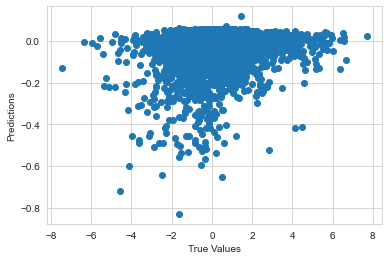

<IPython.core.display.Javascript object>

In [203]:
plot_prediction(y_test, y_pred)

These values are best than other models.

In [193]:
# Final results on testset
df_final = pd.concat(
    [lr_final, elast_final, xgb_final, xgb_final_1], axis=0
).reset_index(drop=True)
df_final

model        X_data      RMSE  Pearson_coef
0  LinearRegression    X_up_pca85  0.897627      0.094731
1        ElasticNet      X_scaled  0.897163      0.098006
2      XGBRegressor  X_scal_pca85  0.898528      0.072302
3      XGBRegressor       X_pca85  0.896879      0.103205

<IPython.core.display.Javascript object>

In [194]:
# Save df
joblib.dump(df_final, "./Data/df_final.joblib")

['./Data/df_final.joblib']

<IPython.core.display.Javascript object>

## Conv1D neuronal network
We are going to test with Conv1D, refering to this kernel : https://www.kaggle.com/code/kmkarakaya/1-dimensional-convolution-conv1d-for-regression/notebook

Conv1D layer expects input shape in 3D as

[batch_size, time_steps, input_dimension]

In [12]:
sample_size = X_train.shape[0]  # number of samples in train set
time_steps = X_train.shape[1]  # number of features in train set
input_dimension = 1  # each feature is represented by 1 number

X_train_reshaped = X_train.reshape(sample_size, time_steps, input_dimension)
print("After reshape train data set shape:\n", X_train_reshaped.shape)
print("1 Sample shape:\n", X_train_reshaped[0].shape)

After reshape train data set shape:
 (140000, 300, 1)
1 Sample shape:
 (300, 1)


<IPython.core.display.Javascript object>

In [13]:
# Reshape X_test
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print("After reshape test data set shape:\n", X_test_reshaped.shape)
print("1 Sample shape:\n", X_test_reshaped[0].shape)

After reshape test data set shape:
 (17070, 300, 1)
1 Sample shape:
 (300, 1)


<IPython.core.display.Javascript object>

In [16]:
toto = tf.convert_to_tensor(X_train_reshaped)
xsum = tf.reduce_sum(toto, axis=-2)
xsum

<tf.Tensor: shape=(140000, 1), dtype=float32, numpy=
array([[  8.66685   ],
       [ 31.098358  ],
       [ 25.590534  ],
       ...,
       [  0.22849834],
       [-59.374348  ],
       [ 12.495668  ]], dtype=float32)>

<IPython.core.display.Javascript object>

In [21]:
titi = tf.convert_to_tensor(y_train)
titi

<tf.Tensor: shape=(140000,), dtype=float32, numpy=
array([ 0.6858472 ,  0.586187  ,  1.0766649 , ...,  0.02466151,
        0.04701435, -0.50904346], dtype=float32)>

<IPython.core.display.Javascript object>

Let's create a model :

In [19]:
def build_conv1D_model(train_data_reshaped):
    n_timesteps = train_data_reshaped.shape[1]  # 300
    n_features = train_data_reshaped.shape[2]  # 1
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps, n_features)))
    model.add(
        keras.layers.Conv1D(
            filters=64, kernel_size=7, activation="relu", name="Conv1D_1"
        )
    )
    model.add(keras.layers.Dropout(0.5))
    model.add(
        keras.layers.Conv1D(
            filters=32, kernel_size=3, activation="relu", name="Conv1D_2"
        )
    )

    model.add(
        keras.layers.Conv1D(
            filters=16, kernel_size=2, activation="relu", name="Conv1D_3"
        )
    )

    model.add(keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(32, activation="relu", name="Dense_1"))
    model.add(keras.layers.Dense(n_features, name="Dense_2"))

    optimizer = tf.keras.optimizers.Adam(0.001)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")

    model.compile(loss="mse", optimizer=optimizer, metrics=["mse", "mae", rmse])
    return model

<IPython.core.display.Javascript object>

In [20]:
model_conv1D = build_conv1D_model(X_train_reshaped)
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 294, 64)           512       
_________________________________________________________________
dropout (Dropout)            (None, 294, 64)           0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 292, 32)           6176      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 291, 16)           1040      
_________________________________________________________________
MaxPooling1D (MaxPooling1D)  (None, 145, 16)           0         
_________________________________________________________________
flatten (Flatten)            (None, 2320)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 32)               

<IPython.core.display.Javascript object>

#### Checkpoint and earlystop

In [23]:
# File to save model
model_file_name = "./Models/Conv1D_1.tf"

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file_name, 
                                             monitor="val_rmse", 
                                             mode="min", 
                                             save_best_only=True, 
                                             save_weights_only=True, 
                                             verbose = 1)

early_stop = keras.callbacks.EarlyStopping(monitor="val_rmse", 
                                           patience=5, 
                                           verbose = 1, 
                                           restore_best_weights = True)

<IPython.core.display.Javascript object>

In [24]:
%%time
EPOCHS=30
BATCH_SIZE = 4096

history_1 = model_conv1D.fit(x=X_train_reshaped, 
                             y=y_train, 
                             epochs=EPOCHS, 
                             shuffle= False, 
                             batch_size=BATCH_SIZE, 
                             validation_split=0.2, 
                             callbacks=[checkpoint, early_stop], 
                             verbose=1)

2022-04-01 10:22:14.542994: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
28/28 [==============================] - 43s 1s/step - loss: 0.8464 - mse: 0.8464 - mae: 0.6412 - rmse: 0.9200 - val_loss: 0.8242 - val_mse: 0.8242 - val_mae: 0.6113 - val_rmse: 0.9079

Epoch 00001: val_rmse improved from inf to 0.90788, saving model to ./Models/Conv1D_1.tf
Epoch 2/30
28/28 [==============================] - 40s 1s/step - loss: 0.8321 - mse: 0.8321 - mae: 0.6315 - rmse: 0.9122 - val_loss: 0.8233 - val_mse: 0.8233 - val_mae: 0.6115 - val_rmse: 0.9074

Epoch 00002: val_rmse improved from 0.90788 to 0.90738, saving model to ./Models/Conv1D_1.tf
Epoch 3/30
28/28 [==============================] - 42s 2s/step - loss: 0.8312 - mse: 0.8312 - mae: 0.6318 - rmse: 0.9117 - val_loss: 0.8222 - val_mse: 0.8222 - val_mae: 0.6114 - val_rmse: 0.9067

Epoch 00003: val_rmse improved from 0.90738 to 0.90674, saving model to ./Models/Conv1D_1.tf
Epoch 4/30
28/28 [==============================] - 41s 1s/step - loss: 0.8301 - mse: 0.8301 - mae: 0.6316 - rmse: 0.9111 - val_loss: 

<IPython.core.display.Javascript object>

In [25]:
# Convert the history.history dict to a pandas DataFrame 
hist_df_1 = pd.DataFrame(history_1.history) 

# Save to csv
hist_1_csv_file = "./Models/history_1.csv"
with open(hist_1_csv_file, mode='w') as f:
    hist_df_1.to_csv(f)

<IPython.core.display.Javascript object>

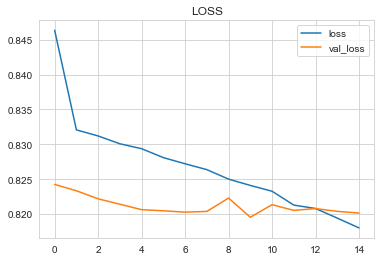

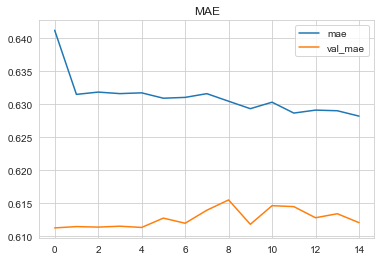

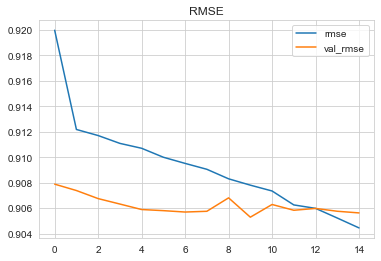

<IPython.core.display.Javascript object>

In [26]:
# Plot metrics
for metric in ["loss", "mae", "rmse"]:
    pd.DataFrame(history_1.history, columns=[metric, f"val_{metric}"]).plot()
    plt.title(metric.upper())
    plt.show()

In [42]:
model_conv1D.load_weights(model_file_name)
model = "Conv1D_1"
[loss_test, mse_test, mae_test, rmse_test] = model_conv1D.evaluate(X_test_reshaped, y_test, verbose=1)

534/534 [==============================] - 2s 3ms/step - loss: 0.8050 - mse: 0.8050 - mae: 0.5946 - rmse: 0.8972


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
[model, loss_test, mse_test, mae_test, rmse_test]

['Conv1D_1',
 0.8050459027290344,
 0.8050459027290344,
 0.5946230888366699,
 0.8972434997558594]

<IPython.core.display.Javascript object>

In [43]:
pearson_score = pearsonr(model_conv1D.predict(X_test_reshaped).reshape(-1), y_test)[0]
pearson_score

0.09422102715881768

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [48]:
df_test_1 = pd.DataFrame([[model, loss_test, mse_test, mae_test, rmse_test, pearson_score]], columns = ["model", "loss_test", "mse_test","mae_test", "rmse_test","pearson_score" ])
df_test_1.insert(loc=1, column="epochs", value=len(hist_df_1))
df_test_1

model  epochs  loss_test  mse_test  mae_test  rmse_test  pearson_score
0  Conv1D_1      15   0.805046  0.805046  0.594623   0.897243       0.094221

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
len(hist_df_1)

15

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Let's go further in training.

In [49]:
def build_conv1D_model(train_data_reshaped):
    n_timesteps = train_data_reshaped.shape[1]  # 300
    n_features = train_data_reshaped.shape[2]  # 1
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps, n_features)))
    model.add(
        keras.layers.Conv1D(
            filters=64, kernel_size=7, activation="relu", name="Conv1D_1"
        )
    )
    model.add(keras.layers.Dropout(0.5))
    model.add(
        keras.layers.Conv1D(
            filters=32, kernel_size=3, activation="relu", name="Conv1D_2"
        )
    )

    model.add(
        keras.layers.Conv1D(
            filters=16, kernel_size=2, activation="relu", name="Conv1D_3"
        )
    )

    model.add(keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(32, activation="relu", name="Dense_1"))
    model.add(keras.layers.Dense(n_features, name="Dense_2"))

    optimizer = tf.keras.optimizers.Adam(0.001)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")

    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", rmse])
    return model

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
model_conv1D = build_conv1D_model(X_train_reshaped)
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 294, 64)           512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 294, 64)           0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 292, 32)           6176      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 291, 16)           1040      
_________________________________________________________________
MaxPooling1D (MaxPooling1D)  (None, 145, 16)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2320)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 32)               

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
#### Checkpoint and earlystop

# File to save model
model_file_name = "./Models/Conv1D_1_1.tf"

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file_name, 
                                             monitor="val_rmse", 
                                             mode="min", 
                                             save_best_only=True, 
                                             save_weights_only=True, 
                                             verbose = 1)

early_stop = keras.callbacks.EarlyStopping(monitor="val_rmse", 
                                           patience=10, 
                                           verbose = 1, 
                                           restore_best_weights = True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
%%time

EPOCHS=50
BATCH_SIZE = 4096

history_1_1 = model_conv1D.fit(x=X_train_reshaped, 
                             y=y_train, 
                             epochs=EPOCHS, 
                             shuffle= False, 
                             batch_size=BATCH_SIZE, 
                             validation_split=0.2, 
                             callbacks=[checkpoint, early_stop], 
                             verbose=1)

Epoch 1/50
28/28 [==============================] - 59s 2s/step - loss: 0.8432 - mae: 0.6385 - rmse: 0.9183 - val_loss: 0.8244 - val_mae: 0.6119 - val_rmse: 0.9080

Epoch 00001: val_rmse improved from inf to 0.90798, saving model to ./Models/Conv1D_1_1.tf
Epoch 2/50
28/28 [==============================] - 55s 2s/step - loss: 0.8323 - mae: 0.6314 - rmse: 0.9123 - val_loss: 0.8234 - val_mae: 0.6116 - val_rmse: 0.9074

Epoch 00002: val_rmse improved from 0.90798 to 0.90741, saving model to ./Models/Conv1D_1_1.tf
Epoch 3/50
28/28 [==============================] - 58s 2s/step - loss: 0.8311 - mae: 0.6319 - rmse: 0.9117 - val_loss: 0.8219 - val_mae: 0.6117 - val_rmse: 0.9066

Epoch 00003: val_rmse improved from 0.90741 to 0.90659, saving model to ./Models/Conv1D_1_1.tf
Epoch 4/50
28/28 [==============================] - 55s 2s/step - loss: 0.8285 - mae: 0.6312 - rmse: 0.9102 - val_loss: 0.8211 - val_mae: 0.6133 - val_rmse: 0.9062

Epoch 00004: val_rmse improved from 0.90659 to 0.90616, sav

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
# Convert the history.history dict to a pandas DataFrame 
hist_df_1_1 = pd.DataFrame(history_1_1.history) 

# Save to csv
hist_1_1_csv_file = "./Models/history_1_1.csv"
with open(hist_1_1_csv_file, mode='w') as f:
    hist_df_1_1.to_csv(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

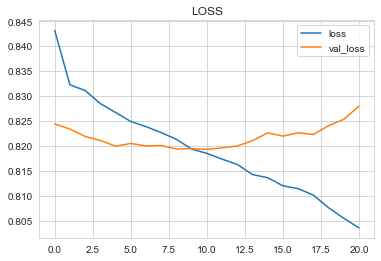

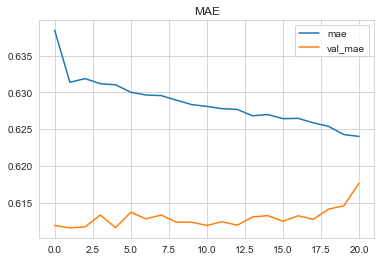

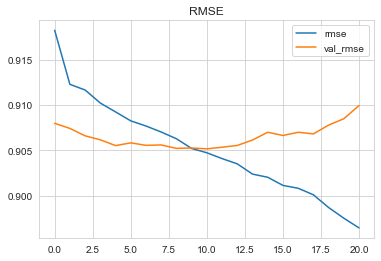

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
# Plot metrics
for metric in ["loss", "mae", "rmse"]:
    pd.DataFrame(history_1_1.history, 
                 columns=[metric, f"val_{metric}"]).plot()
    plt.title(metric.upper())
    plt.show()

In [56]:
model_conv1D.load_weights(model_file_name)
model = "Conv1D_1_1"
[loss_test, mae_test, rmse_test] = model_conv1D.evaluate(X_test_reshaped, y_test, verbose=1)

534/534 [==============================] - 2s 3ms/step - loss: 0.8069 - mae: 0.5966 - rmse: 0.8982


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [57]:
pearson_score = pearsonr(
    model_conv1D.predict(X_test_reshaped).reshape(-1), 
    y_test)[0]

df_test_1_1 = pd.DataFrame(
    [[model, loss_test, mae_test, rmse_test, pearson_score]], 
    columns = [
        "model", 
        "loss_test", 
        "mae_test", 
        "rmse_test",
        "pearson_score"
    ]
)
df_test_1_1.insert(loc=1, 
                   column="epochs", 
                   value=len(hist_df_1_1))
df_test_1_1

model  epochs  loss_test  mae_test  rmse_test  pearson_score
0  Conv1D_1_1      21   0.806851  0.596615   0.898249       0.084132

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Results are worse with a longer training.

In [64]:
df_test_conv = pd.concat([df_test_1, df_test_1_1], axis=0).reset_index(drop=True)
df_test_conv.drop(["mse_test"], axis=1, inplace=True)
# Save df
joblib.dump(df_test_conv, "./Data/df_test_conv.joblib")

['./Data/df_test_conv.joblib']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Let's see how model perform on X_scaled.

In [66]:
# Reshape X_scaled
X_scaled_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Scaled X_test
X_test_scaled = robust_scal.transform(X_test)
X_test_sc_reshaped = X_test_scaled.reshape(
    X_test_scaled.shape[0], X_test_scaled.shape[1], 1
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [67]:
model_conv1D = build_conv1D_model(X_scaled_reshaped)
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 294, 64)           512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 294, 64)           0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 292, 32)           6176      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 291, 16)           1040      
_________________________________________________________________
MaxPooling1D (MaxPooling1D)  (None, 145, 16)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2320)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 32)               

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [68]:
# File to save model
model_file_name = "./Models/Conv1D_scal_1.tf"

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file_name, 
                                             monitor="val_rmse", 
                                             mode="min", 
                                             save_best_only=True, 
                                             save_weights_only=True, 
                                             verbose = 1)

early_stop = keras.callbacks.EarlyStopping(monitor="val_rmse", 
                                           patience=5, 
                                           verbose = 1, 
                                           restore_best_weights = True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [69]:
%%time

EPOCHS=50
BATCH_SIZE = 4096

history_scal_1 = model_conv1D.fit(x=X_scaled_reshaped, 
                             y=y_train, 
                             epochs=EPOCHS, 
                             shuffle= False, 
                             batch_size=BATCH_SIZE, 
                             validation_split=0.2, 
                             callbacks=[checkpoint, early_stop], 
                             verbose=1)

Epoch 1/50
28/28 [==============================] - 60s 2s/step - loss: 0.9454 - mae: 0.6710 - rmse: 0.9723 - val_loss: 0.8234 - val_mae: 0.6120 - val_rmse: 0.9074

Epoch 00001: val_rmse improved from inf to 0.90739, saving model to ./Models/Conv1D_scal_1.tf
Epoch 2/50
28/28 [==============================] - 57s 2s/step - loss: 0.8376 - mae: 0.6362 - rmse: 0.9152 - val_loss: 0.8239 - val_mae: 0.6124 - val_rmse: 0.9077

Epoch 00002: val_rmse did not improve from 0.90739
Epoch 3/50
28/28 [==============================] - 57s 2s/step - loss: 0.8338 - mae: 0.6347 - rmse: 0.9131 - val_loss: 0.8227 - val_mae: 0.6114 - val_rmse: 0.9070

Epoch 00003: val_rmse improved from 0.90739 to 0.90704, saving model to ./Models/Conv1D_scal_1.tf
Epoch 4/50
28/28 [==============================] - 53s 2s/step - loss: 0.8327 - mae: 0.6336 - rmse: 0.9125 - val_loss: 0.8220 - val_mae: 0.6109 - val_rmse: 0.9066

Epoch 00004: val_rmse improved from 0.90704 to 0.90665, saving model to ./Models/Conv1D_scal_1.tf

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [70]:
# Convert the history.history dict to a pandas DataFrame 
hist_df_scal_1 = pd.DataFrame(history_scal_1.history) 

# Save to csv
hist_scal_1_csv_file = "./Models/history_scal_1.csv"
with open(hist_scal_1_csv_file, mode='w') as f:
    hist_df_scal_1.to_csv(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

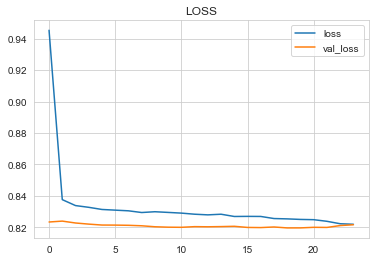

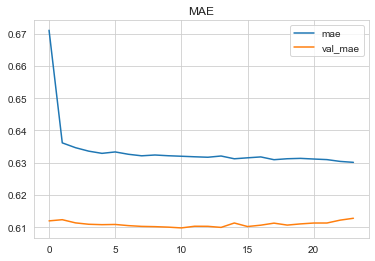

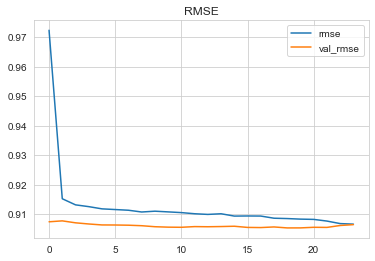

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
# Plot metrics
for metric in ["loss", "mae", "rmse"]:
    pd.DataFrame(history_scal_1.history, 
                 columns=[metric, f"val_{metric}"]).plot()
    plt.title(metric.upper())
    plt.show()

In [72]:
model_conv1D.load_weights(model_file_name)
model = "Conv1D_scal_1"
[loss_test, mae_test, rmse_test] = model_conv1D.evaluate(X_test_sc_reshaped, y_test, verbose=1)

534/534 [==============================] - 2s 4ms/step - loss: 0.8061 - mae: 0.5941 - rmse: 0.8978


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [73]:
pearson_score = pearsonr(
    model_conv1D.predict(X_test_sc_reshaped).reshape(-1), 
    y_test)[0]

df_test_scal_1 = pd.DataFrame(
    [[model, loss_test, mae_test, rmse_test, pearson_score]], 
    columns = [
        "model", 
        "loss_test", 
        "mae_test", 
        "rmse_test",
        "pearson_score"
    ]
)
df_test_scal_1.insert(loc=1, 
                   column="epochs", 
                   value=len(hist_df_scal_1))
df_test_scal_1

model  epochs  loss_test  mae_test  rmse_test  pearson_score
0  Conv1D_scal_1      24   0.806059  0.594119   0.897808       0.084341

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [74]:
df_test_conv = pd.concat([df_test_conv, df_test_scal_1], axis=0).reset_index(drop=True)

# Save df
joblib.dump(df_test_conv, "./Data/df_test_conv.joblib")

['./Data/df_test_conv.joblib']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [75]:
# Reshape X_pca85
X_pca85_reshaped = X_pca85.reshape(X_pca85.shape[0], X_pca85.shape[1], 1)

# PCA X_test
X_pca85_test = pca_85.transform(X_test)
X_pca85_test_reshaped = X_pca85_test.reshape(
    X_pca85_test.shape[0], X_pca85_test.shape[1], 1
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [76]:
model_conv1D = build_conv1D_model(X_pca85_reshaped)
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 119, 64)           512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 119, 64)           0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 117, 32)           6176      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 116, 16)           1040      
_________________________________________________________________
MaxPooling1D (MaxPooling1D)  (None, 58, 16)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 928)               0         
_________________________________________________________________
Dense_1 (Dense)              (None, 32)               

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [77]:
# File to save model
model_file_name = "./Models/Conv1D_pca_1.tf"

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=model_file_name,
    monitor="val_rmse",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_rmse", patience=5, verbose=1, restore_best_weights=True
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [79]:
%%time

EPOCHS=50
BATCH_SIZE = 4096

history_pca_1 = model_conv1D.fit(x=X_pca85_reshaped, 
                             y=y_train, 
                             epochs=EPOCHS, 
                             shuffle= False, 
                             batch_size=BATCH_SIZE, 
                             validation_split=0.2, 
                             callbacks=[checkpoint, early_stop], 
                             verbose=1)

Epoch 1/50
28/28 [==============================] - 21s 730ms/step - loss: 0.8312 - mae: 0.6306 - rmse: 0.9117 - val_loss: 0.8232 - val_mae: 0.6123 - val_rmse: 0.9073

Epoch 00001: val_rmse improved from 0.90778 to 0.90732, saving model to ./Models/Conv1D_pca_1.tf
Epoch 2/50
28/28 [==============================] - 21s 743ms/step - loss: 0.8310 - mae: 0.6319 - rmse: 0.9116 - val_loss: 0.8228 - val_mae: 0.6133 - val_rmse: 0.9071

Epoch 00002: val_rmse improved from 0.90732 to 0.90709, saving model to ./Models/Conv1D_pca_1.tf
Epoch 3/50
28/28 [==============================] - 21s 746ms/step - loss: 0.8299 - mae: 0.6321 - rmse: 0.9110 - val_loss: 0.8217 - val_mae: 0.6125 - val_rmse: 0.9065

Epoch 00003: val_rmse improved from 0.90709 to 0.90646, saving model to ./Models/Conv1D_pca_1.tf
Epoch 4/50
28/28 [==============================] - 22s 780ms/step - loss: 0.8290 - mae: 0.6320 - rmse: 0.9105 - val_loss: 0.8214 - val_mae: 0.6134 - val_rmse: 0.9063

Epoch 00004: val_rmse improved from 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [80]:
# Convert the history.history dict to a pandas DataFrame 
hist_df_pca_1 = pd.DataFrame(history_pca_1.history) 

# Save to csv
hist_pca_1_csv_file = "./Models/history_pca_1.csv"
with open(hist_pca_1_csv_file, mode='w') as f:
    hist_df_pca_1.to_csv(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

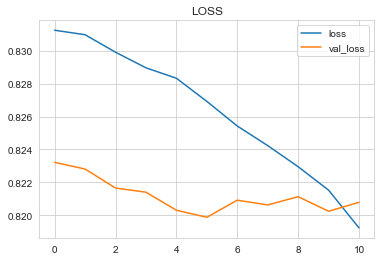

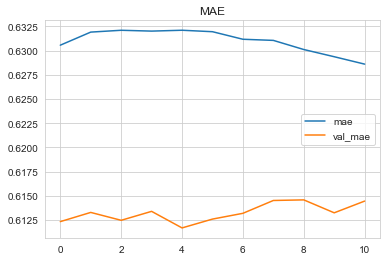

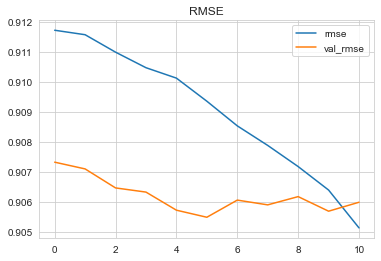

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [81]:
# Plot metrics
for metric in ["loss", "mae", "rmse"]:
    pd.DataFrame(history_pca_1.history, columns=[metric, f"val_{metric}"]).plot()
    plt.title(metric.upper())
    plt.show()

In [82]:
model_conv1D.load_weights(model_file_name)
model = "Conv1D_pca_1"
[loss_test, mae_test, rmse_test] = model_conv1D.evaluate(X_pca85_test_reshaped, y_test, verbose=1)

534/534 [==============================] - 1s 2ms/step - loss: 0.8071 - mae: 0.5960 - rmse: 0.8984


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [83]:
pearson_score = pearsonr(
    model_conv1D.predict(X_pca85_test_reshaped).reshape(-1), 
    y_test)[0]

df_test_pca_1 = pd.DataFrame(
    [[model, loss_test, mae_test, rmse_test, pearson_score]], 
    columns = [
        "model", 
        "loss_test", 
        "mae_test", 
        "rmse_test",
        "pearson_score"
    ]
)
df_test_pca_1.insert(loc=1, 
                   column="epochs", 
                   value=len(hist_df_pca_1))
df_test_pca_1

model  epochs  loss_test  mae_test  rmse_test  pearson_score
0  Conv1D_pca_1      11   0.807132  0.596023   0.898405       0.074178

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [84]:
df_test_conv = pd.concat([df_test_conv, df_test_pca_1], axis=0).reset_index(drop=True)

# Save df
joblib.dump(df_test_conv, "./Data/df_test_conv.joblib")

['./Data/df_test_conv.joblib']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

So let's change our model, especially regarding activation

In [97]:
def build_conv1D_model_2(train_data_reshaped):
    n_timesteps = train_data_reshaped.shape[1]  # 300
    n_features = train_data_reshaped.shape[2]  # 1
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps, n_features)))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=7, name="Conv1D_1"))
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_1"))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Conv1D(filters=32, kernel_size=3, name="Conv1D_2"))
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_2"))
    model.add(keras.layers.Conv1D(filters=16, kernel_size=2, name="Conv1D_3"))
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_3"))
    model.add(keras.layers.MaxPooling1D(pool_size=2, name="MaxPooling1D"))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(32, activation="swish", name="Dense_1"))
    model.add(keras.layers.Dense(n_features, name="Dense_2"))

    optimizer = tf.keras.optimizers.Adam(0.001)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")

    model.compile(loss="mse", optimizer=optimizer, metrics=["mse", "mae", rmse])
    return model

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [98]:
model_conv1D = build_conv1D_model_2(X_train_reshaped)
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 294, 64)           512       
_________________________________________________________________
LeakyReLU_1 (LeakyReLU)      (None, 294, 64)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 294, 64)           0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 292, 32)           6176      
_________________________________________________________________
LeakyReLU_2 (LeakyReLU)      (None, 292, 32)           0         
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 291, 16)           1040      
_________________________________________________________________
LeakyReLU_3 (LeakyReLU)      (None, 291, 16)          

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [99]:
# File to save model
model_file_name = "./Models/Conv1D_2.tf"

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=model_file_name,
    monitor="val_rmse",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_rmse", patience=5, verbose=1, restore_best_weights=True
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [100]:
%%time

EPOCHS=50
BATCH_SIZE = 4096

history_2 = model_conv1D.fit(x=X_train_reshaped, 
                             y=y_train, 
                             epochs=EPOCHS, 
                             shuffle= False, 
                             batch_size=BATCH_SIZE, 
                             validation_split=0.2, 
                             callbacks=[checkpoint, early_stop], 
                             verbose=1)

Epoch 1/50
28/28 [==============================] - 60s 2s/step - loss: 0.8809 - mse: 0.8809 - mae: 0.6591 - rmse: 0.9386 - val_loss: 0.8244 - val_mse: 0.8244 - val_mae: 0.6187 - val_rmse: 0.9079

Epoch 00001: val_rmse improved from inf to 0.90794, saving model to ./Models/Conv1D_2.tf
Epoch 2/50
28/28 [==============================] - 54s 2s/step - loss: 0.8297 - mse: 0.8297 - mae: 0.6304 - rmse: 0.9109 - val_loss: 0.8241 - val_mse: 0.8241 - val_mae: 0.6200 - val_rmse: 0.9078

Epoch 00002: val_rmse improved from 0.90794 to 0.90781, saving model to ./Models/Conv1D_2.tf
Epoch 3/50
28/28 [==============================] - 56s 2s/step - loss: 0.8276 - mse: 0.8276 - mae: 0.6311 - rmse: 0.9097 - val_loss: 0.8207 - val_mse: 0.8207 - val_mae: 0.6153 - val_rmse: 0.9059

Epoch 00003: val_rmse improved from 0.90781 to 0.90594, saving model to ./Models/Conv1D_2.tf
Epoch 4/50
28/28 [==============================] - 57s 2s/step - loss: 0.8260 - mse: 0.8260 - mae: 0.6312 - rmse: 0.9088 - val_loss: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [101]:
# Convert the history.history dict to a pandas DataFrame 
hist_df_2 = pd.DataFrame(history_2.history) 

# Save to csv
hist_2_csv_file = "./Models/history_2.csv"
with open(hist_2_csv_file, mode='w') as f:
    hist_df_2.to_csv(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

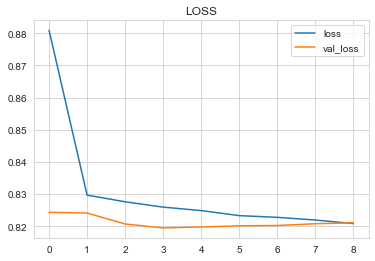

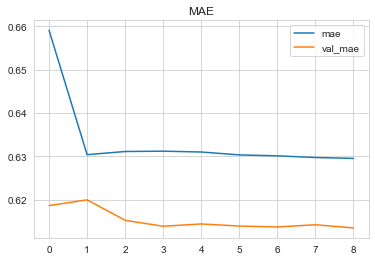

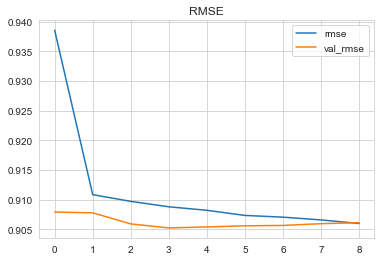

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [102]:
# Plot metrics
for metric in ["loss", "mae", "rmse"]:
    pd.DataFrame(history_2.history, columns=[metric, f"val_{metric}"]).plot()
    plt.title(metric.upper())
    plt.show()

In [104]:
model_conv1D.load_weights(model_file_name)
model = "Conv1D_2"
[loss_test, mse_test, mae_test, rmse_test] = model_conv1D.evaluate(
    X_test_reshaped, y_test, verbose=1
)

534/534 [==============================] - 2s 3ms/step - loss: 0.8063 - mse: 0.8063 - mae: 0.5976 - rmse: 0.8979


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [105]:
pearson_score = pearsonr(
    model_conv1D.predict(X_test_reshaped).reshape(-1), 
    y_test)[0]

df_test_2 = pd.DataFrame(
    [[model, loss_test, mae_test, rmse_test, pearson_score]], 
    columns = [
        "model", 
        "loss_test", 
        "mae_test", 
        "rmse_test",
        "pearson_score"
    ]
)
df_test_2.insert(loc=1, 
                   column="epochs", 
                   value=len(hist_df_2))
df_test_2

model  epochs  loss_test  mae_test  rmse_test  pearson_score
0  Conv1D_2       9   0.806295  0.597559   0.897939       0.085613

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [106]:
df_test_conv = pd.concat([df_test_conv, df_test_2], axis=0).reset_index(drop=True)

# Save df
joblib.dump(df_test_conv, "./Data/df_test_conv.joblib")

['./Data/df_test_conv.joblib']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Let's try this model with less DenseLayers :
https://www.kaggle.com/code/ghostcxs/prediction-including-spatial-info-with-conv1d

In [191]:
def build_conv1D_model_3(train_data_reshaped):
    n_timesteps = train_data_reshaped.shape[1]  # 300
    n_features = train_data_reshaped.shape[2]  # 1
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps, n_features)))

    # Convolution 1
    model.add(
        keras.layers.Conv1D(
            filters=64, kernel_size=4, strides=1, padding="same", name="Conv1D_1"
        )
    )
    #model.add(keras.layers.BatchNormalization(name="BatchNormalization_1"))
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_1"))
    model.add(keras.layers.Dropout(0.5))
    # Convolution 2
    model.add(
        keras.layers.Conv1D(filters=16, kernel_size=8, strides=3, name="Conv1D_2")
    )
    #model.add(keras.layers.BatchNormalization(name="BatchNormalization_2"))
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_2"))

    # Convolution 3
    model.add(
        keras.layers.Conv1D(
            filters=16, kernel_size=3, strides=1, name="Conv1D_3"
        )
    )
    #model.add(keras.layers.BatchNormalization(name="BatchNormalization_3"))
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_3"))

    # Convolution 4
    model.add(
        keras.layers.Conv1D(
            filters=32, kernel_size=4, strides=3,  padding="same",name="Conv1D_4"
        )
    )
    #model.add(keras.layers.BatchNormalization(name="BatchNormalization_4"))
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_4"))

    # Convolution 5
    model.add(
        keras.layers.Conv1D(
            filters=64, kernel_size=4, strides=4, padding="same", name="Conv1D_5"
        )
    )
    #model.add(keras.layers.BatchNormalization(name="BatchNormalization_5"))
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_5"))

    # Flatten and Dense
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation="swish", name="Dense_2"))
    #model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(32, activation="swish", name="Dense_3"))
    #model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(n_features, name="Dense_4"))

    optimizer = tf.keras.optimizers.Adam(0.001)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")

    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", rmse])
    return model

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [192]:
model_conv1D = build_conv1D_model_3(X_train_reshaped)
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 300, 64)           320       
_________________________________________________________________
LeakyReLU_1 (LeakyReLU)      (None, 300, 64)           0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 300, 64)           0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 98, 16)            8208      
_________________________________________________________________
LeakyReLU_2 (LeakyReLU)      (None, 98, 16)            0         
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 96, 16)            784       
_________________________________________________________________
LeakyReLU_3 (LeakyReLU)      (None, 96, 16)           

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [193]:
# File to save model
model_file_name = "./Models/Conv1D_3.tf"

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=model_file_name,
    monitor="val_rmse",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_rmse", patience=5, verbose=1, restore_best_weights=True
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [194]:
%%time

EPOCHS=30
BATCH_SIZE = 4096

history_3 = model_conv1D.fit(x=X_train_reshaped, 
                             y=y_train, 
                             epochs=EPOCHS, 
                             shuffle= False, 
                             batch_size=BATCH_SIZE, 
                             validation_split=0.2, 
                             callbacks=[checkpoint, early_stop], 
                             verbose=1)

Epoch 1/30
28/28 [==============================] - 48s 2s/step - loss: 0.8289 - mae: 0.6316 - rmse: 0.9105 - val_loss: 0.8198 - val_mae: 0.6122 - val_rmse: 0.9054

Epoch 00001: val_rmse improved from inf to 0.90543, saving model to ./Models/Conv1D_3.tf
Epoch 2/30
28/28 [==============================] - 46s 2s/step - loss: 0.8254 - mae: 0.6308 - rmse: 0.9085 - val_loss: 0.8190 - val_mae: 0.6120 - val_rmse: 0.9050

Epoch 00002: val_rmse improved from 0.90543 to 0.90496, saving model to ./Models/Conv1D_3.tf
Epoch 3/30
28/28 [==============================] - 46s 2s/step - loss: 0.8226 - mae: 0.6295 - rmse: 0.9070 - val_loss: 0.8189 - val_mae: 0.6119 - val_rmse: 0.9049

Epoch 00003: val_rmse improved from 0.90496 to 0.90490, saving model to ./Models/Conv1D_3.tf
Epoch 4/30
28/28 [==============================] - 46s 2s/step - loss: 0.8199 - mae: 0.6289 - rmse: 0.9055 - val_loss: 0.8192 - val_mae: 0.6117 - val_rmse: 0.9051

Epoch 00004: val_rmse did not improve from 0.90490
Epoch 5/30
28/

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [198]:
# Convert the history.history dict to a pandas DataFrame
hist_df_3 = pd.DataFrame(history_3.history)

# Save to csv
hist_3_csv_file = "./Models/history_3.csv"
with open(hist_3_csv_file, mode="w") as f:
    hist_df_3.to_csv(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

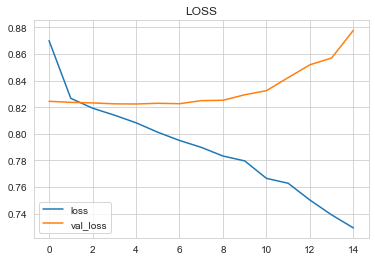

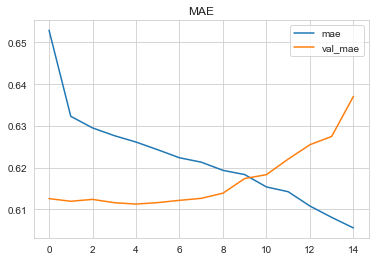

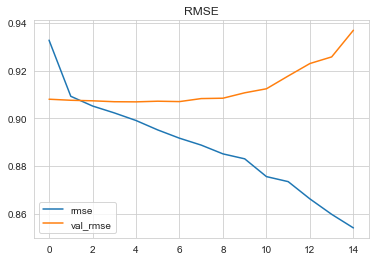

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [120]:
#OLD
# Plot metrics
for metric in ["loss", "mae", "rmse"]:
    pd.DataFrame(history_3.history, columns=[metric, f"val_{metric}"]).plot()
    plt.title(metric.upper())
    plt.show()

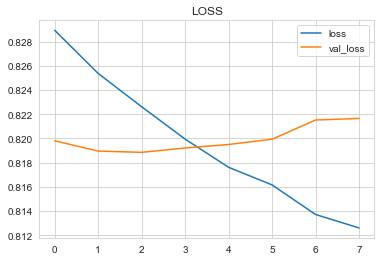

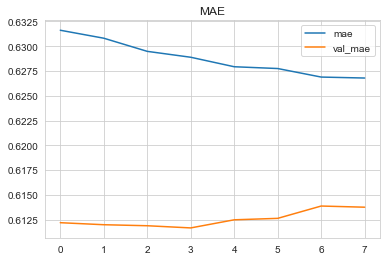

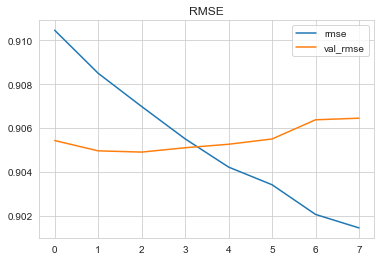

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [195]:
# Plot metrics
for metric in ["loss", "mae", "rmse"]:
    pd.DataFrame(history_3.history, columns=[metric, f"val_{metric}"]).plot()
    plt.title(metric.upper())
    plt.show()

In [196]:
model_conv1D.load_weights(model_file_name)
model = "Conv1D_3"
[loss_test, mae_test, rmse_test] = model_conv1D.evaluate(
    X_test_reshaped, y_test, verbose=1
)

534/534 [==============================] - 1s 3ms/step - loss: 0.8051 - mae: 0.5956 - rmse: 0.8973


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [201]:
pearson_score = pearsonr(model_conv1D.predict(X_test_reshaped).reshape(-1), y_test)[0]

df_test_3 = pd.DataFrame(
    [[model, loss_test, mae_test, rmse_test, pearson_score]],
    columns=["model", "loss_test", "mae_test", "rmse_test", "pearson_score"],
)
df_test_3.insert(loc=1, column="epochs", value=len(hist_df_3))
df_test_3

model  epochs  loss_test  mae_test  rmse_test  pearson_score
0  Conv1D_3       8   0.805138  0.595649   0.897295       0.089078

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [202]:
df_test_conv = pd.concat([df_test_conv, df_test_3], axis=0).reset_index(drop=True)

# Save df
joblib.dump(df_test_conv, "./Data/df_test_conv.joblib")

['./Data/df_test_conv.joblib']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [204]:
df_test_conv = df_test_conv.drop(5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [205]:
# Save df
joblib.dump(df_test_conv, "./Data/df_test_conv.joblib")

['./Data/df_test_conv.joblib']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [206]:
df_test_conv

model  epochs  loss_test  mae_test  rmse_test  pearson_score
0       Conv1D_1      15   0.805046  0.594623   0.897243       0.094221
1     Conv1D_1_1      21   0.806851  0.596615   0.898249       0.084132
2  Conv1D_scal_1      24   0.806059  0.594119   0.897808       0.084341
3   Conv1D_pca_1      11   0.807132  0.596023   0.898405       0.074178
4       Conv1D_2       9   0.806295  0.597559   0.897939       0.085613
6       Conv1D_3       8   0.805138  0.595649   0.897295       0.089078

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [207]:
def build_conv1D_model_4(train_data_reshaped):
    n_timesteps = train_data_reshaped.shape[1]  # 300
    n_features = train_data_reshaped.shape[2]  # 1
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps, n_features)))

    # Convolution 1
    model.add(
        keras.layers.Conv1D(
            filters=64, kernel_size=4, strides=1, padding="same", name="Conv1D_1"
        )
    )
    # model.add(keras.layers.BatchNormalization(name="BatchNormalization_1"))
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_1"))
    model.add(keras.layers.Dropout(0.5))
    # Convolution 2
    model.add(
        keras.layers.Conv1D(filters=16, kernel_size=8, strides=3, name="Conv1D_2")
    )
    # model.add(keras.layers.BatchNormalization(name="BatchNormalization_2"))
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_2"))

    # Convolution 3
    model.add(
        keras.layers.Conv1D(filters=16, kernel_size=3, strides=1, name="Conv1D_3")
    )
    # model.add(keras.layers.BatchNormalization(name="BatchNormalization_3"))
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_3"))

    # Convolution 4
    model.add(
        keras.layers.Conv1D(
            filters=32, kernel_size=4, strides=3, padding="same", name="Conv1D_4"
        )
    )
    # model.add(keras.layers.BatchNormalization(name="BatchNormalization_4"))
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_4"))

    # Convolution 5
    model.add(
        keras.layers.Conv1D(
            filters=64, kernel_size=4, strides=4, padding="same", name="Conv1D_5"
        )
    )
    # model.add(keras.layers.BatchNormalization(name="BatchNormalization_5"))
    model.add(keras.layers.LeakyReLU(name="LeakyReLU_5"))

    # Flatten and Dense
    model.add(keras.layers.Flatten())
    model.add(
        keras.layers.Dense(
            64, activation="swish", name="Dense_2", kernel_regularizer="l2"
        )
    )
    # model.add(keras.layers.Dropout(0.1))
    model.add(
        keras.layers.Dense(
            32, activation="swish", name="Dense_3", kernel_regularizer="l2"
        )
    )
    # model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(n_features, name="Dense_4"))

    optimizer = tf.keras.optimizers.Adam(0.001)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")

    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", rmse])
    return model

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [208]:
model_conv1D = build_conv1D_model_4(X_train_reshaped)
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 300, 64)           320       
_________________________________________________________________
LeakyReLU_1 (LeakyReLU)      (None, 300, 64)           0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 300, 64)           0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 98, 16)            8208      
_________________________________________________________________
LeakyReLU_2 (LeakyReLU)      (None, 98, 16)            0         
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 96, 16)            784       
_________________________________________________________________
LeakyReLU_3 (LeakyReLU)      (None, 96, 16)           

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [209]:
# File to save model
model_file_name = "./Models/Conv1D_4.tf"

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=model_file_name,
    monitor="val_rmse",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_rmse", patience=5, verbose=1, restore_best_weights=True
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [210]:
%%time

EPOCHS=30
BATCH_SIZE = 4096

history_4 = model_conv1D.fit(x=X_train_reshaped, 
                             y=y_train, 
                             epochs=EPOCHS, 
                             shuffle= False, 
                             batch_size=BATCH_SIZE, 
                             validation_split=0.2, 
                             callbacks=[checkpoint, early_stop], 
                             verbose=1)

Epoch 1/30
28/28 [==============================] - 49s 2s/step - loss: 1.9643 - mae: 0.6320 - rmse: 0.9112 - val_loss: 1.5733 - val_mae: 0.6122 - val_rmse: 0.9059

Epoch 00001: val_rmse improved from inf to 0.90585, saving model to ./Models/Conv1D_4.tf
Epoch 2/30
28/28 [==============================] - 48s 2s/step - loss: 1.3712 - mae: 0.6306 - rmse: 0.9090 - val_loss: 1.1846 - val_mae: 0.6112 - val_rmse: 0.9049

Epoch 00002: val_rmse improved from 0.90585 to 0.90488, saving model to ./Models/Conv1D_4.tf
Epoch 3/30
28/28 [==============================] - 47s 2s/step - loss: 1.0972 - mae: 0.6299 - rmse: 0.9080 - val_loss: 1.0109 - val_mae: 0.6113 - val_rmse: 0.9047

Epoch 00003: val_rmse improved from 0.90488 to 0.90472, saving model to ./Models/Conv1D_4.tf
Epoch 4/30
28/28 [==============================] - 48s 2s/step - loss: 0.9727 - mae: 0.6295 - rmse: 0.9072 - val_loss: 0.9302 - val_mae: 0.6110 - val_rmse: 0.9047

Epoch 00004: val_rmse improved from 0.90472 to 0.90470, saving mo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [211]:
# Convert the history.history dict to a pandas DataFrame
hist_df_4 = pd.DataFrame(history_4.history)

# Save to csv
hist_4_csv_file = "./Models/history_4.csv"
with open(hist_4_csv_file, mode="w") as f:
    hist_df_4.to_csv(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

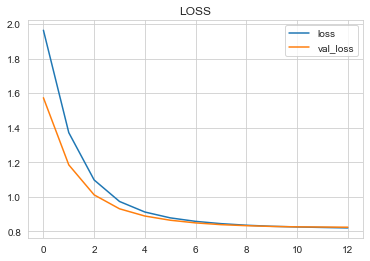

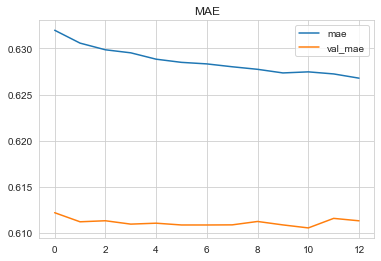

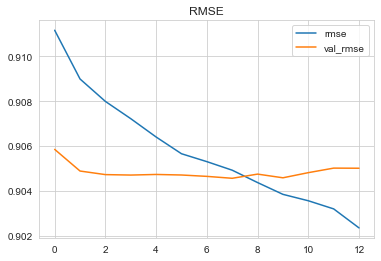

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [212]:
# Plot metrics
for metric in ["loss", "mae", "rmse"]:
    pd.DataFrame(history_4.history, columns=[metric, f"val_{metric}"]).plot()
    plt.title(metric.upper())
    plt.show()

In [213]:
model_conv1D.load_weights(model_file_name)
model = "Conv1D_4"
[loss_test, mae_test, rmse_test] = model_conv1D.evaluate(
    X_test_reshaped, y_test, verbose=1
)

534/534 [==============================] - 1s 2ms/step - loss: 0.8253 - mae: 0.5956 - rmse: 0.8972


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [214]:
pearson_score = pearsonr(model_conv1D.predict(X_test_reshaped).reshape(-1), y_test)[0]

df_test_4 = pd.DataFrame(
    [[model, loss_test, mae_test, rmse_test, pearson_score]],
    columns=["model", "loss_test", "mae_test", "rmse_test", "pearson_score"],
)
df_test_4.insert(loc=1, column="epochs", value=len(hist_df_3))
df_test_4

model  epochs  loss_test  mae_test  rmse_test  pearson_score
0  Conv1D_4       8    0.82527  0.595556    0.89725        0.08966

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [215]:
df_test_conv = pd.concat([df_test_conv, df_test_4], axis=0).reset_index(drop=True)

# Save df
joblib.dump(df_test_conv, "./Data/df_test_conv.joblib")

['./Data/df_test_conv.joblib']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [216]:
df_test_conv

model  epochs  loss_test  mae_test  rmse_test  pearson_score
0       Conv1D_1      15   0.805046  0.594623   0.897243       0.094221
1     Conv1D_1_1      21   0.806851  0.596615   0.898249       0.084132
2  Conv1D_scal_1      24   0.806059  0.594119   0.897808       0.084341
3   Conv1D_pca_1      11   0.807132  0.596023   0.898405       0.074178
4       Conv1D_2       9   0.806295  0.597559   0.897939       0.085613
5       Conv1D_3       8   0.805138  0.595649   0.897295       0.089078
6       Conv1D_4       8   0.825270  0.595556   0.897250       0.089660

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [228]:
df_test_conv.iloc[6, 1] = len(hist_df_4)

# Save df
joblib.dump(df_test_conv, "./Data/df_test_conv.joblib")

['./Data/df_test_conv.joblib']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [217]:
def build_conv1D_model_5(train_data_reshaped):
    n_timesteps = train_data_reshaped.shape[1]  # 300
    n_features = train_data_reshaped.shape[2]  # 1
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps, n_features)))

    # Convolution 1
    model.add(
        keras.layers.Conv1D(
            filters=64,
            kernel_size=4,
            strides=1,
            padding="same",
            activation="relu",
            name="Conv1D_1",
        )
    )
    model.add(keras.layers.Dropout(0.5))

    # Convolution 2
    model.add(
        keras.layers.Conv1D(
            filters=16, kernel_size=8, strides=3, activation="relu", name="Conv1D_2"
        )
    )

    # Convolution 3
    model.add(
        keras.layers.Conv1D(
            filters=16, kernel_size=3, strides=1, activation="relu", name="Conv1D_3"
        )
    )

    # Convolution 4
    model.add(
        keras.layers.Conv1D(
            filters=32,
            kernel_size=4,
            strides=3,
            padding="same",
            activation="relu",
            name="Conv1D_4",
        )
    )

    # Convolution 5
    model.add(
        keras.layers.Conv1D(
            filters=64,
            kernel_size=4,
            strides=4,
            padding="same",
            activation="relu",
            name="Conv1D_5",
        )
    )

    # Flatten and Dense
    model.add(keras.layers.Flatten())
    model.add(
        keras.layers.Dense(
            64, activation="relu", name="Dense_2", kernel_regularizer="l2"
        )
    )
    # model.add(keras.layers.Dropout(0.1))
    model.add(
        keras.layers.Dense(
            32, activation="relu", name="Dense_3", kernel_regularizer="l2"
        )
    )
    # model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(n_features, name="Dense_4"))

    optimizer = tf.keras.optimizers.Adam(0.001)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")

    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", rmse])
    return model

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [218]:
model_conv1D = build_conv1D_model_5(X_train_reshaped)
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 300, 64)           320       
_________________________________________________________________
dropout_63 (Dropout)         (None, 300, 64)           0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 98, 16)            8208      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 96, 16)            784       
_________________________________________________________________
Conv1D_4 (Conv1D)            (None, 32, 32)            2080      
_________________________________________________________________
Conv1D_5 (Conv1D)            (None, 8, 64)             8256      
_________________________________________________________________
flatten_38 (Flatten)         (None, 512)              

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [219]:
# File to save model
model_file_name = "./Models/Conv1D_5.tf"

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=model_file_name,
    monitor="val_rmse",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_rmse", patience=5, verbose=1, restore_best_weights=True
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [220]:
%%time

EPOCHS=30
BATCH_SIZE = 4096

history_5 = model_conv1D.fit(x=X_train_reshaped, 
                             y=y_train, 
                             epochs=EPOCHS, 
                             shuffle= False, 
                             batch_size=BATCH_SIZE, 
                             validation_split=0.2, 
                             callbacks=[checkpoint, early_stop], 
                             verbose=1)

Epoch 1/30
28/28 [==============================] - 59s 2s/step - loss: 1.9687 - mae: 0.6322 - rmse: 0.9121 - val_loss: 1.5787 - val_mae: 0.6133 - val_rmse: 0.9067

Epoch 00001: val_rmse improved from inf to 0.90668, saving model to ./Models/Conv1D_5.tf
Epoch 2/30
28/28 [==============================] - 46s 2s/step - loss: 1.3787 - mae: 0.6320 - rmse: 0.9106 - val_loss: 1.1931 - val_mae: 0.6140 - val_rmse: 0.9066

Epoch 00002: val_rmse improved from 0.90668 to 0.90661, saving model to ./Models/Conv1D_5.tf
Epoch 3/30
28/28 [==============================] - 45s 2s/step - loss: 1.1063 - mae: 0.6316 - rmse: 0.9101 - val_loss: 1.0173 - val_mae: 0.6118 - val_rmse: 0.9055

Epoch 00003: val_rmse improved from 0.90661 to 0.90548, saving model to ./Models/Conv1D_5.tf
Epoch 4/30
28/28 [==============================] - 46s 2s/step - loss: 0.9805 - mae: 0.6309 - rmse: 0.9092 - val_loss: 0.9349 - val_mae: 0.6114 - val_rmse: 0.9053

Epoch 00004: val_rmse improved from 0.90548 to 0.90534, saving mo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [221]:
# Convert the history.history dict to a pandas DataFrame
hist_df_5 = pd.DataFrame(history_5.history)

# Save to csv
hist_5_csv_file = "./Models/history_5.csv"
with open(hist_5_csv_file, mode="w") as f:
    hist_df_5.to_csv(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

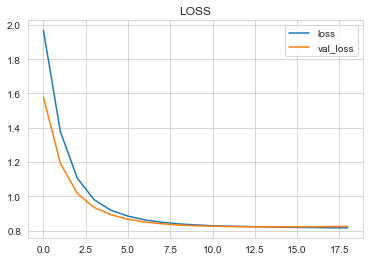

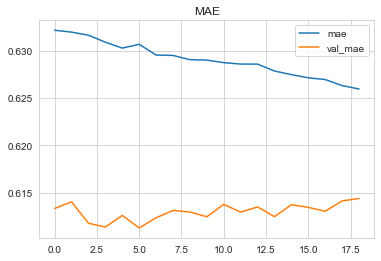

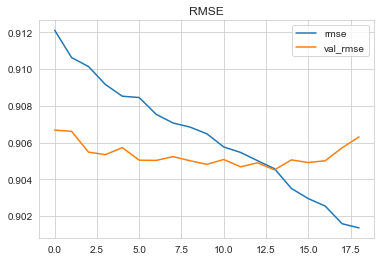

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [222]:
# Plot metrics
for metric in ["loss", "mae", "rmse"]:
    pd.DataFrame(history_5.history, columns=[metric, f"val_{metric}"]).plot()
    plt.title(metric.upper())
    plt.show()

In [223]:
model_conv1D.load_weights(model_file_name)
model = "Conv1D_5"
[loss_test, mae_test, rmse_test] = model_conv1D.evaluate(
    X_test_reshaped, y_test, verbose=1
)

534/534 [==============================] - 1s 2ms/step - loss: 0.8116 - mae: 0.5972 - rmse: 0.8987


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [224]:
pearson_score = pearsonr(model_conv1D.predict(X_test_reshaped).reshape(-1), y_test)[0]

df_test_5 = pd.DataFrame(
    [[model, loss_test, mae_test, rmse_test, pearson_score]],
    columns=["model", "loss_test", "mae_test", "rmse_test", "pearson_score"],
)
df_test_5.insert(loc=1, column="epochs", value=len(hist_df_5))
df_test_5

model  epochs  loss_test  mae_test  rmse_test  pearson_score
0  Conv1D_5      19   0.811581  0.597225   0.898702       0.079202

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [230]:
df_test_conv = pd.concat([df_test_conv, df_test_5], axis=0).reset_index(drop=True)

# Save df
joblib.dump(df_test_conv, "./Data/df_test_conv.joblib")

['./Data/df_test_conv.joblib']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [231]:
df_test_conv

model  epochs  loss_test  mae_test  rmse_test  pearson_score
0       Conv1D_1      15   0.805046  0.594623   0.897243       0.094221
1     Conv1D_1_1      21   0.806851  0.596615   0.898249       0.084132
2  Conv1D_scal_1      24   0.806059  0.594119   0.897808       0.084341
3   Conv1D_pca_1      11   0.807132  0.596023   0.898405       0.074178
4       Conv1D_2       9   0.806295  0.597559   0.897939       0.085613
5       Conv1D_3       8   0.805138  0.595649   0.897295       0.089078
6       Conv1D_4      13   0.825270  0.595556   0.897250       0.089660
7       Conv1D_5      19   0.811581  0.597225   0.898702       0.079202

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [232]:
def build_conv1D_model_6(train_data_reshaped):
    n_timesteps = train_data_reshaped.shape[1]  # 300
    n_features = train_data_reshaped.shape[2]  # 1
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps, n_features)))

    # Convolution 1
    model.add(
        keras.layers.Conv1D(
            filters=64,
            kernel_size=4,
            strides=1,
            padding="same",
            activation="relu",
            name="Conv1D_1",
        )
    )
    model.add(keras.layers.Dropout(0.5))

    # Convolution 2
    model.add(
        keras.layers.Conv1D(
            filters=16, kernel_size=8, strides=3, activation="relu", name="Conv1D_2"
        )
    )

    # Convolution 3
    model.add(
        keras.layers.Conv1D(
            filters=16, kernel_size=3, strides=1, activation="relu", name="Conv1D_3"
        )
    )

    # Convolution 4
    model.add(
        keras.layers.Conv1D(
            filters=32,
            kernel_size=4,
            strides=3,
            padding="same",
            activation="relu",
            name="Conv1D_4",
        )
    )

    # Convolution 5
    model.add(
        keras.layers.Conv1D(
            filters=64,
            kernel_size=4,
            strides=4,
            padding="same",
            activation="relu",
            name="Conv1D_5",
        )
    )

    # Flatten and Dense
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation="relu", name="Dense_2",))
    # model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(32, activation="relu", name="Dense_3",))
    # model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(n_features, name="Dense_4"))

    optimizer = tf.keras.optimizers.Adam(0.001)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")

    model.compile(loss="mse", optimizer=optimizer, metrics=["mae", rmse])
    return model

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [233]:
model_conv1D = build_conv1D_model_6(X_train_reshaped)
model_conv1D.summary()

Model: "model_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 300, 64)           320       
_________________________________________________________________
dropout_64 (Dropout)         (None, 300, 64)           0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 98, 16)            8208      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 96, 16)            784       
_________________________________________________________________
Conv1D_4 (Conv1D)            (None, 32, 32)            2080      
_________________________________________________________________
Conv1D_5 (Conv1D)            (None, 8, 64)             8256      
_________________________________________________________________
flatten_39 (Flatten)         (None, 512)              

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [234]:
# File to save model
model_file_name = "./Models/Conv1D_6.tf"

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=model_file_name,
    monitor="val_rmse",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_rmse", patience=5, verbose=1, restore_best_weights=True
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [235]:
%%time

EPOCHS=30
BATCH_SIZE = 4096

history_6 = model_conv1D.fit(x=X_train_reshaped, 
                             y=y_train, 
                             epochs=EPOCHS, 
                             shuffle= False, 
                             batch_size=BATCH_SIZE, 
                             validation_split=0.2, 
                             callbacks=[checkpoint, early_stop], 
                             verbose=1)

Epoch 1/30
28/28 [==============================] - 54s 2s/step - loss: 0.8301 - mae: 0.6319 - rmse: 0.9111 - val_loss: 0.8218 - val_mae: 0.6143 - val_rmse: 0.9065

Epoch 00001: val_rmse improved from inf to 0.90654, saving model to ./Models/Conv1D_6.tf
Epoch 2/30
28/28 [==============================] - 53s 2s/step - loss: 0.8269 - mae: 0.6308 - rmse: 0.9093 - val_loss: 0.8215 - val_mae: 0.6139 - val_rmse: 0.9064

Epoch 00002: val_rmse improved from 0.90654 to 0.90637, saving model to ./Models/Conv1D_6.tf
Epoch 3/30
28/28 [==============================] - 55s 2s/step - loss: 0.8245 - mae: 0.6307 - rmse: 0.9080 - val_loss: 0.8199 - val_mae: 0.6136 - val_rmse: 0.9055

Epoch 00003: val_rmse improved from 0.90637 to 0.90550, saving model to ./Models/Conv1D_6.tf
Epoch 4/30
28/28 [==============================] - 46s 2s/step - loss: 0.8226 - mae: 0.6297 - rmse: 0.9070 - val_loss: 0.8188 - val_mae: 0.6118 - val_rmse: 0.9049

Epoch 00004: val_rmse improved from 0.90550 to 0.90488, saving mo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [236]:
# Convert the history.history dict to a pandas DataFrame
hist_df_6 = pd.DataFrame(history_6.history)

# Save to csv
hist_6_csv_file = "./Models/history_6.csv"
with open(hist_6_csv_file, mode="w") as f:
    hist_df_6.to_csv(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

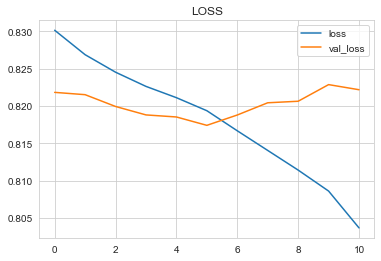

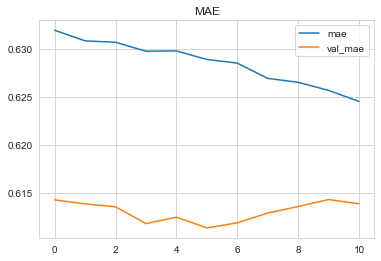

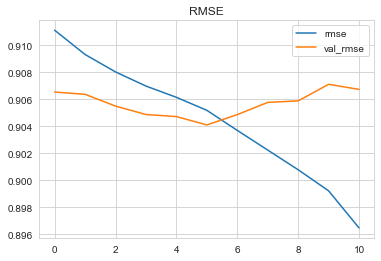

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [237]:
# Plot metrics
for metric in ["loss", "mae", "rmse"]:
    pd.DataFrame(history_6.history, columns=[metric, f"val_{metric}"]).plot()
    plt.title(metric.upper())
    plt.show()

In [238]:
model_conv1D.load_weights(model_file_name)
model = "Conv1D_6"
[loss_test, mae_test, rmse_test] = model_conv1D.evaluate(
    X_test_reshaped, y_test, verbose=1
)

534/534 [==============================] - 1s 3ms/step - loss: 0.8027 - mae: 0.5948 - rmse: 0.8959


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [239]:
pearson_score = pearsonr(model_conv1D.predict(X_test_reshaped).reshape(-1), y_test)[0]

df_test_6 = pd.DataFrame(
    [[model, loss_test, mae_test, rmse_test, pearson_score]],
    columns=["model", "loss_test", "mae_test", "rmse_test", "pearson_score"],
)
df_test_6.insert(loc=1, column="epochs", value=len(hist_df_6))
df_test_6

model  epochs  loss_test  mae_test  rmse_test  pearson_score
0  Conv1D_6      11   0.802662    0.5948   0.895914        0.10514

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [240]:
df_test_conv = pd.concat([df_test_conv, df_test_6], axis=0).reset_index(drop=True)

# Save df
joblib.dump(df_test_conv, "./Data/df_test_conv.joblib")

['./Data/df_test_conv.joblib']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [241]:
df_test_conv

model  epochs  loss_test  mae_test  rmse_test  pearson_score
0       Conv1D_1      15   0.805046  0.594623   0.897243       0.094221
1     Conv1D_1_1      21   0.806851  0.596615   0.898249       0.084132
2  Conv1D_scal_1      24   0.806059  0.594119   0.897808       0.084341
3   Conv1D_pca_1      11   0.807132  0.596023   0.898405       0.074178
4       Conv1D_2       9   0.806295  0.597559   0.897939       0.085613
5       Conv1D_3       8   0.805138  0.595649   0.897295       0.089078
6       Conv1D_4      13   0.825270  0.595556   0.897250       0.089660
7       Conv1D_5      19   0.811581  0.597225   0.898702       0.079202
8       Conv1D_6      11   0.802662  0.594800   0.895914       0.105140

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [242]:
df_test_conv_final = df_test_conv.sort_values(by="pearson_score", ascending=False).head(
    1
)
df_test_conv_final

model  epochs  loss_test  mae_test  rmse_test  pearson_score
8  Conv1D_6      11   0.802662    0.5948   0.895914        0.10514

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [244]:
df_test_conv_final.drop(["epochs", "loss_test", "mae_test"], axis=1, inplace=True)
df_test_conv_final

model  rmse_test  pearson_score
8  Conv1D_6   0.895914        0.10514

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [246]:
df_test_conv_final.insert(loc=1, column="X_data", value="X_train")
df_test_conv_final.rename(
    columns={"rmse_test": "RMSE", "pearson_score": "Pearson_coef"}, inplace=True
)
df_test_conv_final

model   X_data      RMSE  Pearson_coef
8  Conv1D_6  X_train  0.895914       0.10514

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [245]:
tf.keras.backend.clear_session()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [248]:
# Load df
df_final = joblib.load("./Data/df_final.joblib")
df_final

model        X_data      RMSE  Pearson_coef
0  LinearRegression    X_up_pca85  0.897627      0.094731
1        ElasticNet      X_scaled  0.897163      0.098006
2      XGBRegressor  X_scal_pca85  0.898528      0.072302
3      XGBRegressor       X_pca85  0.896879      0.103205

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [249]:
df_final = pd.concat([df_final, df_test_conv_final]).reset_index(drop=True)
df_final

model        X_data      RMSE  Pearson_coef
0  LinearRegression    X_up_pca85  0.897627      0.094731
1        ElasticNet      X_scaled  0.897163      0.098006
2      XGBRegressor  X_scal_pca85  0.898528      0.072302
3      XGBRegressor       X_pca85  0.896879      0.103205
4          Conv1D_6       X_train  0.895914      0.105140

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [250]:
# Save df
joblib.dump(df_final, "./Data/df_final.joblib")

['./Data/df_final.joblib']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>